In [92]:
import numpy as np
import matplotlib.pyplot as plt
from xfoil import XFoil
from xfoil.model import Airfoil
from scipy.interpolate import splrep, splev
from scipy.special import comb
import math
import os
from deap import base, creator, tools, algorithms
from xfoil.test import naca0012
import shutil
try:
    shutil.rmtree("populations")
    os.mkdir("populations")
except:
    os.mkdir("populations")
# Define the airfoil function
n_ctr_pts = 8
n_times = 60
max_iterations= 100
# Genetic Algorithm parameters
population_size = 70
max_generations = 1
re = 1e6
std_x = [naca0012.x[i] for i in range(0, naca0012.x.shape[0], naca0012.x.shape[0] // (n_ctr_pts * 2))][:-1] + [1]
std_y = [naca0012.y[i] for i in range(0, naca0012.x.shape[0], naca0012.x.shape[0] // (n_ctr_pts * 2))][:-1] + [0]
print(len(std_y))

16


In [93]:
def spline(pts):
    points = np.array(pts)
    # Sort points based on x-coordinates
    sorted_indices = np.argsort(points[:, 0])
    sorted_points = points[sorted_indices]

    # Extract x and y coordinates
    x = sorted_points[:, 0]
    y = sorted_points[:, 1]
    plt.plot(x,y)
    spline_params = splrep(x, y, k=2)
    # Generate new x values for plotting the spline
    x_new = np.linspace(x.min(), x.max(), n_times)
    y_new = splev(x_new, spline_params)
    return x_new, y_new

In [94]:

def bernstein_poly(i, n, t):
    """
     The Bernstein polynomial of n, i as a function of t
    """
    return comb(n, i) * ( t**(n-i) ) * (1 - t)**i

def airfoil(h, n_ctr_pts=n_ctr_pts, chord=std_x, nTimes=n_times):
    top_half = [(0,0)] + [(x, y) for x, y in zip(chord[:n_ctr_pts], h[0])][1:-1]  + [(1, 0)]
    x_new_top, y_new_top = spline(top_half)
    low_half = [(0,0)] + [(x, -y) for x, y in zip(chord[n_ctr_pts:], h[1])][1:-1] + [(1, 0)]
    x_new_low, y_new_low = spline(low_half)
    y_new_low = -np.abs(y_new_low)
    x_new = np.append(x_new_top , x_new_low[::-1])
    y_new = np.append(y_new_top , y_new_low[::-1])
    pts = np.column_stack([x_new, y_new])
    plt.plot(x_new, y_new)
    plt.show()
    return pts, Airfoil(x=pts[:, 0], y=pts[:, 1])

def plot_foil(pts, std_points=[naca0012.x, naca0012.y]):
    # Extract x and y coordinates for plotting
    x, y = pts[:, 0], pts[:, 1]
    # Plot the airfoil shape
    plt.figure(figsize=(10, 5))
    plt.plot(x, y, label='Airfoil Shape', color='b', marker='o')
    plt.fill(x, y, 'b', alpha=0.3)  # Fill the shape for better visualization
    plt.plot(std_points[0], std_points[1], label='NACA0012', color='r', marker='o')
    plt.fill(std_points[0], std_points[1], 'r', alpha=0.3)
    # Adding labels and legend
    plt.xlabel('Chord Position')
    plt.ylabel('Height')
    plt.title('Airfoil Shape')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()


In [95]:
def fitness(air):
    xf = XFoil()
    xf.airfoil = air
    xf.Re = re
    xf.max_iter = 100
    cl, cd, cm, cp = xf.a(0)
    return cl, cd

In [96]:
# Function to evaluate fitness (maximize Cl, minimize Cd)
def evaluate_airfoil(individual):
    # Decode individual (genotype) into airfoil parameters
    h = np.array([individual[:n_ctr_pts], np.abs(individual[n_ctr_pts:])])
    
    # Generate airfoil shape
    pts, foil = airfoil(h, n_ctr_pts=n_ctr_pts, chord=std_x, nTimes=n_times)
    print(pts)
    # Use XFoil to evaluate Cl and Cd
    xf = XFoil()
    xf.airfoil = foil
    xf.Re = re
    xf.max_iter = max_iterations
    # Run XFoil analysis

    cl, cd, cm, cp = xf.a(0)
    print(cl, cd)
    if math.isnan(cl) or math.isnan(cd):
        return 0, -10e5
    else:
        # Return Cl and -Cd (minimize Cd -> maximize -Cd)
        return cl, -cd


: 

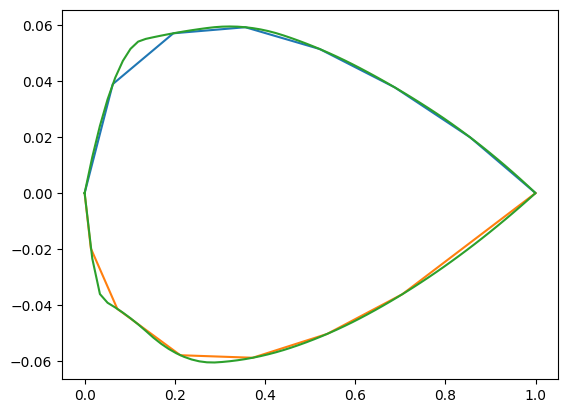

In [97]:
evaluate_airfoil(std_y)

c:\Users\amine\miniconda3\envs\xfoil\lib\site-packages\deap\creator.py:188: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
c:\Users\amine\miniconda3\envs\xfoil\lib\site-packages\deap\creator.py:188: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


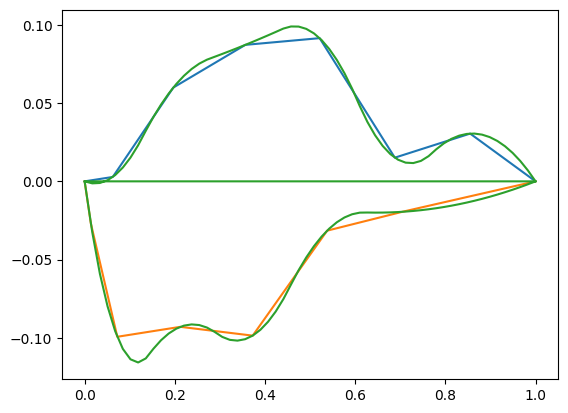

[[ 0.00000000e+00 -4.18824924e-19]
 [ 1.69491525e-02 -1.28478017e-03]
 [ 3.38983051e-02 -1.04259306e-03]
 [ 5.08474576e-02  7.26561325e-04]
 [ 6.77966102e-02  4.02268300e-03]
 [ 8.47457627e-02  8.84577195e-03]
 [ 1.01694915e-01  1.51958282e-02]
 [ 1.18644068e-01  2.30728517e-02]
 [ 1.35593220e-01  3.23221781e-02]
 [ 1.52542373e-01  4.11703358e-02]
 [ 1.69491525e-01  4.91142636e-02]
 [ 1.86440678e-01  5.61539617e-02]
 [ 2.03389831e-01  6.22894299e-02]
 [ 2.20338983e-01  6.75206684e-02]
 [ 2.37288136e-01  7.18476771e-02]
 [ 2.54237288e-01  7.52704561e-02]
 [ 2.71186441e-01  7.77890052e-02]
 [ 2.88135593e-01  7.96257102e-02]
 [ 3.05084746e-01  8.14589850e-02]
 [ 3.22033898e-01  8.33358457e-02]
 [ 3.38983051e-01  8.52562922e-02]
 [ 3.55932203e-01  8.72203246e-02]
 [ 3.72881356e-01  8.92279429e-02]
 [ 3.89830508e-01  9.12791471e-02]
 [ 4.06779661e-01  9.33739371e-02]
 [ 4.23728814e-01  9.55123130e-02]
 [ 4.40677966e-01  9.76849679e-02]
 [ 4.57627119e-01  9.90234209e-02]
 [ 4.74576271e-01  9

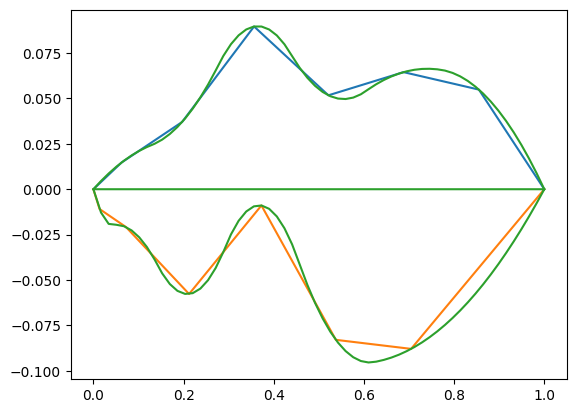

[[ 0.00000000e+00 -8.37649847e-19]
 [ 1.69491525e-02  4.53319794e-03]
 [ 3.38983051e-02  8.66180046e-03]
 [ 5.08474576e-02  1.23858076e-02]
 [ 6.77966102e-02  1.57052193e-02]
 [ 8.47457627e-02  1.86200356e-02]
 [ 1.01694915e-01  2.11302564e-02]
 [ 1.18644068e-01  2.32358819e-02]
 [ 1.35593220e-01  2.50123548e-02]
 [ 1.52542373e-01  2.73247471e-02]
 [ 1.69491525e-01  3.04184441e-02]
 [ 1.86440678e-01  3.42934458e-02]
 [ 2.03389831e-01  3.89497522e-02]
 [ 2.20338983e-01  4.43873633e-02]
 [ 2.37288136e-01  5.06062791e-02]
 [ 2.54237288e-01  5.76064996e-02]
 [ 2.71186441e-01  6.53880248e-02]
 [ 2.88135593e-01  7.33861810e-02]
 [ 3.05084746e-01  7.98783630e-02]
 [ 3.22033898e-01  8.47451895e-02]
 [ 3.38983051e-01  8.79866604e-02]
 [ 3.55932203e-01  8.96027758e-02]
 [ 3.72881356e-01  8.95935357e-02]
 [ 3.89830508e-01  8.79589400e-02]
 [ 4.06779661e-01  8.46989887e-02]
 [ 4.23728814e-01  7.98136819e-02]
 [ 4.40677966e-01  7.33201792e-02]
 [ 4.57627119e-01  6.68197508e-02]
 [ 4.74576271e-01  6

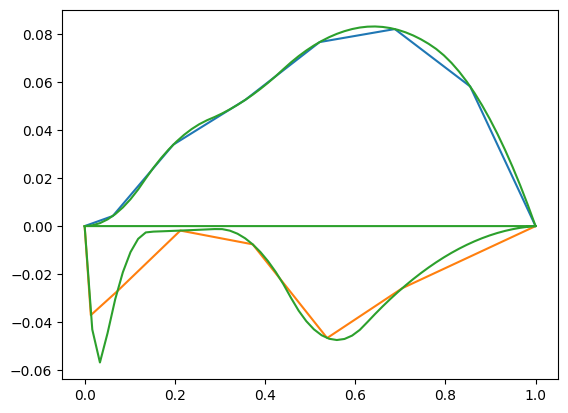

[[ 0.00000000e+00 -4.18824924e-19]
 [ 1.69491525e-02  3.03644677e-04]
 [ 3.38983051e-02  1.23293438e-03]
 [ 5.08474576e-02  2.78786910e-03]
 [ 6.77966102e-02  4.96844884e-03]
 [ 8.47457627e-02  7.77467360e-03]
 [ 1.01694915e-01  1.12065434e-02]
 [ 1.18644068e-01  1.52640582e-02]
 [ 1.35593220e-01  1.98819670e-02]
 [ 1.52542373e-01  2.43120630e-02]
 [ 1.69491525e-01  2.83421108e-02]
 [ 1.86440678e-01  3.19721104e-02]
 [ 2.03389831e-01  3.52020619e-02]
 [ 2.20338983e-01  3.80319651e-02]
 [ 2.37288136e-01  4.04618201e-02]
 [ 2.54237288e-01  4.24916269e-02]
 [ 2.71186441e-01  4.41213855e-02]
 [ 2.88135593e-01  4.54863073e-02]
 [ 3.05084746e-01  4.69988704e-02]
 [ 3.22033898e-01  4.86876610e-02]
 [ 3.38983051e-01  5.05526789e-02]
 [ 3.55932203e-01  5.25939243e-02]
 [ 3.72881356e-01  5.48113970e-02]
 [ 3.89830508e-01  5.72050971e-02]
 [ 4.06779661e-01  5.97750245e-02]
 [ 4.23728814e-01  6.25211794e-02]
 [ 4.40677966e-01  6.54408490e-02]
 [ 4.57627119e-01  6.82809068e-02]
 [ 4.74576271e-01  7

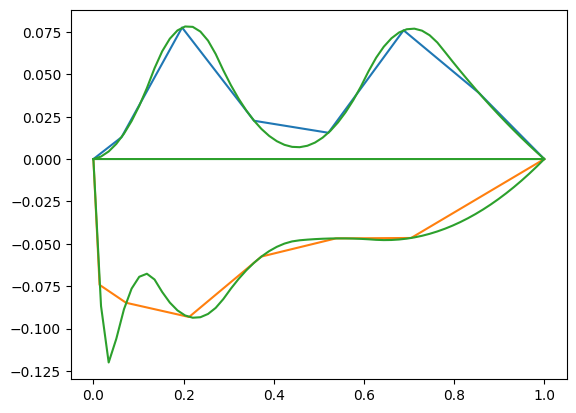

[[ 0.00000000e+00 -2.51294954e-18]
 [ 1.69491525e-02  1.49004633e-03]
 [ 3.38983051e-02  4.47719818e-03]
 [ 5.08474576e-02  8.96145554e-03]
 [ 6.77966102e-02  1.49428184e-02]
 [ 8.47457627e-02  2.24212868e-02]
 [ 1.01694915e-01  3.13968607e-02]
 [ 1.18644068e-01  4.18695401e-02]
 [ 1.35593220e-01  5.35815211e-02]
 [ 1.52542373e-01  6.35766735e-02]
 [ 1.69491525e-01  7.10164648e-02]
 [ 1.86440678e-01  7.59008951e-02]
 [ 2.03389831e-01  7.82299642e-02]
 [ 2.20338983e-01  7.80036722e-02]
 [ 2.37288136e-01  7.52220191e-02]
 [ 2.54237288e-01  6.98850049e-02]
 [ 2.71186441e-01  6.19926297e-02]
 [ 2.88135593e-01  5.23686914e-02]
 [ 3.05084746e-01  4.35262848e-02]
 [ 3.22033898e-01  3.56395745e-02]
 [ 3.38983051e-01  2.87085606e-02]
 [ 3.55932203e-01  2.27332430e-02]
 [ 3.72881356e-01  1.77136217e-02]
 [ 3.89830508e-01  1.36496969e-02]
 [ 4.06779661e-01  1.05414683e-02]
 [ 4.23728814e-01  8.38893613e-03]
 [ 4.40677966e-01  7.19262132e-03]
 [ 4.57627119e-01  7.00114376e-03]
 [ 4.74576271e-01  7

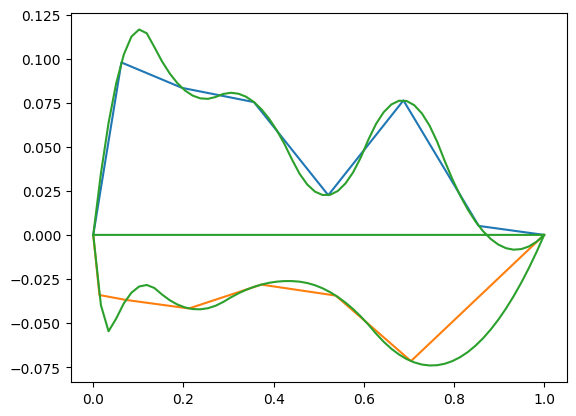

[[ 0.00000000e+00 -5.44472401e-18]
 [ 1.69491525e-02  3.48469505e-02]
 [ 3.38983051e-02  6.35247475e-02]
 [ 5.08474576e-02  8.60333909e-02]
 [ 6.77966102e-02  1.02372881e-01]
 [ 8.47457627e-02  1.12543217e-01]
 [ 1.01694915e-01  1.16544400e-01]
 [ 1.18644068e-01  1.14376429e-01]
 [ 1.35593220e-01  1.06514760e-01]
 [ 1.52542373e-01  9.84112449e-02]
 [ 1.69491525e-01  9.16123485e-02]
 [ 1.86440678e-01  8.61180712e-02]
 [ 2.03389831e-01  8.19284129e-02]
 [ 2.20338983e-01  7.90433738e-02]
 [ 2.37288136e-01  7.74629537e-02]
 [ 2.54237288e-01  7.71871528e-02]
 [ 2.71186441e-01  7.82159709e-02]
 [ 2.88135593e-01  7.99616113e-02]
 [ 3.05084746e-01  8.06309297e-02]
 [ 3.22033898e-01  8.00996560e-02]
 [ 3.38983051e-01  7.83677902e-02]
 [ 3.55932203e-01  7.54353323e-02]
 [ 3.72881356e-01  7.13022822e-02]
 [ 3.89830508e-01  6.59686401e-02]
 [ 4.06779661e-01  5.94344059e-02]
 [ 4.23728814e-01  5.16995795e-02]
 [ 4.40677966e-01  4.27851691e-02]
 [ 4.57627119e-01  3.46515587e-02]
 [ 4.74576271e-01  2

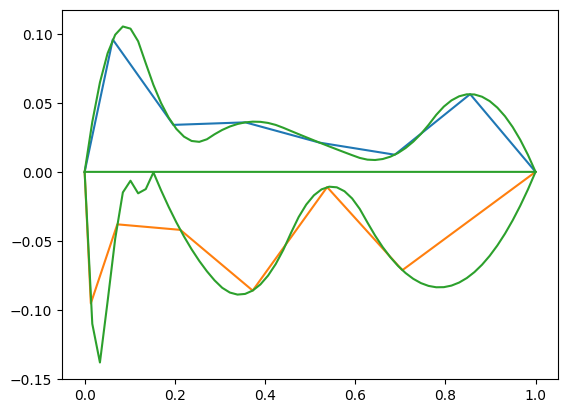

[[ 0.00000000e+00  5.75884270e-19]
 [ 1.69491525e-02  3.61448861e-02]
 [ 3.38983051e-02  6.47457803e-02]
 [ 5.08474576e-02  8.58026825e-02]
 [ 6.77966102e-02  9.93155929e-02]
 [ 8.47457627e-02  1.05284511e-01]
 [ 1.01694915e-01  1.03709438e-01]
 [ 1.18644068e-01  9.45903723e-02]
 [ 1.35593220e-01  7.85660318e-02]
 [ 1.52542373e-01  6.29603160e-02]
 [ 1.69491525e-01  4.98507141e-02]
 [ 1.86440678e-01  3.92372260e-02]
 [ 2.03389831e-01  3.11198517e-02]
 [ 2.20338983e-01  2.54985912e-02]
 [ 2.37288136e-01  2.23734446e-02]
 [ 2.54237288e-01  2.17444118e-02]
 [ 2.71186441e-01  2.36114929e-02]
 [ 2.88135593e-01  2.72360178e-02]
 [ 3.05084746e-01  3.03645854e-02]
 [ 3.22033898e-01  3.28410285e-02]
 [ 3.38983051e-01  3.46653471e-02]
 [ 3.55932203e-01  3.58375412e-02]
 [ 3.72881356e-01  3.63576108e-02]
 [ 3.89830508e-01  3.62255559e-02]
 [ 4.06779661e-01  3.54413765e-02]
 [ 4.23728814e-01  3.40050726e-02]
 [ 4.40677966e-01  3.19210332e-02]
 [ 4.57627119e-01  2.95988261e-02]
 [ 4.74576271e-01  2

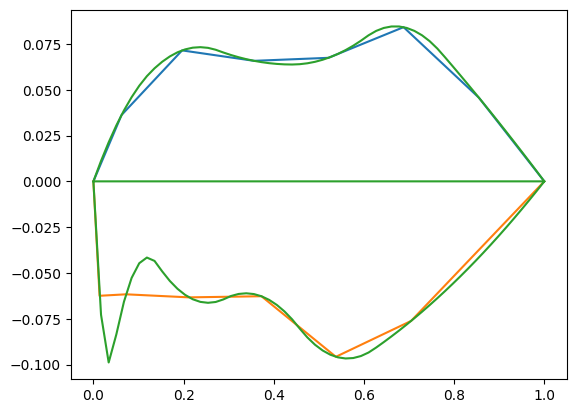

[[ 0.00000000e+00 -2.51294954e-18]
 [ 1.69491525e-02  1.11509624e-02]
 [ 3.38983051e-02  2.13186812e-02]
 [ 5.08474576e-02  3.05031564e-02]
 [ 6.77966102e-02  3.87043880e-02]
 [ 8.47457627e-02  4.59223760e-02]
 [ 1.01694915e-01  5.21571203e-02]
 [ 1.18644068e-01  5.74086210e-02]
 [ 1.35593220e-01  6.16976468e-02]
 [ 1.52542373e-01  6.52623432e-02]
 [ 1.69491525e-01  6.81702625e-02]
 [ 1.86440678e-01  7.04214046e-02]
 [ 2.03389831e-01  7.20157696e-02]
 [ 2.20338983e-01  7.29533573e-02]
 [ 2.37288136e-01  7.32341679e-02]
 [ 2.54237288e-01  7.28582013e-02]
 [ 2.71186441e-01  7.18254576e-02]
 [ 2.88135593e-01  7.03279944e-02]
 [ 3.05084746e-01  6.89517070e-02]
 [ 3.22033898e-01  6.77371995e-02]
 [ 3.38983051e-01  6.66844719e-02]
 [ 3.55932203e-01  6.57935243e-02]
 [ 3.72881356e-01  6.50643566e-02]
 [ 3.89830508e-01  6.44969688e-02]
 [ 4.06779661e-01  6.40913610e-02]
 [ 4.23728814e-01  6.38475332e-02]
 [ 4.40677966e-01  6.37664823e-02]
 [ 4.57627119e-01  6.39412476e-02]
 [ 4.74576271e-01  6

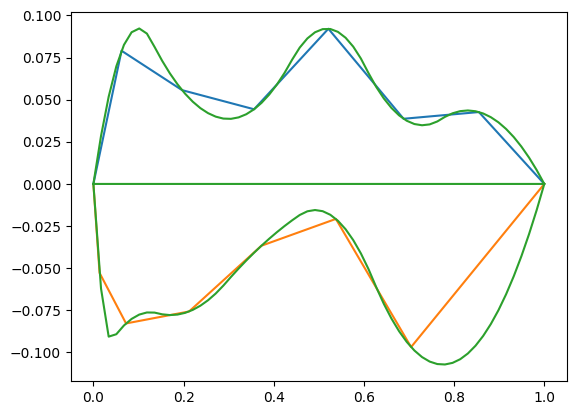

[[ 0.00000000e+00  3.35059939e-18]
 [ 1.69491525e-02  2.85202831e-02]
 [ 3.38983051e-02  5.17829686e-02]
 [ 5.08474576e-02  6.97880567e-02]
 [ 6.77966102e-02  8.25355472e-02]
 [ 8.47457627e-02  9.00254403e-02]
 [ 1.01694915e-01  9.22577358e-02]
 [ 1.18644068e-01  8.92324337e-02]
 [ 1.35593220e-01  8.13403985e-02]
 [ 1.52542373e-01  7.30635074e-02]
 [ 1.69491525e-01  6.56730848e-02]
 [ 1.86440678e-01  5.91691306e-02]
 [ 2.03389831e-01  5.35516449e-02]
 [ 2.20338983e-01  4.88206277e-02]
 [ 2.37288136e-01  4.49760789e-02]
 [ 2.54237288e-01  4.20179986e-02]
 [ 2.71186441e-01  3.99463867e-02]
 [ 2.88135593e-01  3.87899975e-02]
 [ 3.05084746e-01  3.86365493e-02]
 [ 3.22033898e-01  3.94921212e-02]
 [ 3.38983051e-01  4.13567131e-02]
 [ 3.55932203e-01  4.42303251e-02]
 [ 3.72881356e-01  4.81129572e-02]
 [ 3.89830508e-01  5.30046093e-02]
 [ 4.06779661e-01  5.89052815e-02]
 [ 4.23728814e-01  6.58149739e-02]
 [ 4.40677966e-01  7.37157105e-02]
 [ 4.57627119e-01  8.09300712e-02]
 [ 4.74576271e-01  8

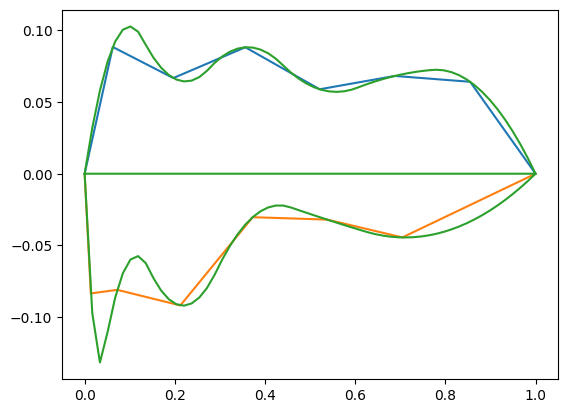

[[ 0.00000000e+00  1.46588723e-18]
 [ 1.69491525e-02  3.20059452e-02]
 [ 3.38983051e-02  5.80608297e-02]
 [ 5.08474576e-02  7.81646534e-02]
 [ 6.77966102e-02  9.23174163e-02]
 [ 8.47457627e-02  1.00519119e-01]
 [ 1.01694915e-01  1.02769760e-01]
 [ 1.18644068e-01  9.90693407e-02]
 [ 1.35593220e-01  8.99167574e-02]
 [ 1.52542373e-01  8.10326505e-02]
 [ 1.69491525e-01  7.40397304e-02]
 [ 1.86440678e-01  6.89379973e-02]
 [ 2.03389831e-01  6.57274510e-02]
 [ 2.20338983e-01  6.44080916e-02]
 [ 2.37288136e-01  6.49799190e-02]
 [ 2.54237288e-01  6.74429333e-02]
 [ 2.71186441e-01  7.17971344e-02]
 [ 2.88135593e-01  7.73225043e-02]
 [ 3.05084746e-01  8.18225412e-02]
 [ 3.22033898e-01  8.51450212e-02]
 [ 3.38983051e-01  8.72899445e-02]
 [ 3.55932203e-01  8.82573109e-02]
 [ 3.72881356e-01  8.80471205e-02]
 [ 3.89830508e-01  8.66593733e-02]
 [ 4.06779661e-01  8.40940692e-02]
 [ 4.23728814e-01  8.03512083e-02]
 [ 4.40677966e-01  7.54432824e-02]
 [ 4.57627119e-01  7.05359813e-02]
 [ 4.74576271e-01  6

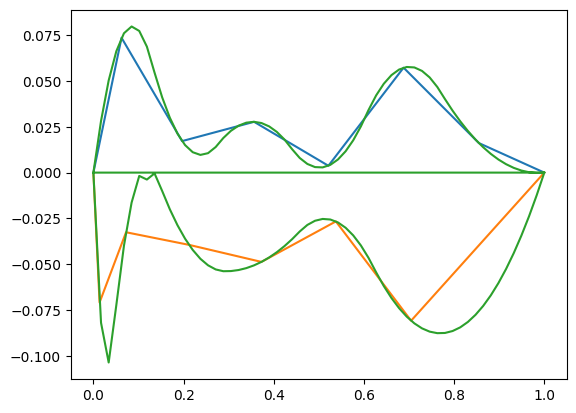

[[ 0.00000000e+00  5.83737237e-18]
 [ 1.69491525e-02  2.81944959e-02]
 [ 3.38983051e-02  5.02627568e-02]
 [ 5.08474576e-02  6.62047829e-02]
 [ 6.77966102e-02  7.60205740e-02]
 [ 8.47457627e-02  7.97101302e-02]
 [ 1.01694915e-01  7.72734515e-02]
 [ 1.18644068e-01  6.87105379e-02]
 [ 1.35593220e-01  5.45642984e-02]
 [ 1.52542373e-01  4.10600440e-02]
 [ 1.69491525e-01  2.99636394e-02]
 [ 1.86440678e-01  2.12750846e-02]
 [ 2.03389831e-01  1.49943796e-02]
 [ 2.20338983e-01  1.11215244e-02]
 [ 2.37288136e-01  9.65651899e-03]
 [ 2.54237288e-01  1.05993634e-02]
 [ 2.71186441e-01  1.39500576e-02]
 [ 2.88135593e-01  1.88724754e-02]
 [ 3.05084746e-01  2.28159134e-02]
 [ 3.22033898e-01  2.56036006e-02]
 [ 3.38983051e-01  2.72355371e-02]
 [ 3.55932203e-01  2.77117227e-02]
 [ 3.72881356e-01  2.70321576e-02]
 [ 3.89830508e-01  2.51968417e-02]
 [ 4.06779661e-01  2.22057749e-02]
 [ 4.23728814e-01  1.80589574e-02]
 [ 4.40677966e-01  1.27737757e-02]
 [ 4.57627119e-01  7.97267619e-03]
 [ 4.74576271e-01  4

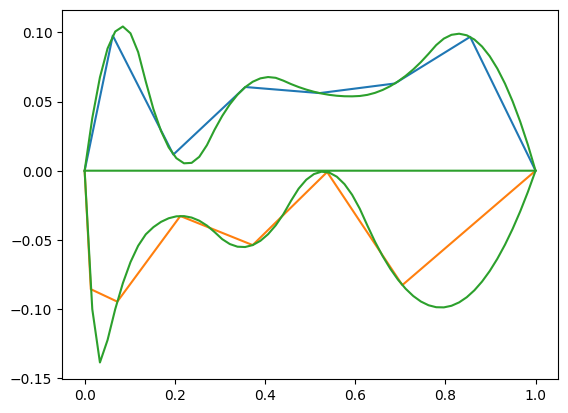

[[ 0.00000000e+00  6.28237385e-19]
 [ 1.69491525e-02  3.80867945e-02]
 [ 3.38983051e-02  6.75658350e-02]
 [ 5.08474576e-02  8.84371215e-02]
 [ 6.77966102e-02  1.00700654e-01]
 [ 8.47457627e-02  1.04356433e-01]
 [ 1.01694915e-01  9.94044571e-02]
 [ 1.18644068e-01  8.58447275e-02]
 [ 1.35593220e-01  6.44825614e-02]
 [ 1.52542373e-01  4.45521955e-02]
 [ 1.69491525e-01  2.86730033e-02]
 [ 1.86440678e-01  1.68449846e-02]
 [ 2.03389831e-01  9.06813965e-03]
 [ 2.20338983e-01  5.34246827e-03]
 [ 2.37288136e-01  5.66797052e-03]
 [ 2.54237288e-01  1.00446464e-02]
 [ 2.71186441e-01  1.84724959e-02]
 [ 2.88135593e-01  2.96486937e-02]
 [ 3.05084746e-01  3.95988154e-02]
 [ 3.22033898e-01  4.80474220e-02]
 [ 3.38983051e-01  5.49945135e-02]
 [ 3.55932203e-01  6.04400897e-02]
 [ 3.72881356e-01  6.43841509e-02]
 [ 3.89830508e-01  6.68266969e-02]
 [ 4.06779661e-01  6.77677277e-02]
 [ 4.23728814e-01  6.72072434e-02]
 [ 4.40677966e-01  6.51568336e-02]
 [ 4.57627119e-01  6.26979972e-02]
 [ 4.74576271e-01  6

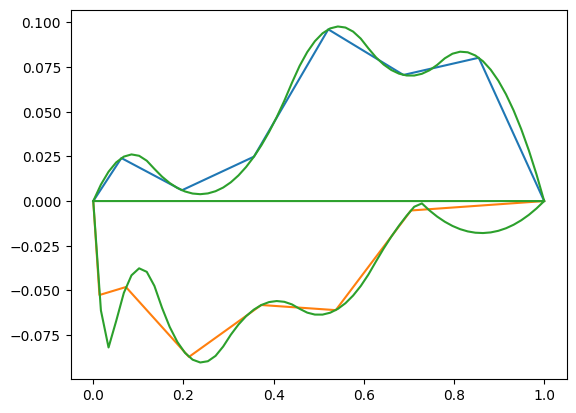

[[ 0.00000000e+00  1.57059346e-18]
 [ 1.69491525e-02  9.21398628e-03]
 [ 3.38983051e-02  1.64324275e-02]
 [ 5.08474576e-02  2.16553238e-02]
 [ 6.77966102e-02  2.48826750e-02]
 [ 8.47457627e-02  2.61144812e-02]
 [ 1.01694915e-01  2.53507424e-02]
 [ 1.18644068e-01  2.25914586e-02]
 [ 1.35593220e-01  1.80143745e-02]
 [ 1.52542373e-01  1.36576139e-02]
 [ 1.69491525e-01  1.00993089e-02]
 [ 1.86440678e-01  7.33945935e-03]
 [ 2.03389831e-01  5.37806536e-03]
 [ 2.20338983e-01  4.21512691e-03]
 [ 2.37288136e-01  3.85064398e-03]
 [ 2.54237288e-01  4.28461657e-03]
 [ 2.71186441e-01  5.51704470e-03]
 [ 2.88135593e-01  7.57049724e-03]
 [ 3.05084746e-01  1.05138233e-02]
 [ 3.22033898e-01  1.43517942e-02]
 [ 3.38983051e-01  1.90844101e-02]
 [ 3.55932203e-01  2.47116709e-02]
 [ 3.72881356e-01  3.12335767e-02]
 [ 3.89830508e-01  3.86501274e-02]
 [ 4.06779661e-01  4.69613230e-02]
 [ 4.23728814e-01  5.61671635e-02]
 [ 4.40677966e-01  6.62511456e-02]
 [ 4.57627119e-01  7.56732355e-02]
 [ 4.74576271e-01  8

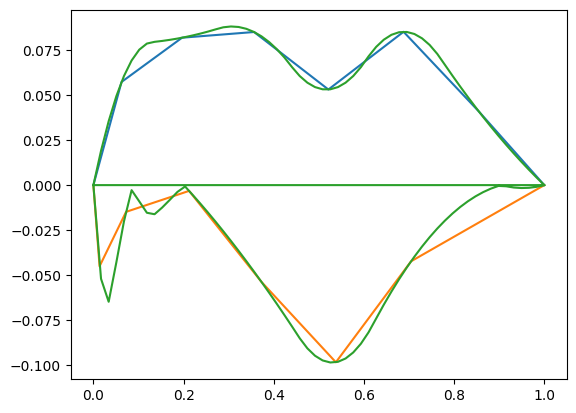

[[ 0.00000000e+00  2.93177447e-18]
 [ 1.69491525e-02  1.90638805e-02]
 [ 3.38983051e-02  3.55169435e-02]
 [ 5.08474576e-02  4.93591891e-02]
 [ 6.77966102e-02  6.05906173e-02]
 [ 8.47457627e-02  6.92112280e-02]
 [ 1.01694915e-01  7.52210213e-02]
 [ 1.18644068e-01  7.86199972e-02]
 [ 1.35593220e-01  7.95808694e-02]
 [ 1.52542373e-01  8.00840745e-02]
 [ 1.69491525e-01  8.06913812e-02]
 [ 1.86440678e-01  8.14027893e-02]
 [ 2.03389831e-01  8.22182988e-02]
 [ 2.20338983e-01  8.31379098e-02]
 [ 2.37288136e-01  8.41616223e-02]
 [ 2.54237288e-01  8.52894362e-02]
 [ 2.71186441e-01  8.65213515e-02]
 [ 2.88135593e-01  8.76618113e-02]
 [ 3.05084746e-01  8.81142456e-02]
 [ 3.22033898e-01  8.78373103e-02]
 [ 3.38983051e-01  8.68310055e-02]
 [ 3.55932203e-01  8.50953312e-02]
 [ 3.72881356e-01  8.26302872e-02]
 [ 3.89830508e-01  7.94358738e-02]
 [ 4.06779661e-01  7.55120908e-02]
 [ 4.23728814e-01  7.08589382e-02]
 [ 4.40677966e-01  6.54890140e-02]
 [ 4.57627119e-01  6.05779046e-02]
 [ 4.74576271e-01  5

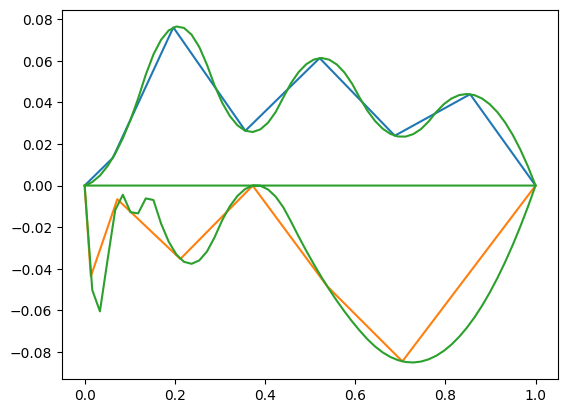

[[ 0.00000000e+00 -8.37649847e-19]
 [ 1.69491525e-02  1.69005920e-03]
 [ 3.38983051e-02  4.80977872e-03]
 [ 5.08474576e-02  9.35915856e-03]
 [ 6.77966102e-02  1.53381987e-02]
 [ 8.47457627e-02  2.27468992e-02]
 [ 1.01694915e-01  3.15852599e-02]
 [ 1.18644068e-01  4.18532810e-02]
 [ 1.35593220e-01  5.32950142e-02]
 [ 1.52542373e-01  6.29756079e-02]
 [ 1.69491525e-01  7.00625654e-02]
 [ 1.86440678e-01  7.45558867e-02]
 [ 2.03389831e-01  7.64555718e-02]
 [ 2.20338983e-01  7.57616207e-02]
 [ 2.37288136e-01  7.24740335e-02]
 [ 2.54237288e-01  6.65928101e-02]
 [ 2.71186441e-01  5.81179505e-02]
 [ 2.88135593e-01  4.81084331e-02]
 [ 3.05084746e-01  3.97947984e-02]
 [ 3.22033898e-01  3.34009321e-02]
 [ 3.38983051e-01  2.89268341e-02]
 [ 3.55932203e-01  2.63725045e-02]
 [ 3.72881356e-01  2.57379433e-02]
 [ 3.89830508e-01  2.70231504e-02]
 [ 4.06779661e-01  3.02281259e-02]
 [ 4.23728814e-01  3.53528698e-02]
 [ 4.40677966e-01  4.23751777e-02]
 [ 4.57627119e-01  4.92230331e-02]
 [ 4.74576271e-01  5

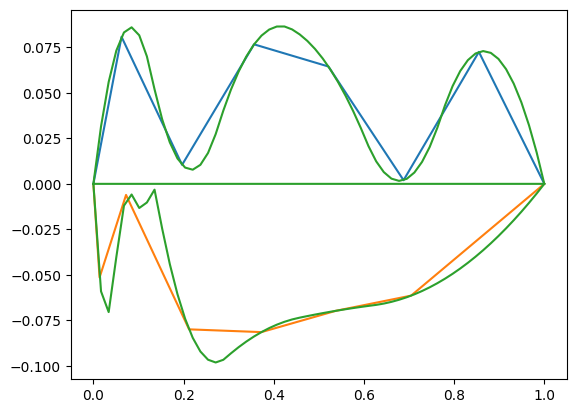

[[ 0.00000000e+00  6.38708009e-18]
 [ 1.69491525e-02  3.16113632e-02]
 [ 3.38983051e-02  5.60230384e-02]
 [ 5.08474576e-02  7.32350255e-02]
 [ 6.77966102e-02  8.32473246e-02]
 [ 8.47457627e-02  8.60599356e-02]
 [ 1.01694915e-01  8.16728585e-02]
 [ 1.18644068e-01  7.00860934e-02]
 [ 1.35593220e-01  5.20020340e-02]
 [ 1.52542373e-01  3.54747349e-02]
 [ 1.69491525e-01  2.27888004e-02]
 [ 1.86440678e-01  1.39442305e-02]
 [ 2.03389831e-01  8.94102501e-03]
 [ 2.20338983e-01  7.77918411e-03]
 [ 2.37288136e-01  1.04587077e-02]
 [ 2.54237288e-01  1.69795959e-02]
 [ 2.71186441e-01  2.73418486e-02]
 [ 2.88135593e-01  4.02580374e-02]
 [ 3.05084746e-01  5.18007079e-02]
 [ 3.22033898e-01  6.16976762e-02]
 [ 3.38983051e-01  6.99489423e-02]
 [ 3.55932203e-01  7.65545061e-02]
 [ 3.72881356e-01  8.15143678e-02]
 [ 3.89830508e-01  8.48285272e-02]
 [ 4.06779661e-01  8.64969845e-02]
 [ 4.23728814e-01  8.65197395e-02]
 [ 4.40677966e-01  8.49021227e-02]
 [ 4.57627119e-01  8.21415437e-02]
 [ 4.74576271e-01  7

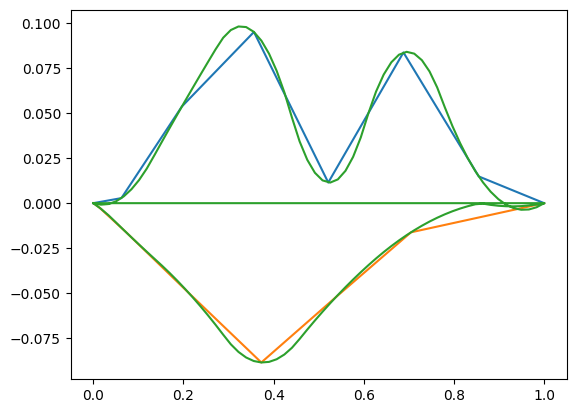

[[ 0.00000000e+00 -6.28237385e-19]
 [ 1.69491525e-02 -8.37714224e-04]
 [ 3.38983051e-02 -4.82201919e-04]
 [ 5.08474576e-02  1.06653691e-03]
 [ 6.77966102e-02  3.80850228e-03]
 [ 8.47457627e-02  7.74369417e-03]
 [ 1.01694915e-01  1.28721126e-02]
 [ 1.18644068e-01  1.91937575e-02]
 [ 1.35593220e-01  2.66277519e-02]
 [ 1.52542373e-01  3.42467116e-02]
 [ 1.69491525e-01  4.17875760e-02]
 [ 1.86440678e-01  4.92503451e-02]
 [ 2.03389831e-01  5.66350188e-02]
 [ 2.20338983e-01  6.39415971e-02]
 [ 2.37288136e-01  7.11700801e-02]
 [ 2.54237288e-01  7.83204678e-02]
 [ 2.71186441e-01  8.53927601e-02]
 [ 2.88135593e-01  9.18648660e-02]
 [ 3.05084746e-01  9.61440840e-02]
 [ 3.22033898e-01  9.81200354e-02]
 [ 3.38983051e-01  9.77927201e-02]
 [ 3.55932203e-01  9.51621382e-02]
 [ 3.72881356e-01  9.02282896e-02]
 [ 3.89830508e-01  8.29911744e-02]
 [ 4.06779661e-01  7.34507925e-02]
 [ 4.23728814e-01  6.16071440e-02]
 [ 4.40677966e-01  4.74943204e-02]
 [ 4.57627119e-01  3.42936045e-02]
 [ 4.74576271e-01  2

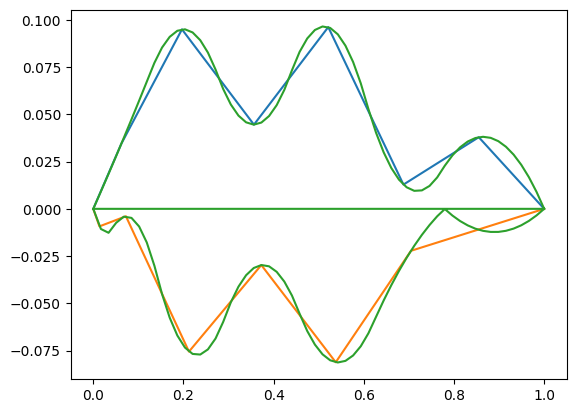

[[ 0.00000000e+00 -8.37649847e-19]
 [ 1.69491525e-02  9.19013774e-03]
 [ 3.38983051e-02  1.85194011e-02]
 [ 5.08474576e-02  2.79877902e-02]
 [ 6.77966102e-02  3.75953049e-02]
 [ 8.47457627e-02  4.73419453e-02]
 [ 1.01694915e-01  5.72277113e-02]
 [ 1.18644068e-01  6.72526029e-02]
 [ 1.35593220e-01  7.72525976e-02]
 [ 1.52542373e-01  8.53469154e-02]
 [ 1.69491525e-01  9.10020567e-02]
 [ 1.86440678e-01  9.42180212e-02]
 [ 2.03389831e-01  9.49948092e-02]
 [ 2.20338983e-01  9.33324205e-02]
 [ 2.37288136e-01  8.92308552e-02]
 [ 2.54237288e-01  8.26901132e-02]
 [ 2.71186441e-01  7.37101947e-02]
 [ 2.88135593e-01  6.34098656e-02]
 [ 3.05084746e-01  5.52020561e-02]
 [ 3.22033898e-01  4.93232920e-02]
 [ 3.38983051e-01  4.57735734e-02]
 [ 3.55932203e-01  4.45529002e-02]
 [ 3.72881356e-01  4.56612724e-02]
 [ 3.89830508e-01  4.90986901e-02]
 [ 4.06779661e-01  5.48651531e-02]
 [ 4.23728814e-01  6.29606617e-02]
 [ 4.40677966e-01  7.33533556e-02]
 [ 4.57627119e-01  8.30701892e-02]
 [ 4.74576271e-01  9

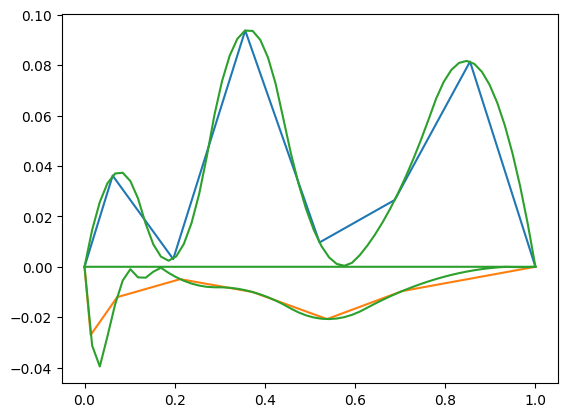

[[ 0.00000000e+00  3.03648070e-18]
 [ 1.69491525e-02  1.46440360e-02]
 [ 3.38983051e-02  2.56990226e-02]
 [ 5.08474576e-02  3.31649600e-02]
 [ 6.77966102e-02  3.70418482e-02]
 [ 8.47457627e-02  3.73296870e-02]
 [ 1.01694915e-01  3.40284766e-02]
 [ 1.18644068e-01  2.71382169e-02]
 [ 1.35593220e-01  1.70963978e-02]
 [ 1.52542373e-01  8.91953299e-03]
 [ 1.69491525e-01  4.03060113e-03]
 [ 1.86440678e-01  2.42960222e-03]
 [ 2.03389831e-01  4.11653624e-03]
 [ 2.20338983e-01  9.09140319e-03]
 [ 2.37288136e-01  1.73542031e-02]
 [ 2.54237288e-01  2.89049359e-02]
 [ 2.71186441e-01  4.37436017e-02]
 [ 2.88135593e-01  6.02994028e-02]
 [ 3.05084746e-01  7.37804329e-02]
 [ 3.22033898e-01  8.38545992e-02]
 [ 3.38983051e-01  9.05219017e-02]
 [ 3.55932203e-01  9.37823404e-02]
 [ 3.72881356e-01  9.36359153e-02]
 [ 3.89830508e-01  9.00826264e-02]
 [ 4.06779661e-01  8.31224737e-02]
 [ 4.23728814e-01  7.27554571e-02]
 [ 4.40677966e-01  5.90156539e-02]
 [ 4.57627119e-01  4.50830006e-02]
 [ 4.74576271e-01  3

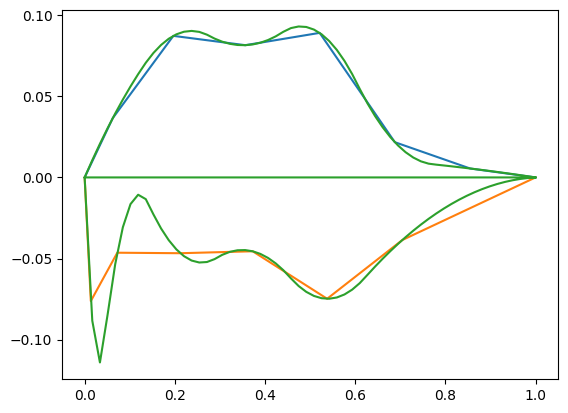

[[ 0.00000000e+00  8.37649847e-19]
 [ 1.69491525e-02  1.06182002e-02]
 [ 3.38983051e-02  2.07291995e-02]
 [ 5.08474576e-02  3.03329979e-02]
 [ 6.77966102e-02  3.94295954e-02]
 [ 8.47457627e-02  4.80189921e-02]
 [ 1.01694915e-01  5.61011878e-02]
 [ 1.18644068e-01  6.36761827e-02]
 [ 1.35593220e-01  7.07057458e-02]
 [ 1.52542373e-01  7.67515002e-02]
 [ 1.69491525e-01  8.16890964e-02]
 [ 1.86440678e-01  8.55185343e-02]
 [ 2.03389831e-01  8.82398140e-02]
 [ 2.20338983e-01  8.98529355e-02]
 [ 2.37288136e-01  9.03578987e-02]
 [ 2.54237288e-01  8.97547036e-02]
 [ 2.71186441e-01  8.80433503e-02]
 [ 2.88135593e-01  8.56233173e-02]
 [ 3.05084746e-01  8.37132613e-02]
 [ 3.22033898e-01  8.23976388e-02]
 [ 3.38983051e-01  8.16764499e-02]
 [ 3.55932203e-01  8.15496944e-02]
 [ 3.72881356e-01  8.20173725e-02]
 [ 3.89830508e-01  8.30794841e-02]
 [ 4.06779661e-01  8.47360292e-02]
 [ 4.23728814e-01  8.69870078e-02]
 [ 4.40677966e-01  8.98202680e-02]
 [ 4.57627119e-01  9.21018369e-02]
 [ 4.74576271e-01  9

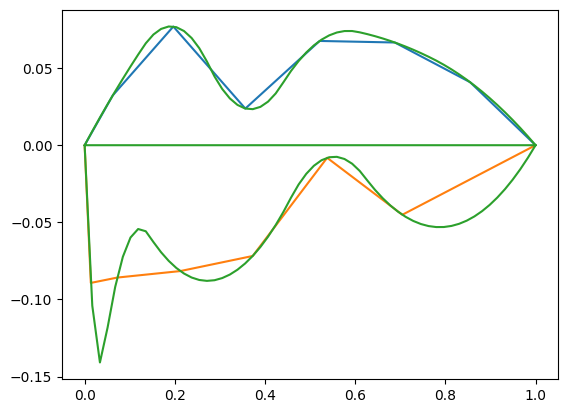

[[ 0.00000000e+00 -4.18824924e-19]
 [ 1.69491525e-02  9.08401998e-03]
 [ 3.38983051e-02  1.79367248e-02]
 [ 5.08474576e-02  2.65581144e-02]
 [ 6.77966102e-02  3.49481888e-02]
 [ 8.47457627e-02  4.31069480e-02]
 [ 1.01694915e-01  5.10343921e-02]
 [ 1.18644068e-01  5.87305210e-02]
 [ 1.35593220e-01  6.60799765e-02]
 [ 1.52542373e-01  7.17599959e-02]
 [ 1.69491525e-01  7.53953655e-02]
 [ 1.86440678e-01  7.69860854e-02]
 [ 2.03389831e-01  7.65321556e-02]
 [ 2.20338983e-01  7.40335761e-02]
 [ 2.37288136e-01  6.94903468e-02]
 [ 2.54237288e-01  6.29024678e-02]
 [ 2.71186441e-01  5.42699392e-02]
 [ 2.88135593e-01  4.45196778e-02]
 [ 3.05084746e-01  3.64793550e-02]
 [ 3.22033898e-01  3.03449364e-02]
 [ 3.38983051e-01  2.61164223e-02]
 [ 3.55932203e-01  2.37938124e-02]
 [ 3.72881356e-01  2.33771068e-02]
 [ 3.89830508e-01  2.48663056e-02]
 [ 4.06779661e-01  2.82614086e-02]
 [ 4.23728814e-01  3.35624160e-02]
 [ 4.40677966e-01  4.07511399e-02]
 [ 4.57627119e-01  4.81303698e-02]
 [ 4.74576271e-01  5

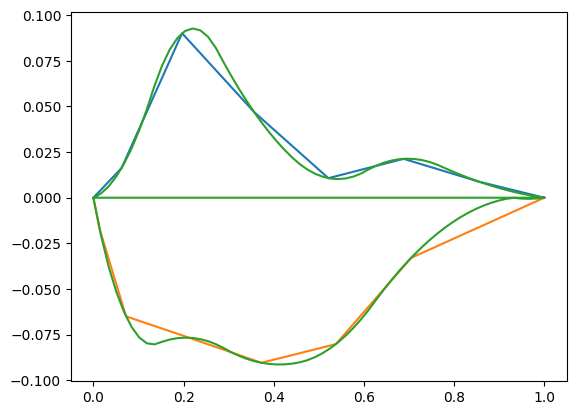

[[ 0.00000000e+00  0.00000000e+00]
 [ 1.69491525e-02  2.35552065e-03]
 [ 3.38983051e-02  6.23872228e-03]
 [ 5.08474576e-02  1.16496049e-02]
 [ 6.77966102e-02  1.85881685e-02]
 [ 8.47457627e-02  2.70544131e-02]
 [ 1.01694915e-01  3.70483386e-02]
 [ 1.18644068e-01  4.85699452e-02]
 [ 1.35593220e-01  6.13664285e-02]
 [ 1.52542373e-01  7.25389892e-02]
 [ 1.69491525e-01  8.12653570e-02]
 [ 1.86440678e-01  8.75455318e-02]
 [ 2.03389831e-01  9.13795138e-02]
 [ 2.20338983e-01  9.27673029e-02]
 [ 2.37288136e-01  9.17088990e-02]
 [ 2.54237288e-01  8.82043023e-02]
 [ 2.71186441e-01  8.22535126e-02]
 [ 2.88135593e-01  7.45262064e-02]
 [ 3.05084746e-01  6.70653114e-02]
 [ 3.22033898e-01  6.00124084e-02]
 [ 3.38983051e-01  5.33674974e-02]
 [ 3.55932203e-01  4.71305784e-02]
 [ 3.72881356e-01  4.13016515e-02]
 [ 3.89830508e-01  3.58807165e-02]
 [ 4.06779661e-01  3.08677735e-02]
 [ 4.23728814e-01  2.62628225e-02]
 [ 4.40677966e-01  2.20675001e-02]
 [ 4.57627119e-01  1.84345269e-02]
 [ 4.74576271e-01  1

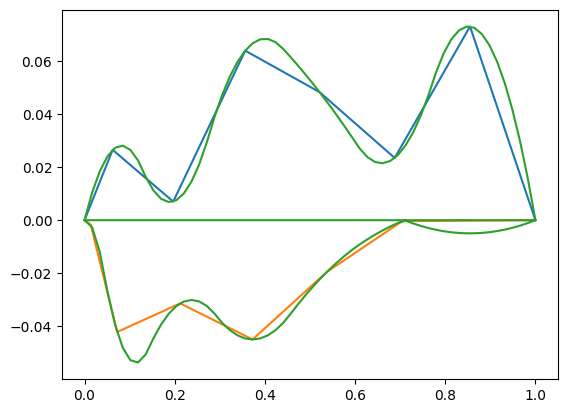

[[ 0.00000000e+00  1.04706231e-18]
 [ 1.69491525e-02  1.04091101e-02]
 [ 3.38983051e-02  1.84184789e-02]
 [ 5.08474576e-02  2.40281064e-02]
 [ 6.77966102e-02  2.72379927e-02]
 [ 8.47457627e-02  2.80481378e-02]
 [ 1.01694915e-01  2.64585416e-02]
 [ 1.18644068e-01  2.24692042e-02]
 [ 1.35593220e-01  1.63546918e-02]
 [ 1.52542373e-01  1.12633411e-02]
 [ 1.69491525e-01  8.08820583e-03]
 [ 1.86440678e-01  6.82928595e-03]
 [ 2.03389831e-01  7.48658147e-03]
 [ 2.20338983e-01  1.00600924e-02]
 [ 2.37288136e-01  1.45498187e-02]
 [ 2.54237288e-01  2.09557604e-02]
 [ 2.71186441e-01  2.92779175e-02]
 [ 2.88135593e-01  3.87485089e-02]
 [ 3.05084746e-01  4.70253263e-02]
 [ 3.22033898e-01  5.39460479e-02]
 [ 3.38983051e-01  5.95106739e-02]
 [ 3.55932203e-01  6.37192040e-02]
 [ 3.72881356e-01  6.65716385e-02]
 [ 3.89830508e-01  6.80679772e-02]
 [ 4.06779661e-01  6.82082202e-02]
 [ 4.23728814e-01  6.69923674e-02]
 [ 4.40677966e-01  6.44283219e-02]
 [ 4.57627119e-01  6.12535576e-02]
 [ 4.74576271e-01  5

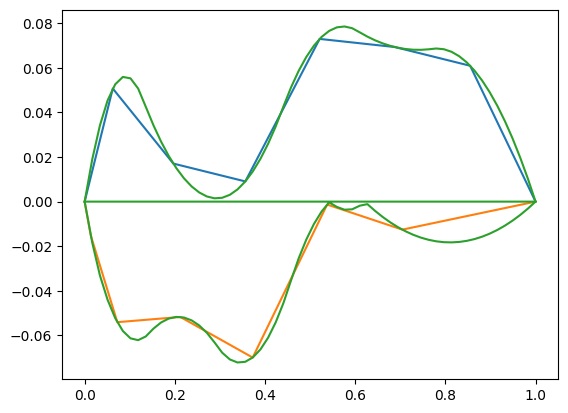

[[ 0.00000000e+00 -4.45001481e-19]
 [ 1.69491525e-02  1.90459732e-02]
 [ 3.38983051e-02  3.41574720e-02]
 [ 5.08474576e-02  4.53344962e-02]
 [ 6.77966102e-02  5.25770459e-02]
 [ 8.47457627e-02  5.58851211e-02]
 [ 1.01694915e-01  5.52587218e-02]
 [ 1.18644068e-01  5.06978480e-02]
 [ 1.35593220e-01  4.25116927e-02]
 [ 1.52542373e-01  3.42456441e-02]
 [ 1.69491525e-01  2.69053827e-02]
 [ 1.86440678e-01  2.04909087e-02]
 [ 2.03389831e-01  1.50022220e-02]
 [ 2.20338983e-01  1.04393226e-02]
 [ 2.37288136e-01  6.80221054e-03]
 [ 2.54237288e-01  4.09088581e-03]
 [ 2.71186441e-01  2.30534840e-03]
 [ 2.88135593e-01  1.48171120e-03]
 [ 3.05084746e-01  1.73014087e-03]
 [ 3.22033898e-01  3.05827226e-03]
 [ 3.38983051e-01  5.46610539e-03]
 [ 3.55932203e-01  8.95364024e-03]
 [ 3.72881356e-01  1.35208768e-02]
 [ 3.89830508e-01  1.91678151e-02]
 [ 4.06779661e-01  2.58944552e-02]
 [ 4.23728814e-01  3.37007970e-02]
 [ 4.40677966e-01  4.25723628e-02]
 [ 4.57627119e-01  5.11581530e-02]
 [ 4.74576271e-01  5

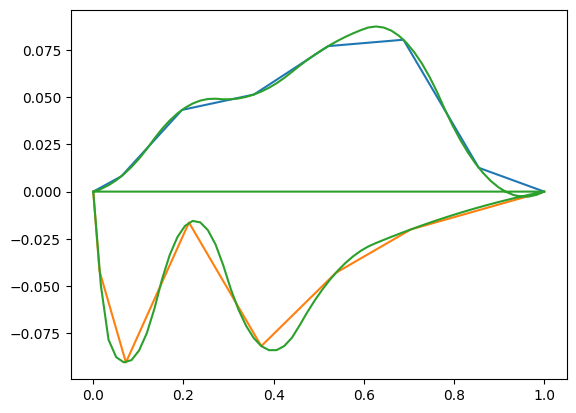

[[ 0.00000000e+00  4.18824924e-19]
 [ 1.69491525e-02  1.39184603e-03]
 [ 3.38983051e-02  3.39272292e-03]
 [ 5.08474576e-02  6.00263069e-03]
 [ 6.77966102e-02  9.22156933e-03]
 [ 8.47457627e-02  1.30495388e-02]
 [ 1.01694915e-01  1.74865392e-02]
 [ 1.18644068e-01  2.25325705e-02]
 [ 1.35593220e-01  2.81035373e-02]
 [ 1.52542373e-01  3.32351545e-02]
 [ 1.69491525e-01  3.76538940e-02]
 [ 1.86440678e-01  4.13597556e-02]
 [ 2.03389831e-01  4.43527396e-02]
 [ 2.20338983e-01  4.66328457e-02]
 [ 2.37288136e-01  4.82000741e-02]
 [ 2.54237288e-01  4.90544248e-02]
 [ 2.71186441e-01  4.91958977e-02]
 [ 2.88135593e-01  4.88848199e-02]
 [ 3.05084746e-01  4.89153499e-02]
 [ 3.22033898e-01  4.93425253e-02]
 [ 3.38983051e-01  5.01663460e-02]
 [ 3.55932203e-01  5.13868121e-02]
 [ 3.72881356e-01  5.30039236e-02]
 [ 3.89830508e-01  5.50176804e-02]
 [ 4.06779661e-01  5.74280826e-02]
 [ 4.23728814e-01  6.02351301e-02]
 [ 4.40677966e-01  6.34350071e-02]
 [ 4.57627119e-01  6.66716305e-02]
 [ 4.74576271e-01  6

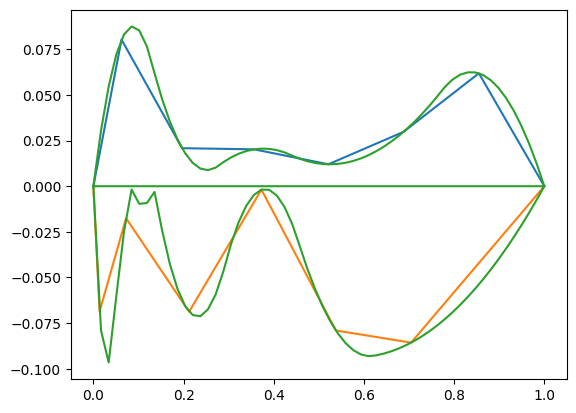

[[ 0.00000000e+00  1.66221142e-18]
 [ 1.69491525e-02  3.06308582e-02]
 [ 3.38983051e-02  5.47012127e-02]
 [ 5.08474576e-02  7.22110635e-02]
 [ 6.77966102e-02  8.31604107e-02]
 [ 8.47457627e-02  8.75492543e-02]
 [ 1.01694915e-01  8.53775942e-02]
 [ 1.18644068e-01  7.66454304e-02]
 [ 1.35593220e-01  6.19127672e-02]
 [ 1.52542373e-01  4.76009379e-02]
 [ 1.69491525e-01  3.55314109e-02]
 [ 1.86440678e-01  2.57041861e-02]
 [ 2.03389831e-01  1.81192634e-02]
 [ 2.20338983e-01  1.27766430e-02]
 [ 2.37288136e-01  9.67632483e-03]
 [ 2.54237288e-01  8.81830885e-03]
 [ 2.71186441e-01  1.02025951e-02]
 [ 2.88135593e-01  1.31758975e-02]
 [ 3.05084746e-01  1.57452889e-02]
 [ 3.22033898e-01  1.77726537e-02]
 [ 3.38983051e-01  1.92579919e-02]
 [ 3.55932203e-01  2.02013034e-02]
 [ 3.72881356e-01  2.06025884e-02]
 [ 3.89830508e-01  2.04618467e-02]
 [ 4.06779661e-01  1.97790784e-02]
 [ 4.23728814e-01  1.85542835e-02]
 [ 4.40677966e-01  1.67934665e-02]
 [ 4.57627119e-01  1.50569379e-02]
 [ 4.74576271e-01  1

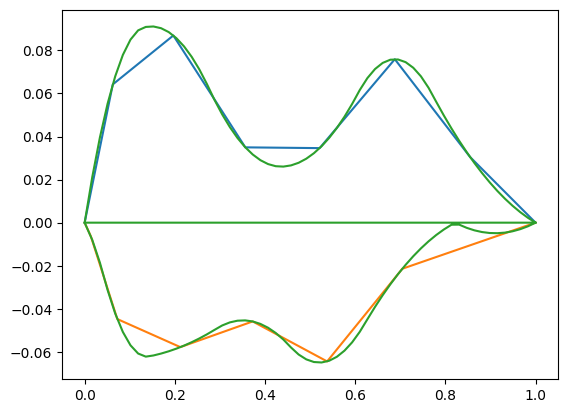

[[ 0.00000000e+00 -2.93177447e-18]
 [ 1.69491525e-02  2.12138664e-02]
 [ 3.38983051e-02  3.96079021e-02]
 [ 5.08474576e-02  5.51821073e-02]
 [ 6.77966102e-02  6.79364819e-02]
 [ 8.47457627e-02  7.78710259e-02]
 [ 1.01694915e-01  8.49857393e-02]
 [ 1.18644068e-01  8.92806221e-02]
 [ 1.35593220e-01  9.08710311e-02]
 [ 1.52542373e-01  9.10797138e-02]
 [ 1.69491525e-01  9.02818792e-02]
 [ 1.86440678e-01  8.84775273e-02]
 [ 2.03389831e-01  8.56666582e-02]
 [ 2.20338983e-01  8.18492718e-02]
 [ 2.37288136e-01  7.70253682e-02]
 [ 2.54237288e-01  7.11949473e-02]
 [ 2.71186441e-01  6.43580092e-02]
 [ 2.88135593e-01  5.69418091e-02]
 [ 3.05084746e-01  5.02497403e-02]
 [ 3.22033898e-01  4.43721318e-02]
 [ 3.38983051e-01  3.93089837e-02]
 [ 3.55932203e-01  3.50602957e-02]
 [ 3.72881356e-01  3.16260681e-02]
 [ 3.89830508e-01  2.90063008e-02]
 [ 4.06779661e-01  2.72009937e-02]
 [ 4.23728814e-01  2.62101469e-02]
 [ 4.40677966e-01  2.60328321e-02]
 [ 4.57627119e-01  2.65824246e-02]
 [ 4.74576271e-01  2

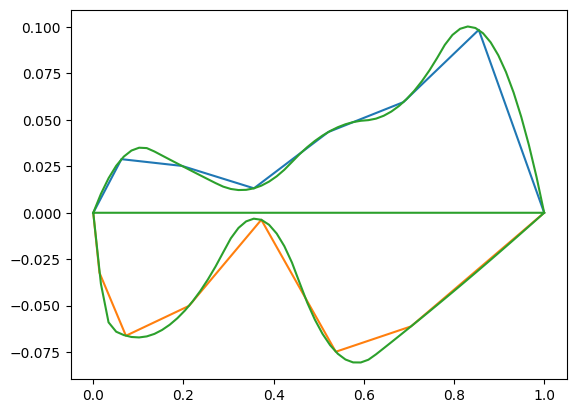

[[ 0.00000000e+00  1.67529969e-18]
 [ 1.69491525e-02  1.01571044e-02]
 [ 3.38983051e-02  1.85867480e-02]
 [ 5.08474576e-02  2.52889308e-02]
 [ 6.77966102e-02  3.02636526e-02]
 [ 8.47457627e-02  3.35109137e-02]
 [ 1.01694915e-01  3.50307139e-02]
 [ 1.18644068e-01  3.48230533e-02]
 [ 1.35593220e-01  3.29986453e-02]
 [ 1.52542373e-01  3.08269952e-02]
 [ 1.69491525e-01  2.86682096e-02]
 [ 1.86440678e-01  2.65222884e-02]
 [ 2.03389831e-01  2.43892317e-02]
 [ 2.20338983e-01  2.22690393e-02]
 [ 2.37288136e-01  2.01617114e-02]
 [ 2.54237288e-01  1.80672479e-02]
 [ 2.71186441e-01  1.59856488e-02]
 [ 2.88135593e-01  1.40744516e-02]
 [ 3.05084746e-01  1.28142432e-02]
 [ 3.22033898e-01  1.22383296e-02]
 [ 3.38983051e-01  1.23467109e-02]
 [ 3.55932203e-01  1.31393870e-02]
 [ 3.72881356e-01  1.46163580e-02]
 [ 3.89830508e-01  1.67776239e-02]
 [ 4.06779661e-01  1.96231845e-02]
 [ 4.23728814e-01  2.31530400e-02]
 [ 4.40677966e-01  2.73599749e-02]
 [ 4.57627119e-01  3.15706696e-02]
 [ 4.74576271e-01  3

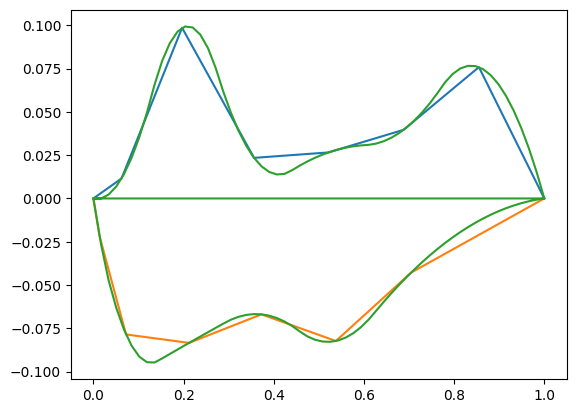

[[ 0.00000000e+00 -2.93177447e-18]
 [ 1.69491525e-02 -5.20137026e-05]
 [ 3.38983051e-02  2.27005756e-03]
 [ 5.08474576e-02  6.96621378e-03]
 [ 6.77966102e-02  1.40364550e-02]
 [ 8.47457627e-02  2.34807811e-02]
 [ 1.01694915e-01  3.52991922e-02]
 [ 1.18644068e-01  4.94916883e-02]
 [ 1.35593220e-01  6.56780844e-02]
 [ 1.52542373e-01  7.94989590e-02]
 [ 1.69491525e-01  8.97177236e-02]
 [ 1.86440678e-01  9.63343780e-02]
 [ 2.03389831e-01  9.93489223e-02]
 [ 2.20338983e-01  9.87613565e-02]
 [ 2.37288136e-01  9.45716806e-02]
 [ 2.54237288e-01  8.67798947e-02]
 [ 2.71186441e-01  7.53859986e-02]
 [ 2.88135593e-01  6.16556800e-02]
 [ 3.05084746e-01  4.94500702e-02]
 [ 3.22033898e-01  3.90367569e-02]
 [ 3.38983051e-01  3.04157399e-02]
 [ 3.55932203e-01  2.35870193e-02]
 [ 3.72881356e-01  1.85505951e-02]
 [ 3.89830508e-01  1.53064673e-02]
 [ 4.06779661e-01  1.38546359e-02]
 [ 4.23728814e-01  1.41951009e-02]
 [ 4.40677966e-01  1.63146068e-02]
 [ 4.57627119e-01  1.89762044e-02]
 [ 4.74576271e-01  2

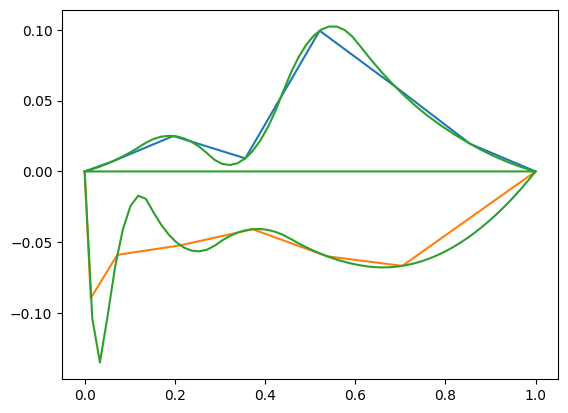

[[ 0.00000000e+00 -1.04706231e-19]
 [ 1.69491525e-02  1.57717055e-03]
 [ 3.38983051e-02  3.42813330e-03]
 [ 5.08474576e-02  5.55288826e-03]
 [ 6.77966102e-02  7.95143542e-03]
 [ 8.47457627e-02  1.06237748e-02]
 [ 1.01694915e-01  1.35699063e-02]
 [ 1.18644068e-01  1.67898301e-02]
 [ 1.35593220e-01  2.02012967e-02]
 [ 1.52542373e-01  2.28611863e-02]
 [ 1.69491525e-01  2.45019748e-02]
 [ 1.86440678e-01  2.51236621e-02]
 [ 2.03389831e-01  2.47262482e-02]
 [ 2.20338983e-01  2.33097331e-02]
 [ 2.37288136e-01  2.08741168e-02]
 [ 2.54237288e-01  1.74193994e-02]
 [ 2.71186441e-01  1.29455808e-02]
 [ 2.88135593e-01  8.17594894e-03]
 [ 3.05084746e-01  5.31698050e-03]
 [ 3.22033898e-01  4.52159061e-03]
 [ 3.38983051e-01  5.78977928e-03]
 [ 3.55932203e-01  9.12154649e-03]
 [ 3.72881356e-01  1.45168922e-02]
 [ 3.89830508e-01  2.19758166e-02]
 [ 4.06779661e-01  3.14983194e-02]
 [ 4.23728814e-01  4.30844008e-02]
 [ 4.40677966e-01  5.67066113e-02]
 [ 4.57627119e-01  6.98034803e-02]
 [ 4.74576271e-01  8

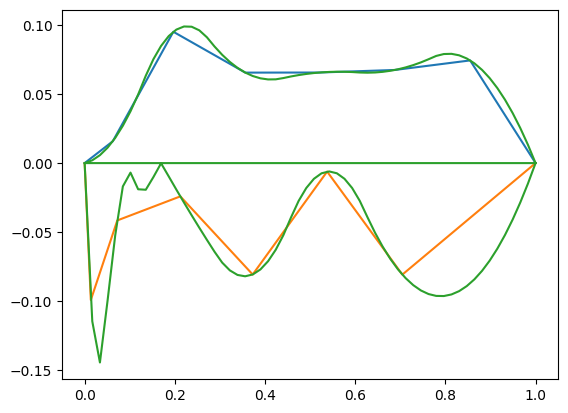

[[ 0.00000000e+00 -8.37649847e-19]
 [ 1.69491525e-02  2.03170495e-03]
 [ 3.38983051e-02  5.75398526e-03]
 [ 5.08474576e-02  1.11668409e-02]
 [ 6.77966102e-02  1.82702719e-02]
 [ 8.47457627e-02  2.70642783e-02]
 [ 1.01694915e-01  3.75488600e-02]
 [ 1.18644068e-01  4.97240171e-02]
 [ 1.35593220e-01  6.33270753e-02]
 [ 1.52542373e-01  7.53460593e-02]
 [ 1.69491525e-01  8.49265957e-02]
 [ 1.86440678e-01  9.20686843e-02]
 [ 2.03389831e-01  9.67723253e-02]
 [ 2.20338983e-01  9.90375186e-02]
 [ 2.37288136e-01  9.88642642e-02]
 [ 2.54237288e-01  9.62525621e-02]
 [ 2.71186441e-01  9.12024123e-02]
 [ 2.88135593e-01  8.44895644e-02]
 [ 3.05084746e-01  7.84805351e-02]
 [ 3.22033898e-01  7.33393309e-02]
 [ 3.38983051e-01  6.90659518e-02]
 [ 3.55932203e-01  6.56603978e-02]
 [ 3.72881356e-01  6.31226688e-02]
 [ 3.89830508e-01  6.14527649e-02]
 [ 4.06779661e-01  6.06506861e-02]
 [ 4.23728814e-01  6.07164323e-02]
 [ 4.40677966e-01  6.16433247e-02]
 [ 4.57627119e-01  6.28081134e-02]
 [ 4.74576271e-01  6

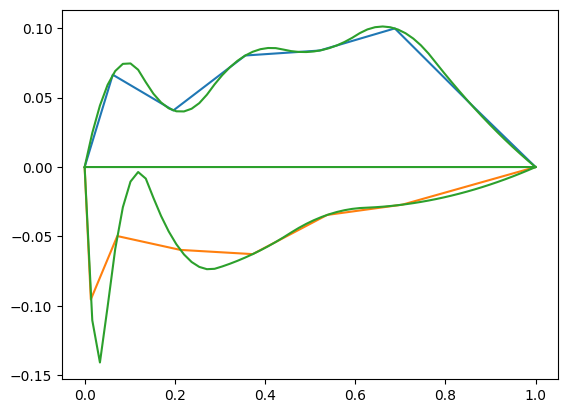

[[ 0.00000000e+00 -1.78000593e-18]
 [ 1.69491525e-02  2.45818938e-02]
 [ 3.38983051e-02  4.43089122e-02]
 [ 5.08474576e-02  5.91810554e-02]
 [ 6.77966102e-02  6.91983232e-02]
 [ 8.47457627e-02  7.43607157e-02]
 [ 1.01694915e-01  7.46682329e-02]
 [ 1.18644068e-01  7.01208748e-02]
 [ 1.35593220e-01  6.11584914e-02]
 [ 1.52542373e-01  5.28246601e-02]
 [ 1.69491525e-01  4.65500363e-02]
 [ 1.86440678e-01  4.23346200e-02]
 [ 2.03389831e-01  4.01784112e-02]
 [ 2.20338983e-01  4.00814099e-02]
 [ 2.37288136e-01  4.20436160e-02]
 [ 2.54237288e-01  4.60650297e-02]
 [ 2.71186441e-01  5.21456508e-02]
 [ 2.88135593e-01  5.95773530e-02]
 [ 3.05084746e-01  6.61999116e-02]
 [ 3.22033898e-01  7.18636169e-02]
 [ 3.38983051e-01  7.65684689e-02]
 [ 3.55932203e-01  8.03144676e-02]
 [ 3.72881356e-01  8.31016129e-02]
 [ 3.89830508e-01  8.49299050e-02]
 [ 4.06779661e-01  8.57993437e-02]
 [ 4.23728814e-01  8.57099291e-02]
 [ 4.40677966e-01  8.46711197e-02]
 [ 4.57627119e-01  8.35655451e-02]
 [ 4.74576271e-01  8

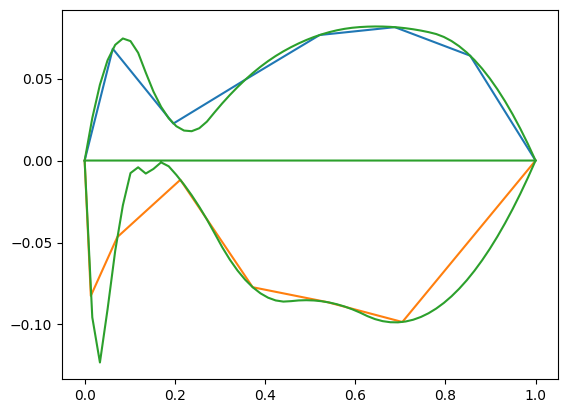

[[ 0.00000000e+00  2.98494560e-18]
 [ 1.69491525e-02  2.58960090e-02]
 [ 3.38983051e-02  4.62901892e-02]
 [ 5.08474576e-02  6.11825405e-02]
 [ 6.77966102e-02  7.05730629e-02]
 [ 8.47457627e-02  7.44617565e-02]
 [ 1.01694915e-01  7.28486213e-02]
 [ 1.18644068e-01  6.57336572e-02]
 [ 1.35593220e-01  5.36081065e-02]
 [ 1.52542373e-01  4.21048384e-02]
 [ 1.69491525e-01  3.28216661e-02]
 [ 1.86440678e-01  2.57585898e-02]
 [ 2.03389831e-01  2.09156093e-02]
 [ 2.20338983e-01  1.82927247e-02]
 [ 2.37288136e-01  1.78899360e-02]
 [ 2.54237288e-01  1.97072431e-02]
 [ 2.71186441e-01  2.37446462e-02]
 [ 2.88135593e-01  2.94037104e-02]
 [ 3.05084746e-01  3.48588390e-02]
 [ 3.22033898e-01  3.99835129e-02]
 [ 3.38983051e-01  4.47777321e-02]
 [ 3.55932203e-01  4.92414965e-02]
 [ 3.72881356e-01  5.33748062e-02]
 [ 3.89830508e-01  5.71776611e-02]
 [ 4.06779661e-01  6.06500614e-02]
 [ 4.23728814e-01  6.37920069e-02]
 [ 4.40677966e-01  6.66041098e-02]
 [ 4.57627119e-01  6.91434856e-02]
 [ 4.74576271e-01  7

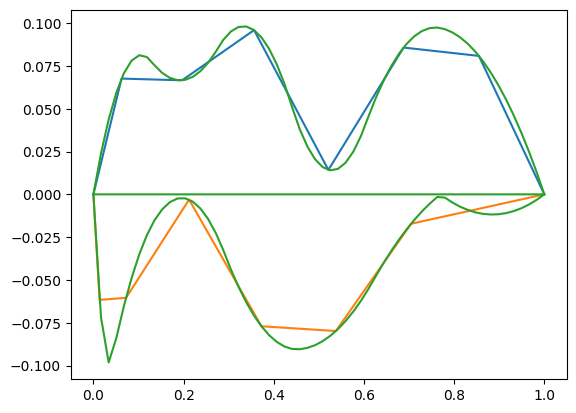

[[ 0.00000000e+00 -2.09412462e-19]
 [ 1.69491525e-02  2.39413974e-02]
 [ 3.38983051e-02  4.37213928e-02]
 [ 5.08474576e-02  5.93399862e-02]
 [ 6.77966102e-02  7.07971776e-02]
 [ 8.47457627e-02  7.80929670e-02]
 [ 1.01694915e-01  8.12273545e-02]
 [ 1.18644068e-01  8.02003399e-02]
 [ 1.35593220e-01  7.53753831e-02]
 [ 1.52542373e-01  7.09201247e-02]
 [ 1.69491525e-01  6.80167530e-02]
 [ 1.86440678e-01  6.66652679e-02]
 [ 2.03389831e-01  6.68656696e-02]
 [ 2.20338983e-01  6.86179580e-02]
 [ 2.37288136e-01  7.19221330e-02]
 [ 2.54237288e-01  7.67781948e-02]
 [ 2.71186441e-01  8.31861432e-02]
 [ 2.88135593e-01  9.02368456e-02]
 [ 3.05084746e-01  9.51568836e-02]
 [ 3.22033898e-01  9.77540514e-02]
 [ 3.38983051e-01  9.80283490e-02]
 [ 3.55932203e-01  9.59797764e-02]
 [ 3.72881356e-01  9.16083336e-02]
 [ 3.89830508e-01  8.49140206e-02]
 [ 4.06779661e-01  7.58968374e-02]
 [ 4.23728814e-01  6.45567840e-02]
 [ 4.40677966e-01  5.09264941e-02]
 [ 4.57627119e-01  3.80512134e-02]
 [ 4.74576271e-01  2

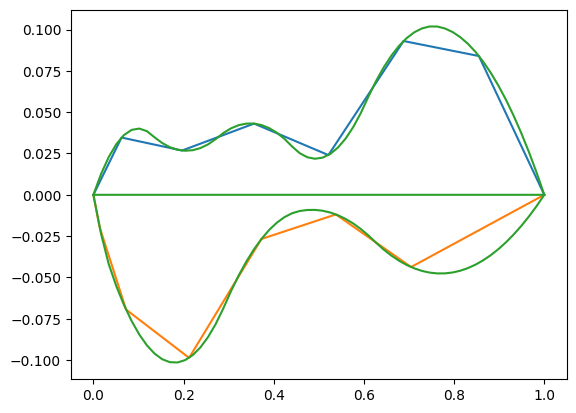

[[ 0.00000000e+00  1.36118100e-18]
 [ 1.69491525e-02  1.25706464e-02]
 [ 3.38983051e-02  2.27845916e-02]
 [ 5.08474576e-02  3.06418354e-02]
 [ 6.77966102e-02  3.61423779e-02]
 [ 8.47457627e-02  3.92862190e-02]
 [ 1.01694915e-01  4.00733589e-02]
 [ 1.18644068e-01  3.85037974e-02]
 [ 1.35593220e-01  3.47877099e-02]
 [ 1.52542373e-01  3.13350892e-02]
 [ 1.69491525e-01  2.88295510e-02]
 [ 1.86440678e-01  2.72710954e-02]
 [ 2.03389831e-01  2.66597224e-02]
 [ 2.20338983e-01  2.69954319e-02]
 [ 2.37288136e-01  2.82782240e-02]
 [ 2.54237288e-01  3.05080987e-02]
 [ 2.71186441e-01  3.36850559e-02]
 [ 2.88135593e-01  3.73671776e-02]
 [ 3.05084746e-01  4.02063400e-02]
 [ 3.22033898e-01  4.21091142e-02]
 [ 3.38983051e-01  4.30755001e-02]
 [ 3.55932203e-01  4.31054978e-02]
 [ 3.72881356e-01  4.21991073e-02]
 [ 3.89830508e-01  4.03563286e-02]
 [ 4.06779661e-01  3.75771617e-02]
 [ 4.23728814e-01  3.38616065e-02]
 [ 4.40677966e-01  2.92258356e-02]
 [ 4.57627119e-01  2.51790002e-02]
 [ 4.74576271e-01  2

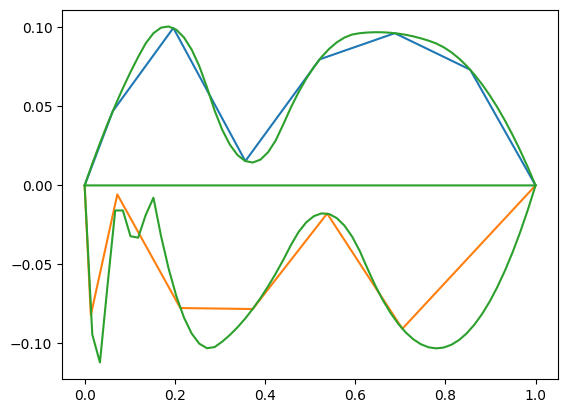

[[ 0.00000000e+00  8.37649847e-19]
 [ 1.69491525e-02  1.36824398e-02]
 [ 3.38983051e-02  2.66723336e-02]
 [ 5.08474576e-02  3.89696815e-02]
 [ 6.77966102e-02  5.05744835e-02]
 [ 8.47457627e-02  6.14867396e-02]
 [ 1.01694915e-01  7.17064498e-02]
 [ 1.18644068e-01  8.12336140e-02]
 [ 1.35593220e-01  8.99340983e-02]
 [ 1.52542373e-01  9.62698430e-02]
 [ 1.69491525e-01  9.98045641e-02]
 [ 1.86440678e-01  1.00538262e-01]
 [ 2.03389831e-01  9.84709352e-02]
 [ 2.20338983e-01  9.36025853e-02]
 [ 2.37288136e-01  8.59332116e-02]
 [ 2.54237288e-01  7.54628143e-02]
 [ 2.71186441e-01  6.21913933e-02]
 [ 2.88135593e-01  4.74362827e-02]
 [ 3.05084746e-01  3.52161676e-02]
 [ 3.22033898e-01  2.58095546e-02]
 [ 3.38983051e-01  1.92164436e-02]
 [ 3.55932203e-01  1.54368346e-02]
 [ 3.72881356e-01  1.44707277e-02]
 [ 3.89830508e-01  1.63181228e-02]
 [ 4.06779661e-01  2.09790199e-02]
 [ 4.23728814e-01  2.84534190e-02]
 [ 4.40677966e-01  3.87161364e-02]
 [ 4.57627119e-01  4.94171184e-02]
 [ 4.74576271e-01  5

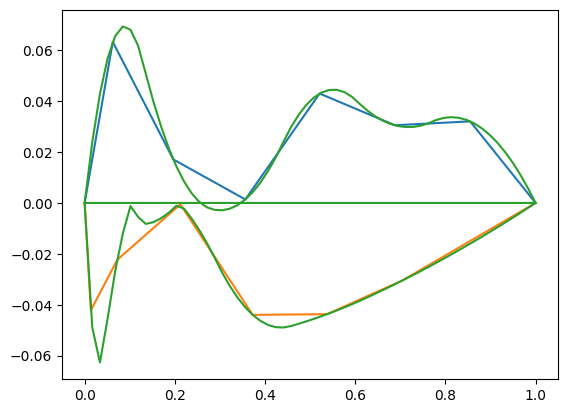

[[ 0.00000000e+00  2.57839094e-18]
 [ 1.69491525e-02  2.39677520e-02]
 [ 3.38983051e-02  4.28879124e-02]
 [ 5.08474576e-02  5.67604811e-02]
 [ 6.77966102e-02  6.55854583e-02]
 [ 8.47457627e-02  6.93628438e-02]
 [ 1.01694915e-01  6.80926378e-02]
 [ 1.18644068e-01  6.17748401e-02]
 [ 1.35593220e-01  5.08111817e-02]
 [ 1.52542373e-01  3.98081427e-02]
 [ 1.69491525e-01  3.00723921e-02]
 [ 1.86440678e-01  2.16039298e-02]
 [ 2.03389831e-01  1.44027560e-02]
 [ 2.20338983e-01  8.46887054e-03]
 [ 2.37288136e-01  3.80227347e-03]
 [ 2.54237288e-01  4.02964787e-04]
 [ 2.71186441e-01 -1.72905551e-03]
 [ 2.88135593e-01 -2.70726338e-03]
 [ 3.05084746e-01 -2.87783085e-03]
 [ 3.22033898e-01 -2.26474865e-03]
 [ 3.38983051e-01 -8.68016761e-04]
 [ 3.55932203e-01  1.31236481e-03]
 [ 3.72881356e-01  4.27639606e-03]
 [ 3.89830508e-01  8.02407699e-03]
 [ 4.06779661e-01  1.25554076e-02]
 [ 4.23728814e-01  1.78703879e-02]
 [ 4.40677966e-01  2.39577892e-02]
 [ 4.57627119e-01  2.97698018e-02]
 [ 4.74576271e-01  3

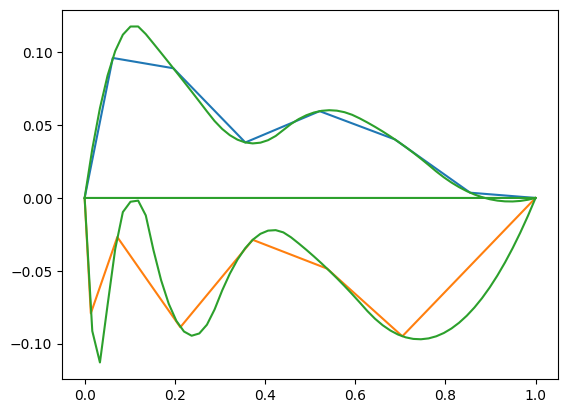

[[ 0.00000000e+00  0.00000000e+00]
 [ 1.69491525e-02  3.36002796e-02]
 [ 3.38983051e-02  6.16040886e-02]
 [ 5.08474576e-02  8.40114269e-02]
 [ 6.77966102e-02  1.00822295e-01]
 [ 8.47457627e-02  1.12036692e-01]
 [ 1.01694915e-01  1.17654618e-01]
 [ 1.18644068e-01  1.17676074e-01]
 [ 1.35593220e-01  1.12453371e-01]
 [ 1.52542373e-01  1.06026322e-01]
 [ 1.69491525e-01  9.95408554e-02]
 [ 1.86440678e-01  9.29969720e-02]
 [ 2.03389831e-01  8.63946714e-02]
 [ 2.20338983e-01  7.97339537e-02]
 [ 2.37288136e-01  7.30148187e-02]
 [ 2.54237288e-01  6.62372666e-02]
 [ 2.71186441e-01  5.94012973e-02]
 [ 2.88135593e-01  5.28011061e-02]
 [ 3.05084746e-01  4.73341710e-02]
 [ 3.22033898e-01  4.30626898e-02]
 [ 3.38983051e-01  3.99866626e-02]
 [ 3.55932203e-01  3.81060892e-02]
 [ 3.72881356e-01  3.74209697e-02]
 [ 3.89830508e-01  3.79313042e-02]
 [ 4.06779661e-01  3.96370925e-02]
 [ 4.23728814e-01  4.25383348e-02]
 [ 4.40677966e-01  4.66225964e-02]
 [ 4.57627119e-01  5.07295307e-02]
 [ 4.74576271e-01  5

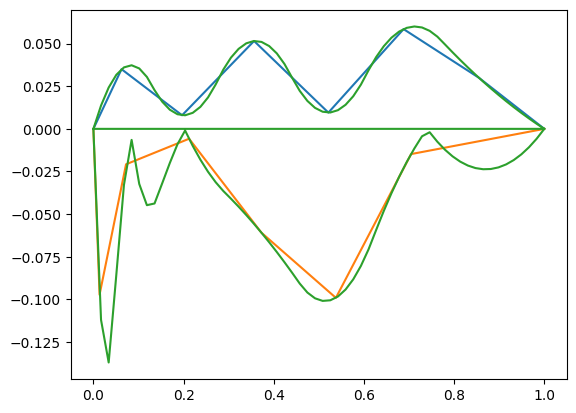

[[ 0.00000000e+00  8.37649847e-19]
 [ 1.69491525e-02  1.36753524e-02]
 [ 3.38983051e-02  2.42431448e-02]
 [ 5.08474576e-02  3.17033773e-02]
 [ 6.77966102e-02  3.60560499e-02]
 [ 8.47457627e-02  3.73011626e-02]
 [ 1.01694915e-01  3.54387153e-02]
 [ 1.18644068e-01  3.04687081e-02]
 [ 1.35593220e-01  2.27193338e-02]
 [ 1.52542373e-01  1.59538436e-02]
 [ 1.69491525e-01  1.12397169e-02]
 [ 1.86440678e-01  8.57695366e-03]
 [ 2.03389831e-01  7.96555400e-03]
 [ 2.20338983e-01  9.40551788e-03]
 [ 2.37288136e-01  1.28968453e-02]
 [ 2.54237288e-01  1.84395362e-02]
 [ 2.71186441e-01  2.60335907e-02]
 [ 2.88135593e-01  3.47543595e-02]
 [ 3.05084746e-01  4.17810894e-02]
 [ 3.22033898e-01  4.69182941e-02]
 [ 3.38983051e-01  5.01659736e-02]
 [ 3.55932203e-01  5.15241280e-02]
 [ 3.72881356e-01  5.09927572e-02]
 [ 3.89830508e-01  4.85718612e-02]
 [ 4.06779661e-01  4.42614401e-02]
 [ 4.23728814e-01  3.80614938e-02]
 [ 4.40677966e-01  2.99958563e-02]
 [ 4.57627119e-01  2.22886179e-02]
 [ 4.74576271e-01  1

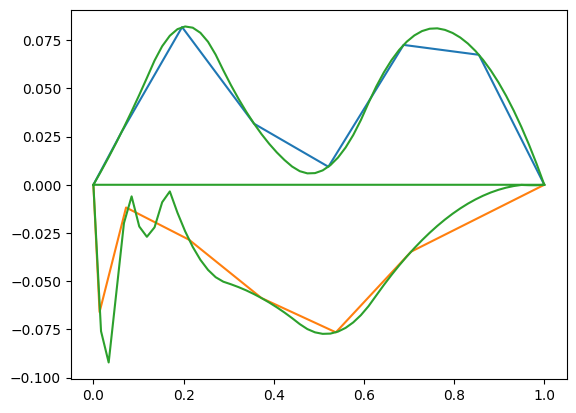

[[ 0.00000000e+00 -1.67529969e-18]
 [ 1.69491525e-02  7.00589208e-03]
 [ 3.38983051e-02  1.43167289e-02]
 [ 5.08474576e-02  2.19325105e-02]
 [ 6.77966102e-02  2.98532368e-02]
 [ 8.47457627e-02  3.80789079e-02]
 [ 1.01694915e-01  4.66095237e-02]
 [ 1.18644068e-01  5.54450843e-02]
 [ 1.35593220e-01  6.44376671e-02]
 [ 1.52542373e-01  7.18911056e-02]
 [ 1.69491525e-01  7.73242673e-02]
 [ 1.86440678e-01  8.07371522e-02]
 [ 2.03389831e-01  8.21297602e-02]
 [ 2.20338983e-01  8.15020914e-02]
 [ 2.37288136e-01  7.88541457e-02]
 [ 2.54237288e-01  7.41859232e-02]
 [ 2.71186441e-01  6.74974238e-02]
 [ 2.88135593e-01  5.93888010e-02]
 [ 3.05084746e-01  5.16908940e-02]
 [ 3.22033898e-01  4.45305855e-02]
 [ 3.38983051e-01  3.79078754e-02]
 [ 3.55932203e-01  3.18227636e-02]
 [ 3.72881356e-01  2.62752503e-02]
 [ 3.89830508e-01  2.12653354e-02]
 [ 4.06779661e-01  1.67930189e-02]
 [ 4.23728814e-01  1.28583008e-02]
 [ 4.40677966e-01  9.46590781e-03]
 [ 4.57627119e-01  7.05691773e-03]
 [ 4.74576271e-01  5

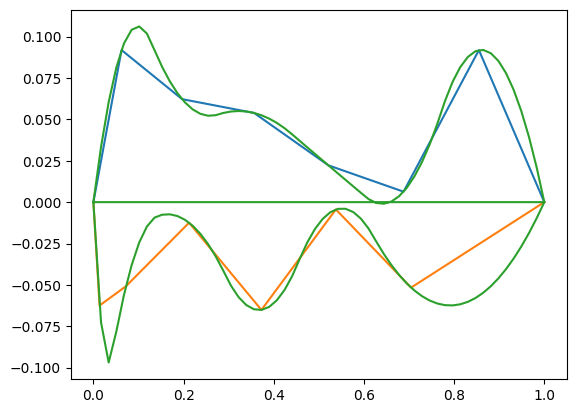

[[ 0.00000000e+00 -1.46588723e-18]
 [ 1.69491525e-02  3.33808467e-02]
 [ 3.38983051e-02  6.04864430e-02]
 [ 5.08474576e-02  8.13167888e-02]
 [ 6.77966102e-02  9.58718842e-02]
 [ 8.47457627e-02  1.04151729e-01]
 [ 1.01694915e-01  1.06156324e-01]
 [ 1.18644068e-01  1.01885668e-01]
 [ 1.35593220e-01  9.18343813e-02]
 [ 1.52542373e-01  8.16740592e-02]
 [ 1.69491525e-01  7.30135003e-02]
 [ 1.86440678e-01  6.58527044e-02]
 [ 2.03389831e-01  6.01916716e-02]
 [ 2.20338983e-01  5.60304020e-02]
 [ 2.37288136e-01  5.33688954e-02]
 [ 2.54237288e-01  5.22071519e-02]
 [ 2.71186441e-01  5.25451716e-02]
 [ 2.88135593e-01  5.38955160e-02]
 [ 3.05084746e-01  5.47711967e-02]
 [ 3.22033898e-01  5.50691610e-02]
 [ 3.38983051e-01  5.47894090e-02]
 [ 3.55932203e-01  5.39319405e-02]
 [ 3.72881356e-01  5.24967557e-02]
 [ 3.89830508e-01  5.04838545e-02]
 [ 4.06779661e-01  4.78932369e-02]
 [ 4.23728814e-01  4.47249029e-02]
 [ 4.40677966e-01  4.09826302e-02]
 [ 4.57627119e-01  3.70189374e-02]
 [ 4.74576271e-01  3

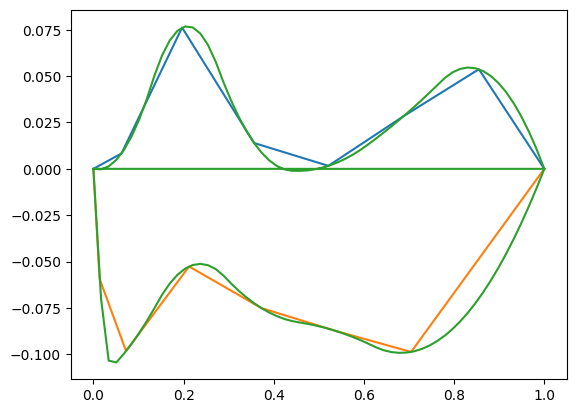

[[ 0.00000000e+00  4.18824924e-19]
 [ 1.69491525e-02 -2.78161493e-04]
 [ 3.38983051e-02  1.33668738e-03]
 [ 5.08474576e-02  4.84454663e-03]
 [ 6.77966102e-02  1.02454162e-02]
 [ 8.47457627e-02  1.75392962e-02]
 [ 1.01694915e-01  2.67261866e-02]
 [ 1.18644068e-01  3.78060873e-02]
 [ 1.35593220e-01  5.04785344e-02]
 [ 1.52542373e-01  6.12982335e-02]
 [ 1.69491525e-01  6.92878962e-02]
 [ 1.86440678e-01  7.44475225e-02]
 [ 2.03389831e-01  7.67771125e-02]
 [ 2.20338983e-01  7.62766660e-02]
 [ 2.37288136e-01  7.29461831e-02]
 [ 2.54237288e-01  6.67856638e-02]
 [ 2.71186441e-01  5.77951082e-02]
 [ 2.88135593e-01  4.69087183e-02]
 [ 3.05084746e-01  3.69763898e-02]
 [ 3.22033898e-01  2.81956286e-02]
 [ 3.38983051e-01  2.05664347e-02]
 [ 3.55932203e-01  1.40888081e-02]
 [ 3.72881356e-01  8.76274883e-03]
 [ 3.89830508e-01  4.58825687e-03]
 [ 4.06779661e-01  1.56533222e-03]
 [ 4.23728814e-01 -3.06025111e-04]
 [ 4.40677966e-01 -1.03107324e-03]
 [ 4.57627119e-01 -1.10047686e-03]
 [ 4.74576271e-01 -8

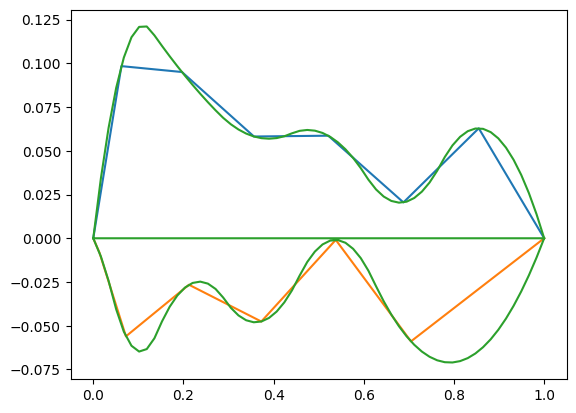

[[ 0.00000000e+00  4.18824924e-19]
 [ 1.69491525e-02  3.43613519e-02]
 [ 3.38983051e-02  6.30354208e-02]
 [ 5.08474576e-02  8.60222068e-02]
 [ 6.77966102e-02  1.03321710e-01]
 [ 8.47457627e-02  1.14933930e-01]
 [ 1.01694915e-01  1.20858867e-01]
 [ 1.18644068e-01  1.21096521e-01]
 [ 1.35593220e-01  1.16021943e-01]
 [ 1.52542373e-01  1.09935693e-01]
 [ 1.69491525e-01  1.04057664e-01]
 [ 1.86440678e-01  9.83878533e-02]
 [ 2.03389831e-01  9.29262628e-02]
 [ 2.20338983e-01  8.76728920e-02]
 [ 2.37288136e-01  8.26277409e-02]
 [ 2.54237288e-01  7.77908095e-02]
 [ 2.71186441e-01  7.31620977e-02]
 [ 2.88135593e-01  6.88501633e-02]
 [ 3.05084746e-01  6.51861740e-02]
 [ 3.22033898e-01  6.21930809e-02]
 [ 3.38983051e-01  5.98708838e-02]
 [ 3.55932203e-01  5.82195829e-02]
 [ 3.72881356e-01  5.72391780e-02]
 [ 3.89830508e-01  5.69296693e-02]
 [ 4.06779661e-01  5.72910566e-02]
 [ 4.23728814e-01  5.83233400e-02]
 [ 4.40677966e-01  6.00163792e-02]
 [ 4.57627119e-01  6.14239224e-02]
 [ 4.74576271e-01  6

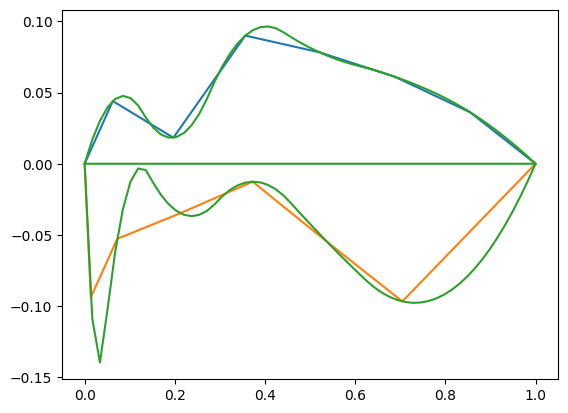

[[ 0.00000000e+00  5.49707712e-19]
 [ 1.69491525e-02  1.68836874e-02]
 [ 3.38983051e-02  3.00878369e-02]
 [ 5.08474576e-02  3.96124485e-02]
 [ 6.77966102e-02  4.54575223e-02]
 [ 8.47457627e-02  4.76230582e-02]
 [ 1.01694915e-01  4.61090562e-02]
 [ 1.18644068e-01  4.09155164e-02]
 [ 1.35593220e-01  3.24377363e-02]
 [ 1.52542373e-01  2.52084278e-02]
 [ 1.69491525e-01  2.05133349e-02]
 [ 1.86440678e-01  1.83524576e-02]
 [ 2.03389831e-01  1.87257959e-02]
 [ 2.20338983e-01  2.16333497e-02]
 [ 2.37288136e-01  2.70751192e-02]
 [ 2.54237288e-01  3.50511043e-02]
 [ 2.71186441e-01  4.55613049e-02]
 [ 2.88135593e-01  5.76163582e-02]
 [ 3.05084746e-01  6.81980938e-02]
 [ 3.22033898e-01  7.70973440e-02]
 [ 3.38983051e-01  8.43141086e-02]
 [ 3.55932203e-01  8.98483878e-02]
 [ 3.72881356e-01  9.37001815e-02]
 [ 3.89830508e-01  9.58694898e-02]
 [ 4.06779661e-01  9.63563125e-02]
 [ 4.23728814e-01  9.51606498e-02]
 [ 4.40677966e-01  9.22947778e-02]
 [ 4.57627119e-01  8.89042627e-02]
 [ 4.74576271e-01  8

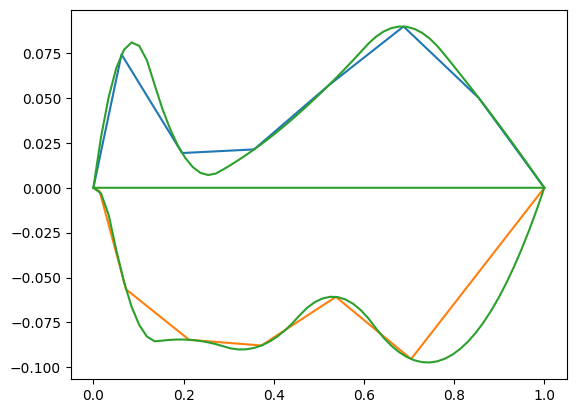

[[ 0.00000000e+00 -4.77722179e-19]
 [ 1.69491525e-02  2.82978848e-02]
 [ 3.38983051e-02  5.05479974e-02]
 [ 5.08474576e-02  6.67503380e-02]
 [ 6.77966102e-02  7.69049065e-02]
 [ 8.47457627e-02  8.10117029e-02]
 [ 1.01694915e-01  7.90707271e-02]
 [ 1.18644068e-01  7.10819793e-02]
 [ 1.35593220e-01  5.75571743e-02]
 [ 1.52542373e-01  4.43639338e-02]
 [ 1.69491525e-01  3.31666605e-02]
 [ 1.86440678e-01  2.39653546e-02]
 [ 2.03389831e-01  1.67600159e-02]
 [ 2.20338983e-01  1.15506446e-02]
 [ 2.37288136e-01  8.33724063e-03]
 [ 2.54237288e-01  7.11980396e-03]
 [ 2.71186441e-01  7.89833461e-03]
 [ 2.88135593e-01  1.02361668e-02]
 [ 3.05084746e-01  1.28011992e-02]
 [ 3.22033898e-01  1.55011133e-02]
 [ 3.38983051e-01  1.83359093e-02]
 [ 3.55932203e-01  2.13055870e-02]
 [ 3.72881356e-01  2.44101466e-02]
 [ 3.89830508e-01  2.76495879e-02]
 [ 4.06779661e-01  3.10239109e-02]
 [ 4.23728814e-01  3.45331158e-02]
 [ 4.40677966e-01  3.81770045e-02]
 [ 4.57627119e-01  4.19371065e-02]
 [ 4.74576271e-01  4

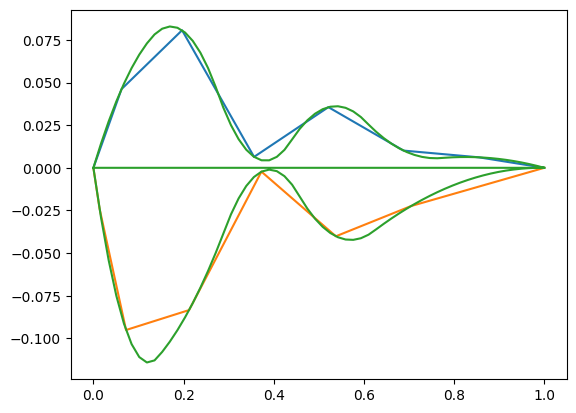

[[ 0.00000000e+00  8.37649847e-19]
 [ 1.69491525e-02  1.42461980e-02]
 [ 3.38983051e-02  2.72162307e-02]
 [ 5.08474576e-02  3.89100982e-02]
 [ 6.77966102e-02  4.93278006e-02]
 [ 8.47457627e-02  5.84693377e-02]
 [ 1.01694915e-01  6.63347096e-02]
 [ 1.18644068e-01  7.29239163e-02]
 [ 1.35593220e-01  7.81871494e-02]
 [ 1.52542373e-01  8.15532761e-02]
 [ 1.69491525e-01  8.28602896e-02]
 [ 1.86440678e-01  8.21081900e-02]
 [ 2.03389831e-01  7.92969771e-02]
 [ 2.20338983e-01  7.44266511e-02]
 [ 2.37288136e-01  6.74972119e-02]
 [ 2.54237288e-01  5.85086595e-02]
 [ 2.71186441e-01  4.74609939e-02]
 [ 2.88135593e-01  3.53194181e-02]
 [ 3.05084746e-01  2.50283993e-02]
 [ 3.22033898e-01  1.67919975e-02]
 [ 3.38983051e-01  1.06102127e-02]
 [ 3.55932203e-01  6.48304502e-03]
 [ 3.72881356e-01  4.41049433e-03]
 [ 3.89830508e-01  4.39256066e-03]
 [ 4.06779661e-01  6.42924402e-03]
 [ 4.23728814e-01  1.05205444e-02]
 [ 4.40677966e-01  1.66455906e-02]
 [ 4.57627119e-01  2.28567638e-02]
 [ 4.74576271e-01  2

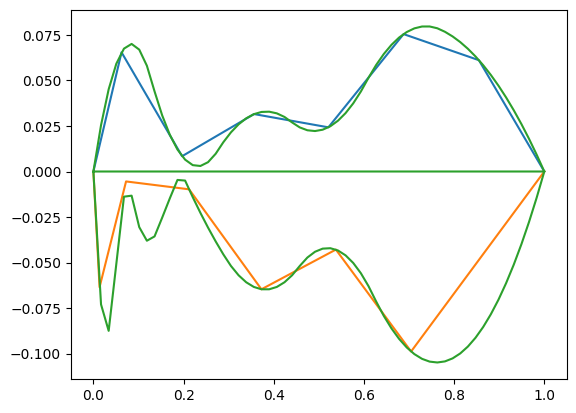

[[ 0.00000000e+00 -5.23531155e-19]
 [ 1.69491525e-02  2.54430244e-02]
 [ 3.38983051e-02  4.51706001e-02]
 [ 5.08474576e-02  5.91827269e-02]
 [ 6.77966102e-02  6.74794048e-02]
 [ 8.47457627e-02  7.00606340e-02]
 [ 1.01694915e-01  6.69264143e-02]
 [ 1.18644068e-01  5.80767458e-02]
 [ 1.35593220e-01  4.40372601e-02]
 [ 1.52542373e-01  3.08351554e-02]
 [ 1.69491525e-01  2.01801000e-02]
 [ 1.86440678e-01  1.20720939e-02]
 [ 2.03389831e-01  6.51113705e-03]
 [ 2.20338983e-01  3.49722946e-03]
 [ 2.37288136e-01  3.03037114e-03]
 [ 2.54237288e-01  5.11056210e-03]
 [ 2.71186441e-01  9.73780233e-03]
 [ 2.88135593e-01  1.60658176e-02]
 [ 3.05084746e-01  2.15129471e-02]
 [ 3.22033898e-01  2.59002742e-02]
 [ 3.38983051e-01  2.92277991e-02]
 [ 3.55932203e-01  3.14955216e-02]
 [ 3.72881356e-01  3.27034418e-02]
 [ 3.89830508e-01  3.28515597e-02]
 [ 4.06779661e-01  3.19398753e-02]
 [ 4.23728814e-01  2.99683886e-02]
 [ 4.40677966e-01  2.69513545e-02]
 [ 4.57627119e-01  2.42189923e-02]
 [ 4.74576271e-01  2

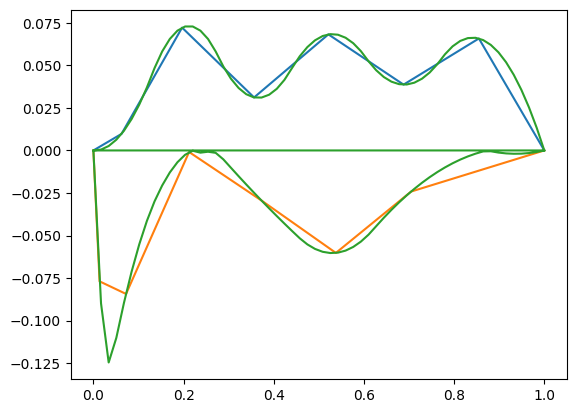

[[ 0.00000000e+00  4.18824924e-19]
 [ 1.69491525e-02  5.06019041e-04]
 [ 3.38983051e-02  2.60419489e-03]
 [ 5.08474576e-02  6.29452754e-03]
 [ 6.77966102e-02  1.15770170e-02]
 [ 8.47457627e-02  1.84516633e-02]
 [ 1.01694915e-01  2.69184663e-02]
 [ 1.18644068e-01  3.69774262e-02]
 [ 1.35593220e-01  4.83716358e-02]
 [ 1.52542373e-01  5.81552493e-02]
 [ 1.69491525e-01  6.54926515e-02]
 [ 1.86440678e-01  7.03838422e-02]
 [ 2.03389831e-01  7.28288215e-02]
 [ 2.20338983e-01  7.28275894e-02]
 [ 2.37288136e-01  7.03801460e-02]
 [ 2.54237288e-01  6.54864911e-02]
 [ 2.71186441e-01  5.81466248e-02]
 [ 2.88135593e-01  4.93526047e-02]
 [ 3.05084746e-01  4.21308214e-02]
 [ 3.22033898e-01  3.66910122e-02]
 [ 3.38983051e-01  3.30331774e-02]
 [ 3.55932203e-01  3.11573168e-02]
 [ 3.72881356e-01  3.10634305e-02]
 [ 3.89830508e-01  3.27515184e-02]
 [ 4.06779661e-01  3.62215806e-02]
 [ 4.23728814e-01  4.14736170e-02]
 [ 4.40677966e-01  4.84869130e-02]
 [ 4.57627119e-01  5.53284499e-02]
 [ 4.74576271e-01  6

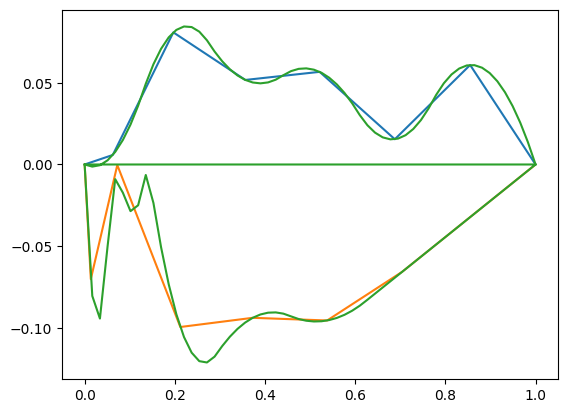

[[ 0.00000000e+00  0.00000000e+00]
 [ 1.69491525e-02 -1.29237204e-03]
 [ 3.38983051e-02 -4.41630929e-04]
 [ 5.08474576e-02  2.55222334e-03]
 [ 6.77966102e-02  7.68919077e-03]
 [ 8.47457627e-02  1.49692714e-02]
 [ 1.01694915e-01  2.43924651e-02]
 [ 1.18644068e-01  3.59587720e-02]
 [ 1.35593220e-01  4.93757487e-02]
 [ 1.52542373e-01  6.12900690e-02]
 [ 1.69491525e-01  7.07505322e-02]
 [ 1.86440678e-01  7.77571384e-02]
 [ 2.03389831e-01  8.23098874e-02]
 [ 2.20338983e-01  8.44087795e-02]
 [ 2.37288136e-01  8.40538144e-02]
 [ 2.54237288e-01  8.12449923e-02]
 [ 2.71186441e-01  7.59823130e-02]
 [ 2.88135593e-01  6.90973193e-02]
 [ 3.05084746e-01  6.31267311e-02]
 [ 3.22033898e-01  5.82463505e-02]
 [ 3.38983051e-01  5.44561774e-02]
 [ 3.55932203e-01  5.17562119e-02]
 [ 3.72881356e-01  5.01464539e-02]
 [ 3.89830508e-01  4.96269034e-02]
 [ 4.06779661e-01  5.01975606e-02]
 [ 4.23728814e-01  5.18584252e-02]
 [ 4.40677966e-01  5.45953999e-02]
 [ 4.57627119e-01  5.70929586e-02]
 [ 4.74576271e-01  5

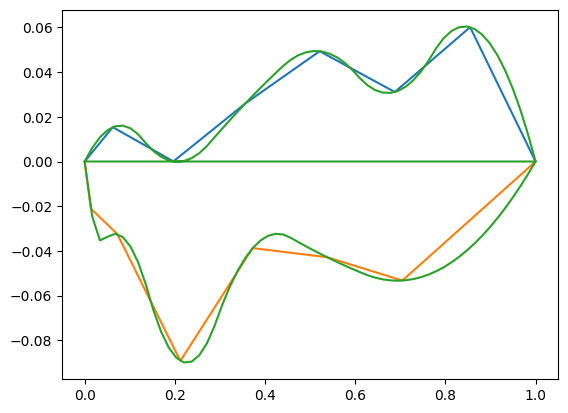

[[ 0.00000000e+00  0.00000000e+00]
 [ 1.69491525e-02  6.14189668e-03]
 [ 3.38983051e-02  1.08168335e-02]
 [ 5.08474576e-02  1.40248105e-02]
 [ 6.77966102e-02  1.57658277e-02]
 [ 8.47457627e-02  1.60398850e-02]
 [ 1.01694915e-01  1.48469824e-02]
 [ 1.18644068e-01  1.21871201e-02]
 [ 1.35593220e-01  8.21460283e-03]
 [ 1.52542373e-01  4.69878148e-03]
 [ 1.69491525e-01  2.14154805e-03]
 [ 1.86440678e-01  5.42902550e-04]
 [ 2.03389831e-01 -9.71550303e-05]
 [ 2.20338983e-01  2.21375313e-04]
 [ 2.37288136e-01  1.49849358e-03]
 [ 2.54237288e-01  3.73419977e-03]
 [ 2.71186441e-01  6.92849389e-03]
 [ 2.88135593e-01  1.08374922e-02]
 [ 3.05084746e-01  1.47171980e-02]
 [ 3.22033898e-01  1.85160503e-02]
 [ 3.38983051e-01  2.22340491e-02]
 [ 3.55932203e-01  2.58711944e-02]
 [ 3.72881356e-01  2.94274861e-02]
 [ 3.89830508e-01  3.29029243e-02]
 [ 4.06779661e-01  3.62975090e-02]
 [ 4.23728814e-01  3.96112401e-02]
 [ 4.40677966e-01  4.28398987e-02]
 [ 4.57627119e-01  4.55897892e-02]
 [ 4.74576271e-01  4

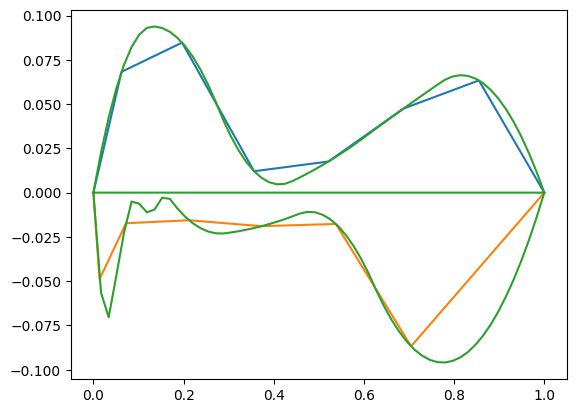

[[ 0.00000000e+00 -8.37649847e-19]
 [ 1.69491525e-02  2.27571264e-02]
 [ 3.38983051e-02  4.23584290e-02]
 [ 5.08474576e-02  5.88039076e-02]
 [ 6.77966102e-02  7.20935623e-02]
 [ 8.47457627e-02  8.22273931e-02]
 [ 1.01694915e-01  8.92054000e-02]
 [ 1.18644068e-01  9.30275829e-02]
 [ 1.35593220e-01  9.38140350e-02]
 [ 1.52542373e-01  9.29418126e-02]
 [ 1.69491525e-01  9.08015301e-02]
 [ 1.86440678e-01  8.73931874e-02]
 [ 2.03389831e-01  8.27167845e-02]
 [ 2.20338983e-01  7.67723214e-02]
 [ 2.37288136e-01  6.95597982e-02]
 [ 2.54237288e-01  6.10792147e-02]
 [ 2.71186441e-01  5.13305712e-02]
 [ 2.88135593e-01  4.09258874e-02]
 [ 3.05084746e-01  3.17322034e-02]
 [ 3.22033898e-01  2.38789106e-02]
 [ 3.38983051e-01  1.73660089e-02]
 [ 3.55932203e-01  1.21934983e-02]
 [ 3.72881356e-01  8.36137886e-03]
 [ 3.89830508e-01  5.86965051e-03]
 [ 4.06779661e-01  4.71831328e-03]
 [ 4.23728814e-01  4.90736717e-03]
 [ 4.40677966e-01  6.42895647e-03]
 [ 4.57627119e-01  8.55001863e-03]
 [ 4.74576271e-01  1

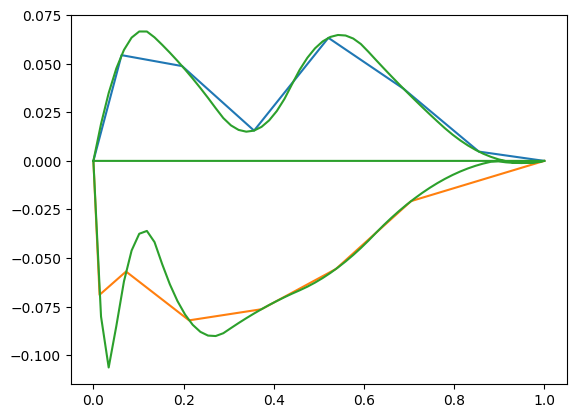

[[ 0.00000000e+00  0.00000000e+00]
 [ 1.69491525e-02  1.90408867e-02]
 [ 3.38983051e-02  3.49049672e-02]
 [ 5.08474576e-02  4.75922416e-02]
 [ 6.77966102e-02  5.71027099e-02]
 [ 8.47457627e-02  6.34363720e-02]
 [ 1.01694915e-01  6.65932279e-02]
 [ 1.18644068e-01  6.65732778e-02]
 [ 1.35593220e-01  6.35654487e-02]
 [ 1.52542373e-01  5.97360900e-02]
 [ 1.69491525e-01  5.56997059e-02]
 [ 1.86440678e-01  5.14562964e-02]
 [ 2.03389831e-01  4.70058616e-02]
 [ 2.20338983e-01  4.23484014e-02]
 [ 2.37288136e-01  3.74839158e-02]
 [ 2.54237288e-01  3.24124049e-02]
 [ 2.71186441e-01  2.71338685e-02]
 [ 2.88135593e-01  2.20314169e-02]
 [ 3.05084746e-01  1.82737727e-02]
 [ 3.22033898e-01  1.59419321e-02]
 [ 3.38983051e-01  1.50358948e-02]
 [ 3.55932203e-01  1.55556610e-02]
 [ 3.72881356e-01  1.75012306e-02]
 [ 3.89830508e-01  2.08726037e-02]
 [ 4.06779661e-01  2.56697802e-02]
 [ 4.23728814e-01  3.18927601e-02]
 [ 4.40677966e-01  3.95241212e-02]
 [ 4.57627119e-01  4.69380796e-02]
 [ 4.74576271e-01  5

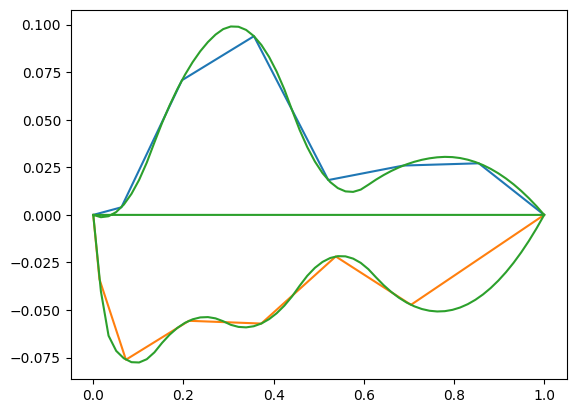

[[ 0.00000000e+00 -1.25647477e-18]
 [ 1.69491525e-02 -1.21124370e-03]
 [ 3.38983051e-02 -7.10870128e-04]
 [ 5.08474576e-02  1.50112070e-03]
 [ 6.77966102e-02  5.42472880e-03]
 [ 8.47457627e-02  1.10599542e-02]
 [ 1.01694915e-01  1.84067968e-02]
 [ 1.18644068e-01  2.74652567e-02]
 [ 1.35593220e-01  3.80690459e-02]
 [ 1.52542373e-01  4.83114112e-02]
 [ 1.69491525e-01  5.76514848e-02]
 [ 1.86440678e-01  6.60892669e-02]
 [ 2.03389831e-01  7.36247573e-02]
 [ 2.20338983e-01  8.02579562e-02]
 [ 2.37288136e-01  8.59888635e-02]
 [ 2.54237288e-01  9.08174792e-02]
 [ 2.71186441e-01  9.47438033e-02]
 [ 2.88135593e-01  9.76216721e-02]
 [ 3.05084746e-01  9.90051961e-02]
 [ 3.22033898e-01  9.88634736e-02]
 [ 3.38983051e-01  9.71965048e-02]
 [ 3.55932203e-01  9.40042897e-02]
 [ 3.72881356e-01  8.92868281e-02]
 [ 3.89830508e-01  8.30441202e-02]
 [ 4.06779661e-01  7.52761660e-02]
 [ 4.23728814e-01  6.59829653e-02]
 [ 4.40677966e-01  5.51837558e-02]
 [ 4.57627119e-01  4.46736996e-02]
 [ 4.74576271e-01  3

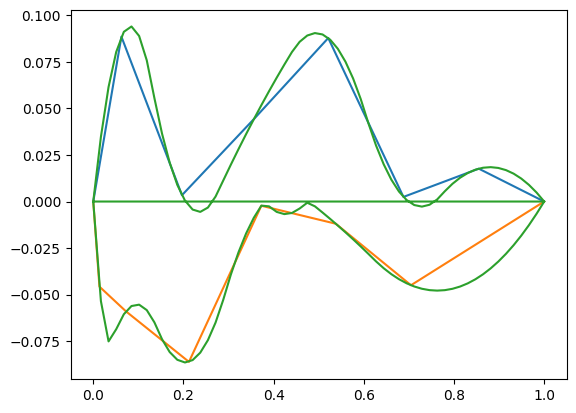

[[ 0.00000000e+00  4.18824924e-18]
 [ 1.69491525e-02  3.47554256e-02]
 [ 3.38983051e-02  6.15391790e-02]
 [ 5.08474576e-02  8.03512600e-02]
 [ 6.77966102e-02  9.11916686e-02]
 [ 8.47457627e-02  9.40604050e-02]
 [ 1.01694915e-01  8.89574690e-02]
 [ 1.18644068e-01  7.58828607e-02]
 [ 1.35593220e-01  5.55711286e-02]
 [ 1.52542373e-01  3.64450339e-02]
 [ 1.69491525e-01  2.08937676e-02]
 [ 1.86440678e-01  8.91732969e-03]
 [ 2.03389831e-01  5.15720146e-04]
 [ 2.20338983e-01 -4.31106102e-03]
 [ 2.37288136e-01 -5.56301381e-03]
 [ 2.54237288e-01 -3.24013823e-03]
 [ 2.71186441e-01  2.65756574e-03]
 [ 2.88135593e-01  1.12401865e-02]
 [ 3.05084746e-01  1.97929425e-02]
 [ 3.22033898e-01  2.81276915e-02]
 [ 3.38983051e-01  3.62444334e-02]
 [ 3.55932203e-01  4.41431683e-02]
 [ 3.72881356e-01  5.18238963e-02]
 [ 3.89830508e-01  5.92866172e-02]
 [ 4.06779661e-01  6.65313311e-02]
 [ 4.23728814e-01  7.35580380e-02]
 [ 4.40677966e-01  8.03548330e-02]
 [ 4.57627119e-01  8.58108023e-02]
 [ 4.74576271e-01  8

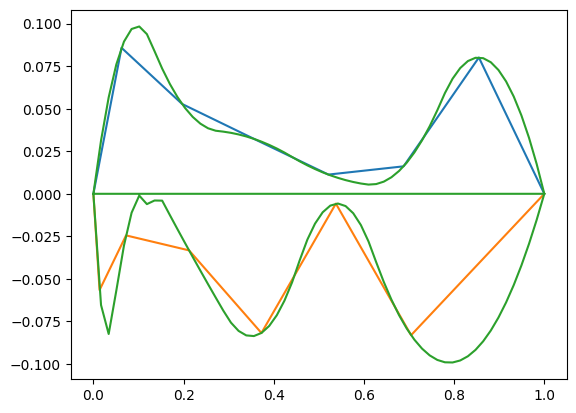

[[ 0.00000000e+00  1.25647477e-18]
 [ 1.69491525e-02  3.13133454e-02]
 [ 3.38983051e-02  5.66579095e-02]
 [ 5.08474576e-02  7.60336923e-02]
 [ 6.77966102e-02  8.94406939e-02]
 [ 8.47457627e-02  9.68789142e-02]
 [ 1.01694915e-01  9.83483532e-02]
 [ 1.18644068e-01  9.38490110e-02]
 [ 1.35593220e-01  8.38405872e-02]
 [ 1.52542373e-01  7.35942663e-02]
 [ 1.69491525e-01  6.46052666e-02]
 [ 1.86440678e-01  5.68735880e-02]
 [ 2.03389831e-01  5.03992306e-02]
 [ 2.20338983e-01  4.51821944e-02]
 [ 2.37288136e-01  4.12224794e-02]
 [ 2.54237288e-01  3.85200855e-02]
 [ 2.71186441e-01  3.70750128e-02]
 [ 2.88135593e-01  3.65363726e-02]
 [ 3.05084746e-01  3.58337374e-02]
 [ 3.22033898e-01  3.48929234e-02]
 [ 3.38983051e-01  3.37139307e-02]
 [ 3.55932203e-01  3.22967591e-02]
 [ 3.72881356e-01  3.06414088e-02]
 [ 3.89830508e-01  2.87478797e-02]
 [ 4.06779661e-01  2.66161718e-02]
 [ 4.23728814e-01  2.42462852e-02]
 [ 4.40677966e-01  2.16411026e-02]
 [ 4.57627119e-01  1.90696382e-02]
 [ 4.74576271e-01  1

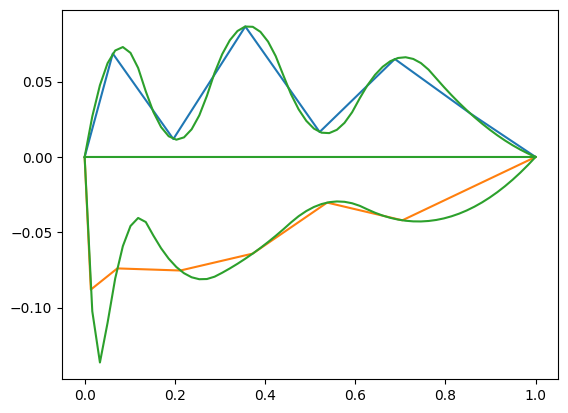

[[ 0.00000000e+00  9.42356078e-19]
 [ 1.69491525e-02  2.68953707e-02]
 [ 3.38983051e-02  4.76394924e-02]
 [ 5.08474576e-02  6.22323652e-02]
 [ 6.77966102e-02  7.06739889e-02]
 [ 8.47457627e-02  7.29643637e-02]
 [ 1.01694915e-01  6.91034894e-02]
 [ 1.18644068e-01  5.90913662e-02]
 [ 1.35593220e-01  4.35628188e-02]
 [ 1.52542373e-01  2.97971175e-02]
 [ 1.69491525e-01  1.98590919e-02]
 [ 1.86440678e-01  1.37487420e-02]
 [ 2.03389831e-01  1.14660679e-02]
 [ 2.20338983e-01  1.30110695e-02]
 [ 2.37288136e-01  1.83837469e-02]
 [ 2.54237288e-01  2.75841000e-02]
 [ 2.71186441e-01  4.06121289e-02]
 [ 2.88135593e-01  5.58305776e-02]
 [ 3.05084746e-01  6.82448012e-02]
 [ 3.22033898e-01  7.75086564e-02]
 [ 3.38983051e-01  8.36221431e-02]
 [ 3.55932203e-01  8.65852615e-02]
 [ 3.72881356e-01  8.63980114e-02]
 [ 3.89830508e-01  8.30603930e-02]
 [ 4.06779661e-01  7.65724061e-02]
 [ 4.23728814e-01  6.69340509e-02]
 [ 4.40677966e-01  5.41813498e-02]
 [ 4.57627119e-01  4.16757837e-02]
 [ 4.74576271e-01  3

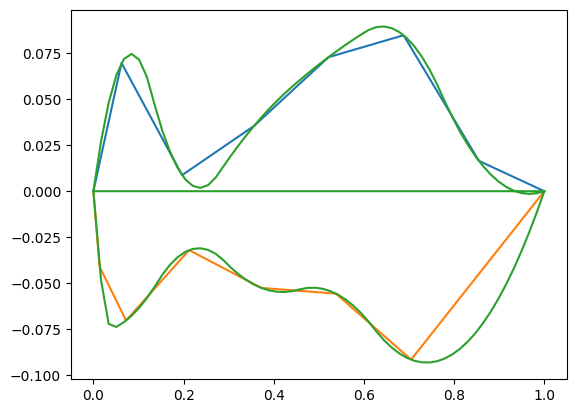

[[ 0.00000000e+00  2.09412462e-19]
 [ 1.69491525e-02  2.70544868e-02]
 [ 3.38983051e-02  4.80446393e-02]
 [ 5.08474576e-02  6.29704575e-02]
 [ 6.77966102e-02  7.18319414e-02]
 [ 8.47457627e-02  7.46290911e-02]
 [ 1.01694915e-01  7.13619065e-02]
 [ 1.18644068e-01  6.20303875e-02]
 [ 1.35593220e-01  4.71852045e-02]
 [ 1.52542373e-01  3.31406617e-02]
 [ 1.69491525e-01  2.16878677e-02]
 [ 1.86440678e-01  1.28268224e-02]
 [ 2.03389831e-01  6.55752596e-03]
 [ 2.20338983e-01  2.87997826e-03]
 [ 2.37288136e-01  1.79417934e-03]
 [ 2.54237288e-01  3.30012918e-03]
 [ 2.71186441e-01  7.39782780e-03]
 [ 2.88135593e-01  1.34161401e-02]
 [ 3.05084746e-01  1.93076882e-02]
 [ 3.22033898e-01  2.49305830e-02]
 [ 3.38983051e-01  3.02848243e-02]
 [ 3.55932203e-01  3.53704123e-02]
 [ 3.72881356e-01  4.01873469e-02]
 [ 3.89830508e-01  4.47356282e-02]
 [ 4.06779661e-01  4.90152561e-02]
 [ 4.23728814e-01  5.30262306e-02]
 [ 4.40677966e-01  5.67695886e-02]
 [ 4.57627119e-01  6.03420836e-02]
 [ 4.74576271e-01  6

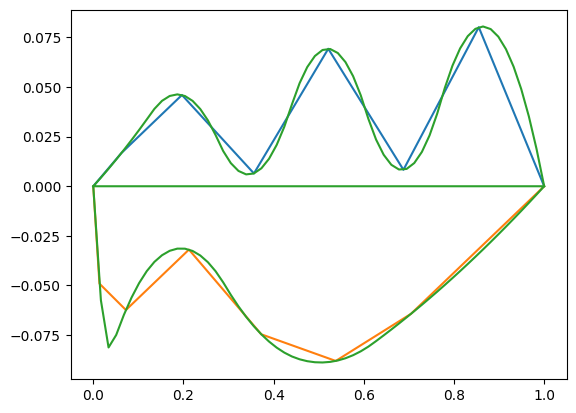

[[ 0.00000000e+00 -4.18824924e-19]
 [ 1.69491525e-02  4.33309783e-03]
 [ 3.38983051e-02  8.82472070e-03]
 [ 5.08474576e-02  1.34748686e-02]
 [ 6.77966102e-02  1.82835415e-02]
 [ 8.47457627e-02  2.32507394e-02]
 [ 1.01694915e-01  2.83764624e-02]
 [ 1.18644068e-01  3.36607104e-02]
 [ 1.35593220e-01  3.89895816e-02]
 [ 1.52542373e-01  4.30570118e-02]
 [ 1.69491525e-01  4.54925243e-02]
 [ 1.86440678e-01  4.62961190e-02]
 [ 2.03389831e-01  4.54677959e-02]
 [ 2.20338983e-01  4.30075551e-02]
 [ 2.37288136e-01  3.89153965e-02]
 [ 2.54237288e-01  3.31913202e-02]
 [ 2.71186441e-01  2.58353261e-02]
 [ 2.88135593e-01  1.77420786e-02]
 [ 3.05084746e-01  1.16408586e-02]
 [ 3.22033898e-01  7.72081311e-03]
 [ 3.38983051e-01  5.98194206e-03]
 [ 3.55932203e-01  6.42424548e-03]
 [ 3.72881356e-01  9.04772336e-03]
 [ 3.89830508e-01  1.38523757e-02]
 [ 4.06779661e-01  2.08382025e-02]
 [ 4.23728814e-01  3.00052038e-02]
 [ 4.40677966e-01  4.13230314e-02]
 [ 4.57627119e-01  5.19597134e-02]
 [ 4.74576271e-01  6

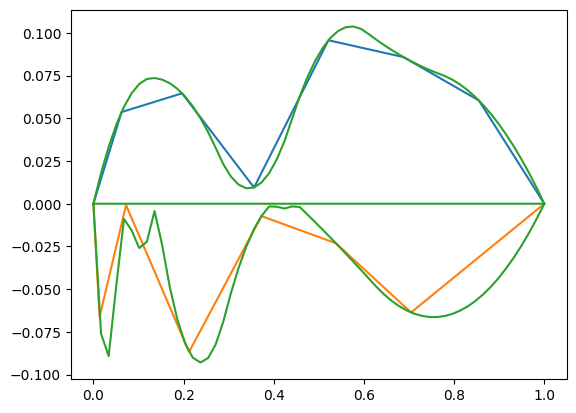

[[ 0.00000000e+00  2.93177447e-18]
 [ 1.69491525e-02  1.79077058e-02]
 [ 3.38983051e-02  3.33223905e-02]
 [ 5.08474576e-02  4.62440541e-02]
 [ 6.77966102e-02  5.66726966e-02]
 [ 8.47457627e-02  6.46083180e-02]
 [ 1.01694915e-01  7.00509183e-02]
 [ 1.18644068e-01  7.30004974e-02]
 [ 1.35593220e-01  7.35396705e-02]
 [ 1.52542373e-01  7.26157490e-02]
 [ 1.69491525e-01  7.04974462e-02]
 [ 1.86440678e-01  6.71847623e-02]
 [ 2.03389831e-01  6.26776971e-02]
 [ 2.20338983e-01  5.69762507e-02]
 [ 2.37288136e-01  5.00804230e-02]
 [ 2.54237288e-01  4.19902142e-02]
 [ 2.71186441e-01  3.27056241e-02]
 [ 2.88135593e-01  2.31050534e-02]
 [ 3.05084746e-01  1.58681683e-02]
 [ 3.22033898e-01  1.11806772e-02]
 [ 3.38983051e-01  9.04258027e-03]
 [ 3.55932203e-01  9.45387743e-03]
 [ 3.72881356e-01  1.24145687e-02]
 [ 3.89830508e-01  1.79246541e-02]
 [ 4.06779661e-01  2.59841335e-02]
 [ 4.23728814e-01  3.65930071e-02]
 [ 4.40677966e-01  4.97232946e-02]
 [ 4.57627119e-01  6.27640009e-02]
 [ 4.74576271e-01  7

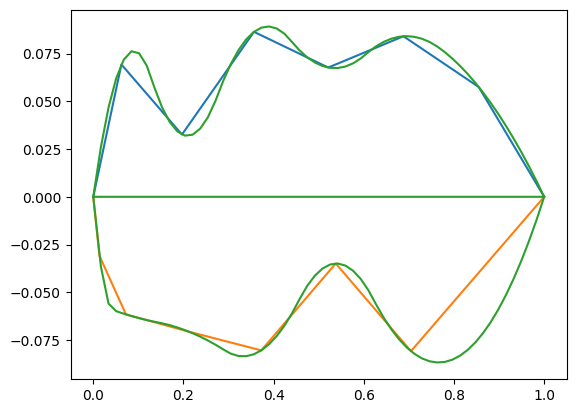

[[ 0.00000000e+00  3.03648070e-18]
 [ 1.69491525e-02  2.61140196e-02]
 [ 3.38983051e-02  4.67927183e-02]
 [ 5.08474576e-02  6.20360962e-02]
 [ 6.77966102e-02  7.18441532e-02]
 [ 8.47457627e-02  7.62168894e-02]
 [ 1.01694915e-01  7.51543047e-02]
 [ 1.18644068e-01  6.86563992e-02]
 [ 1.35593220e-01  5.72419137e-02]
 [ 1.52542373e-01  4.68590337e-02]
 [ 1.69491525e-01  3.91950147e-02]
 [ 1.86440678e-01  3.42498568e-02]
 [ 2.03389831e-01  3.20235600e-02]
 [ 2.20338983e-01  3.25161242e-02]
 [ 2.37288136e-01  3.57275495e-02]
 [ 2.54237288e-01  4.16578358e-02]
 [ 2.71186441e-01  5.03069832e-02]
 [ 2.88135593e-01  6.06480879e-02]
 [ 3.05084746e-01  6.95484569e-02]
 [ 3.22033898e-01  7.67909857e-02]
 [ 3.38983051e-01  8.23756743e-02]
 [ 3.55932203e-01  8.63025226e-02]
 [ 3.72881356e-01  8.85715307e-02]
 [ 3.89830508e-01  8.91826986e-02]
 [ 4.06779661e-01  8.81360262e-02]
 [ 4.23728814e-01  8.54315136e-02]
 [ 4.40677966e-01  8.10854695e-02]
 [ 4.57627119e-01  7.66197529e-02]
 [ 4.74576271e-01  7

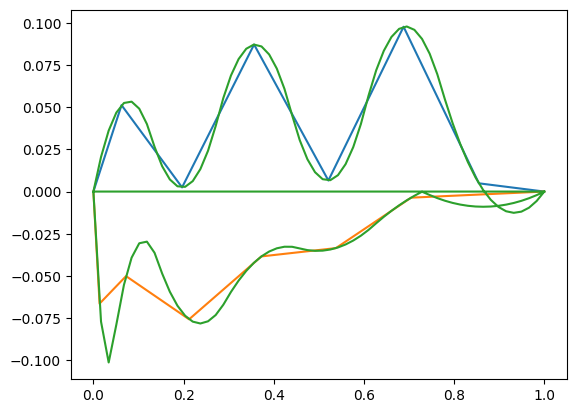

[[ 0.00000000e+00  2.09412462e-19]
 [ 1.69491525e-02  2.05272102e-02]
 [ 3.38983051e-02  3.61175154e-02]
 [ 5.08474576e-02  4.67709154e-02]
 [ 6.77966102e-02  5.24874104e-02]
 [ 8.47457627e-02  5.32670003e-02]
 [ 1.01694915e-01  4.91096851e-02]
 [ 1.18644068e-01  4.00154648e-02]
 [ 1.35593220e-01  2.65360002e-02]
 [ 1.52542373e-01  1.49969534e-02]
 [ 1.69491525e-01  7.19265480e-03]
 [ 1.86440678e-01  3.12310439e-03]
 [ 2.03389831e-01  2.78830215e-03]
 [ 2.20338983e-01  6.18824810e-03]
 [ 2.37288136e-01  1.33229422e-02]
 [ 2.54237288e-01  2.41923845e-02]
 [ 2.71186441e-01  3.87965750e-02]
 [ 2.88135593e-01  5.54094875e-02]
 [ 3.05084746e-01  6.87656726e-02]
 [ 3.22033898e-01  7.85002196e-02]
 [ 3.38983051e-01  8.46131284e-02]
 [ 3.55932203e-01  8.71043990e-02]
 [ 3.72881356e-01  8.59740315e-02]
 [ 3.89830508e-01  8.12220259e-02]
 [ 4.06779661e-01  7.28483820e-02]
 [ 4.23728814e-01  6.08531000e-02]
 [ 4.40677966e-01  4.52824080e-02]
 [ 4.57627119e-01  3.04501251e-02]
 [ 4.74576271e-01  1

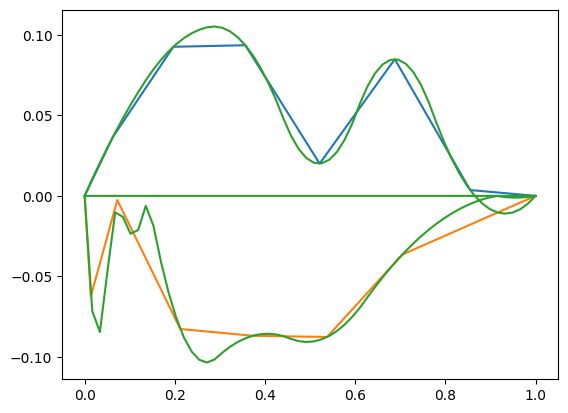

[[ 0.00000000e+00  4.18824924e-19]
 [ 1.69491525e-02  1.04744923e-02]
 [ 3.38983051e-02  2.05183070e-02]
 [ 5.08474576e-02  3.01314443e-02]
 [ 6.77966102e-02  3.93139039e-02]
 [ 8.47457627e-02  4.80656861e-02]
 [ 1.01694915e-01  5.63867907e-02]
 [ 1.18644068e-01  6.42772177e-02]
 [ 1.35593220e-01  7.17162582e-02]
 [ 1.52542373e-01  7.84664500e-02]
 [ 1.69491525e-01  8.44604350e-02]
 [ 1.86440678e-01  8.96982130e-02]
 [ 2.03389831e-01  9.41797843e-02]
 [ 2.20338983e-01  9.79051486e-02]
 [ 2.37288136e-01  1.00874306e-01]
 [ 2.54237288e-01  1.03087257e-01]
 [ 2.71186441e-01  1.04544001e-01]
 [ 2.88135593e-01  1.05097379e-01]
 [ 3.05084746e-01  1.04298465e-01]
 [ 3.22033898e-01  1.02116149e-01]
 [ 3.38983051e-01  9.85504295e-02]
 [ 3.55932203e-01  9.36013069e-02]
 [ 3.72881356e-01  8.72687812e-02]
 [ 3.89830508e-01  7.95528523e-02]
 [ 4.06779661e-01  7.04535203e-02]
 [ 4.23728814e-01  5.99707852e-02]
 [ 4.40677966e-01  4.81303156e-02]
 [ 4.57627119e-01  3.73274031e-02]
 [ 4.74576271e-01  2

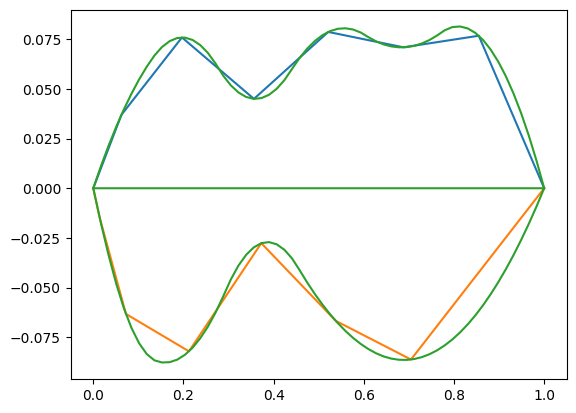

[[ 0.00000000e+00  4.18824924e-19]
 [ 1.69491525e-02  1.10765714e-02]
 [ 3.38983051e-02  2.13743900e-02]
 [ 5.08474576e-02  3.08934560e-02]
 [ 6.77966102e-02  3.96337693e-02]
 [ 8.47457627e-02  4.75953299e-02]
 [ 1.01694915e-01  5.47781378e-02]
 [ 1.18644068e-01  6.11821930e-02]
 [ 1.35593220e-01  6.67692070e-02]
 [ 1.52542373e-01  7.11001412e-02]
 [ 1.69491525e-01  7.40504584e-02]
 [ 1.86440678e-01  7.56201585e-02]
 [ 2.03389831e-01  7.58092417e-02]
 [ 2.20338983e-01  7.46177079e-02]
 [ 2.37288136e-01  7.20455571e-02]
 [ 2.54237288e-01  6.80927893e-02]
 [ 2.71186441e-01  6.27594044e-02]
 [ 2.88135593e-01  5.66783379e-02]
 [ 3.05084746e-01  5.17804345e-02]
 [ 3.22033898e-01  4.81995073e-02]
 [ 3.38983051e-01  4.59355562e-02]
 [ 3.55932203e-01  4.49885815e-02]
 [ 3.72881356e-01  4.53585829e-02]
 [ 3.89830508e-01  4.70455605e-02]
 [ 4.06779661e-01  5.00495143e-02]
 [ 4.23728814e-01  5.43704444e-02]
 [ 4.40677966e-01  5.99941467e-02]
 [ 4.57627119e-01  6.55951718e-02]
 [ 4.74576271e-01  7

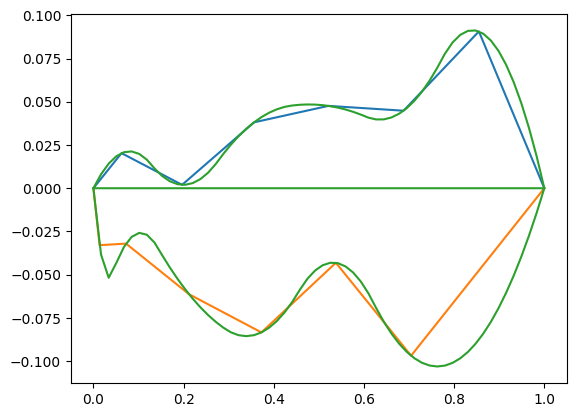

[[ 0.00000000e+00  4.71178039e-19]
 [ 1.69491525e-02  8.06098846e-03]
 [ 3.38983051e-02  1.42203188e-02]
 [ 5.08474576e-02  1.84779910e-02]
 [ 6.77966102e-02  2.08340051e-02]
 [ 8.47457627e-02  2.12883610e-02]
 [ 1.01694915e-01  1.98410589e-02]
 [ 1.18644068e-01  1.64920986e-02]
 [ 1.35593220e-01  1.14476806e-02]
 [ 1.52542373e-01  7.07222005e-03]
 [ 1.69491525e-01  4.03640408e-03]
 [ 1.86440678e-01  2.34023274e-03]
 [ 2.03389831e-01  1.98370601e-03]
 [ 2.20338983e-01  2.96682391e-03]
 [ 2.37288136e-01  5.28958643e-03]
 [ 2.54237288e-01  8.95199357e-03]
 [ 2.71186441e-01  1.39540453e-02]
 [ 2.88135593e-01  1.98464042e-02]
 [ 3.05084746e-01  2.52583123e-02]
 [ 3.22033898e-01  3.00947722e-02]
 [ 3.38983051e-01  3.43557839e-02]
 [ 3.55932203e-01  3.80413474e-02]
 [ 3.72881356e-01  4.11514626e-02]
 [ 3.89830508e-01  4.36861296e-02]
 [ 4.06779661e-01  4.56453484e-02]
 [ 4.23728814e-01  4.70291190e-02]
 [ 4.40677966e-01  4.78395125e-02]
 [ 4.57627119e-01  4.82697952e-02]
 [ 4.74576271e-01  4

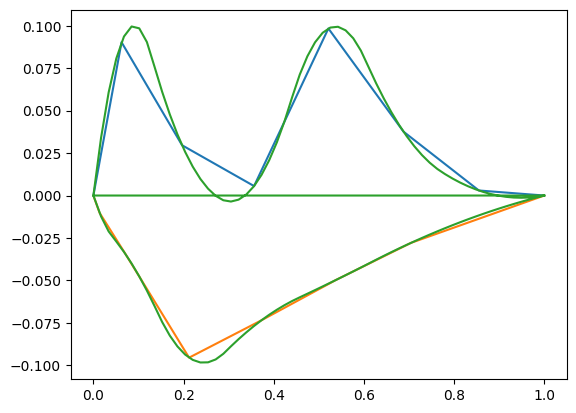

[[ 0.00000000e+00  1.78000593e-18]
 [ 1.69491525e-02  3.39131051e-02]
 [ 3.38983051e-02  6.08262869e-02]
 [ 5.08474576e-02  8.07395452e-02]
 [ 6.77966102e-02  9.36528802e-02]
 [ 8.47457627e-02  9.95662918e-02]
 [ 1.01694915e-01  9.84797800e-02]
 [ 1.18644068e-01  9.03933449e-02]
 [ 1.35593220e-01  7.58484842e-02]
 [ 1.52542373e-01  6.10543274e-02]
 [ 1.69491525e-01  4.77721493e-02]
 [ 1.86440678e-01  3.60019497e-02]
 [ 2.03389831e-01  2.57437288e-02]
 [ 2.20338983e-01  1.69974866e-02]
 [ 2.37288136e-01  9.76322290e-03]
 [ 2.54237288e-01  4.04093787e-03]
 [ 2.71186441e-01 -1.69368539e-04]
 [ 2.88135593e-01 -2.78277812e-03]
 [ 3.05084746e-01 -3.54023775e-03]
 [ 3.22033898e-01 -2.42379430e-03]
 [ 3.38983051e-01  5.66552241e-04]
 [ 3.55932203e-01  5.43080186e-03]
 [ 3.72881356e-01  1.21689546e-02]
 [ 3.89830508e-01  2.07810103e-02]
 [ 4.06779661e-01  3.12669692e-02]
 [ 4.23728814e-01  4.36268311e-02]
 [ 4.40677966e-01  5.78319359e-02]
 [ 4.57627119e-01  7.12078257e-02]
 [ 4.74576271e-01  8

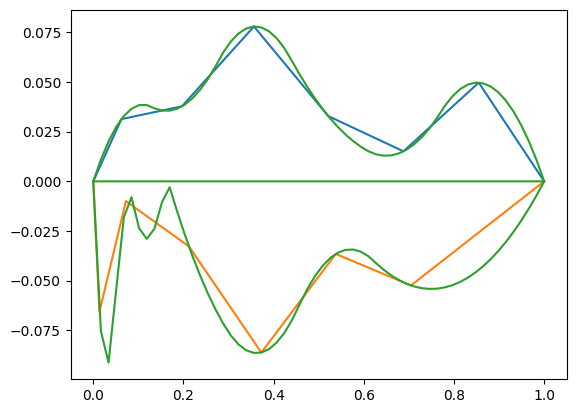

[[ 0.00000000e+00 -6.28237385e-19]
 [ 1.69491525e-02  1.09497900e-02]
 [ 3.38983051e-02  2.00778659e-02]
 [ 5.08474576e-02  2.73842277e-02]
 [ 6.77966102e-02  3.28688755e-02]
 [ 8.47457627e-02  3.65318093e-02]
 [ 1.01694915e-01  3.83730290e-02]
 [ 1.18644068e-01  3.83925347e-02]
 [ 1.35593220e-01  3.67749648e-02]
 [ 1.52542373e-01  3.56374911e-02]
 [ 1.69491525e-01  3.55806681e-02]
 [ 1.86440678e-01  3.66044960e-02]
 [ 2.03389831e-01  3.87089746e-02]
 [ 2.20338983e-01  4.18941040e-02]
 [ 2.37288136e-01  4.61598842e-02]
 [ 2.54237288e-01  5.15063152e-02]
 [ 2.71186441e-01  5.79333969e-02]
 [ 2.88135593e-01  6.48353934e-02]
 [ 3.05084746e-01  7.03644344e-02]
 [ 3.22033898e-01  7.43924570e-02]
 [ 3.38983051e-01  7.69194613e-02]
 [ 3.55932203e-01  7.79454474e-02]
 [ 3.72881356e-01  7.74704151e-02]
 [ 3.89830508e-01  7.54943645e-02]
 [ 4.06779661e-01  7.20172957e-02]
 [ 4.23728814e-01  6.70392085e-02]
 [ 4.40677966e-01  6.05729273e-02]
 [ 4.57627119e-01  5.38151539e-02]
 [ 4.74576271e-01  4

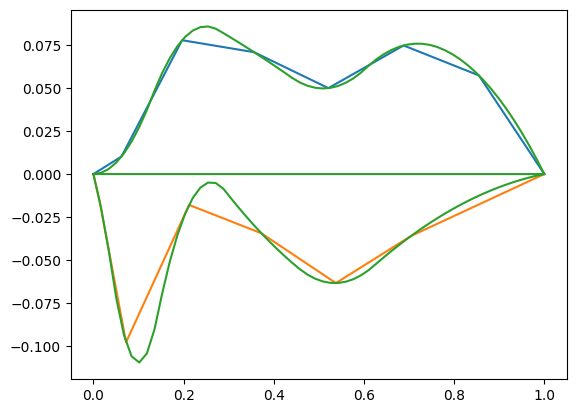

[[ 0.00000000e+00 -1.25647477e-18]
 [ 1.69491525e-02  7.09556593e-04]
 [ 3.38983051e-02  2.96005996e-03]
 [ 5.08474576e-02  6.75151011e-03]
 [ 6.77966102e-02  1.20839070e-02]
 [ 8.47457627e-02  1.89572507e-02]
 [ 1.01694915e-01  2.73715412e-02]
 [ 1.18644068e-01  3.73267785e-02]
 [ 1.35593220e-01  4.86197014e-02]
 [ 1.52542373e-01  5.89195994e-02]
 [ 1.69491525e-01  6.75653457e-02]
 [ 1.86440678e-01  7.45569403e-02]
 [ 2.03389831e-01  7.98943833e-02]
 [ 2.20338983e-01  8.35776747e-02]
 [ 2.37288136e-01  8.56068143e-02]
 [ 2.54237288e-01  8.59818023e-02]
 [ 2.71186441e-01  8.47026387e-02]
 [ 2.88135593e-01  8.21451056e-02]
 [ 3.05084746e-01  7.94555715e-02]
 [ 3.22033898e-01  7.67134832e-02]
 [ 3.38983051e-01  7.39188406e-02]
 [ 3.55932203e-01  7.10716438e-02]
 [ 3.72881356e-01  6.81718926e-02]
 [ 3.89830508e-01  6.52195872e-02]
 [ 4.06779661e-01  6.22147276e-02]
 [ 4.23728814e-01  5.91573136e-02]
 [ 4.40677966e-01  5.60525157e-02]
 [ 4.57627119e-01  5.33828034e-02]
 [ 4.74576271e-01  5

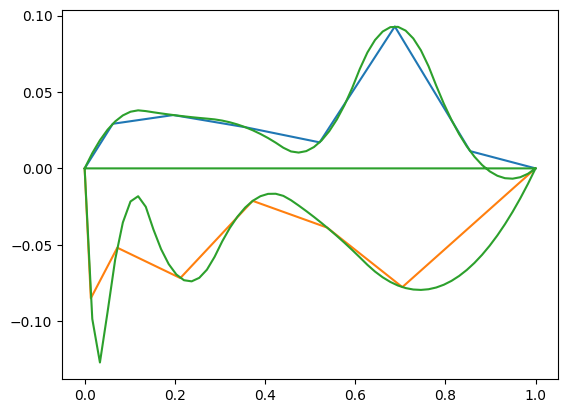

[[ 0.00000000e+00 -1.04706231e-18]
 [ 1.69491525e-02  9.95001969e-03]
 [ 3.38983051e-02  1.83928841e-02]
 [ 5.08474576e-02  2.53285932e-02]
 [ 6.77966102e-02  3.07571470e-02]
 [ 8.47457627e-02  3.46785455e-02]
 [ 1.01694915e-01  3.70927887e-02]
 [ 1.18644068e-01  3.79998766e-02]
 [ 1.35593220e-01  3.74986176e-02]
 [ 1.52542373e-01  3.67220071e-02]
 [ 1.69491525e-01  3.59914291e-02]
 [ 1.86440678e-01  3.53068837e-02]
 [ 2.03389831e-01  3.46683709e-02]
 [ 2.20338983e-01  3.40758907e-02]
 [ 2.37288136e-01  3.35294430e-02]
 [ 2.54237288e-01  3.30290278e-02]
 [ 2.71186441e-01  3.25746453e-02]
 [ 2.88135593e-01  3.20809083e-02]
 [ 3.05084746e-01  3.12873337e-02]
 [ 3.22033898e-01  3.01758693e-02]
 [ 3.38983051e-01  2.87465150e-02]
 [ 3.55932203e-01  2.69992709e-02]
 [ 3.72881356e-01  2.49341369e-02]
 [ 3.89830508e-01  2.25511130e-02]
 [ 4.06779661e-01  1.98501994e-02]
 [ 4.23728814e-01  1.68313958e-02]
 [ 4.40677966e-01  1.35076198e-02]
 [ 4.57627119e-01  1.10842712e-02]
 [ 4.74576271e-01  1

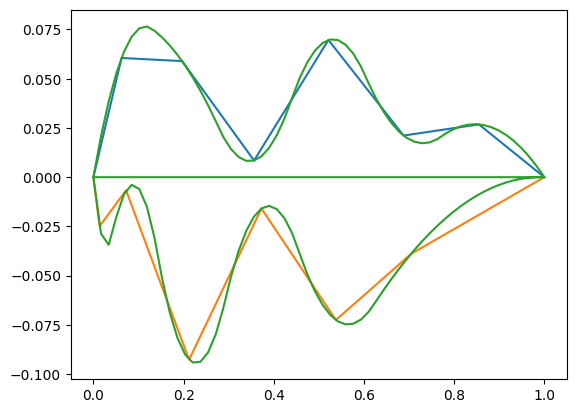

[[ 0.00000000e+00 -1.25647477e-18]
 [ 1.69491525e-02  2.08974378e-02]
 [ 3.38983051e-02  3.84727271e-02]
 [ 5.08474576e-02  5.27258679e-02]
 [ 6.77966102e-02  6.36568603e-02]
 [ 8.47457627e-02  7.12657042e-02]
 [ 1.01694915e-01  7.55523996e-02]
 [ 1.18644068e-01  7.65169466e-02]
 [ 1.35593220e-01  7.43284115e-02]
 [ 1.52542373e-01  7.09254084e-02]
 [ 1.69491525e-01  6.68578424e-02]
 [ 1.86440678e-01  6.21257134e-02]
 [ 2.03389831e-01  5.67290215e-02]
 [ 2.20338983e-01  5.06677666e-02]
 [ 2.37288136e-01  4.39419487e-02]
 [ 2.54237288e-01  3.65515679e-02]
 [ 2.71186441e-01  2.84966241e-02]
 [ 2.88135593e-01  2.04221469e-02]
 [ 3.05084746e-01  1.42958759e-02]
 [ 3.22033898e-01  1.02541811e-02]
 [ 3.38983051e-01  8.29706257e-03]
 [ 3.55932203e-01  8.42452023e-03]
 [ 3.72881356e-01  1.06365541e-02]
 [ 3.89830508e-01  1.49331642e-02]
 [ 4.06779661e-01  2.13143506e-02]
 [ 4.23728814e-01  2.97801131e-02]
 [ 4.40677966e-01  4.03036615e-02]
 [ 4.57627119e-01  5.03850267e-02]
 [ 4.74576271e-01  5

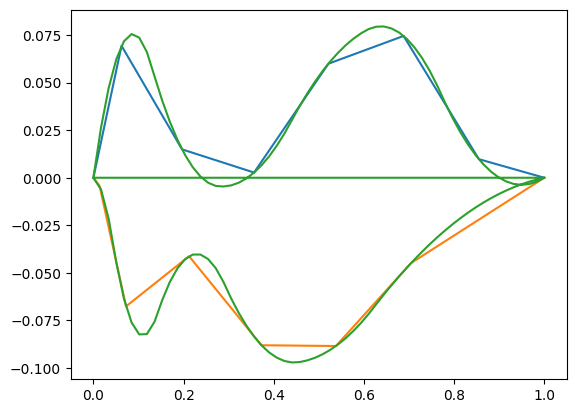

[[ 0.00000000e+00  1.30882789e-18]
 [ 1.69491525e-02  2.64327762e-02]
 [ 3.38983051e-02  4.72003455e-02]
 [ 5.08474576e-02  6.23027078e-02]
 [ 6.77966102e-02  7.17398632e-02]
 [ 8.47457627e-02  7.55118116e-02]
 [ 1.01694915e-01  7.36185531e-02]
 [ 1.18644068e-01  6.60600877e-02]
 [ 1.35593220e-01  5.32966473e-02]
 [ 1.52542373e-01  4.06055187e-02]
 [ 1.69491525e-01  2.94836513e-02]
 [ 1.86440678e-01  1.99310450e-02]
 [ 2.03389831e-01  1.19476999e-02]
 [ 2.20338983e-01  5.53361603e-03]
 [ 2.37288136e-01  6.88793287e-04]
 [ 2.54237288e-01 -2.58676829e-03]
 [ 2.71186441e-01 -4.29306870e-03]
 [ 2.88135593e-01 -4.60249522e-03]
 [ 3.05084746e-01 -4.04093580e-03]
 [ 3.22033898e-01 -2.64483602e-03]
 [ 3.38983051e-01 -4.14195858e-04]
 [ 3.55932203e-01  2.65098468e-03]
 [ 3.72881356e-01  6.55070558e-03]
 [ 3.89830508e-01  1.12849669e-02]
 [ 4.06779661e-01  1.68537685e-02]
 [ 4.23728814e-01  2.32571105e-02]
 [ 4.40677966e-01  3.04861050e-02]
 [ 4.57627119e-01  3.77113657e-02]
 [ 4.74576271e-01  4

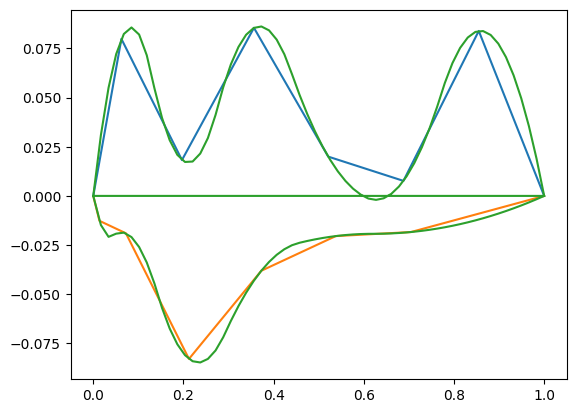

[[ 0.00000000e+00  7.74826109e-18]
 [ 1.69491525e-02  3.09526114e-02]
 [ 3.38983051e-02  5.49930951e-02]
 [ 5.08474576e-02  7.21214513e-02]
 [ 6.77966102e-02  8.23376798e-02]
 [ 8.47457627e-02  8.56417807e-02]
 [ 1.01694915e-01  8.20337540e-02]
 [ 1.18644068e-01  7.15135997e-02]
 [ 1.35593220e-01  5.47652288e-02]
 [ 1.52542373e-01  3.96307630e-02]
 [ 1.69491525e-01  2.83346900e-02]
 [ 1.86440678e-01  2.08770095e-02]
 [ 2.03389831e-01  1.72577217e-02]
 [ 2.20338983e-01  1.74768265e-02]
 [ 2.37288136e-01  2.15343240e-02]
 [ 2.54237288e-01  2.94302141e-02]
 [ 2.71186441e-01  4.11644968e-02]
 [ 2.88135593e-01  5.51976221e-02]
 [ 3.05084746e-01  6.68330083e-02]
 [ 3.22033898e-01  7.57451687e-02]
 [ 3.38983051e-01  8.19341033e-02]
 [ 3.55932203e-01  8.53998121e-02]
 [ 3.72881356e-01  8.61422952e-02]
 [ 3.89830508e-01  8.41615525e-02]
 [ 4.06779661e-01  7.94575841e-02]
 [ 4.23728814e-01  7.20303899e-02]
 [ 4.40677966e-01  6.19036321e-02]
 [ 4.57627119e-01  5.12853764e-02]
 [ 4.74576271e-01  4

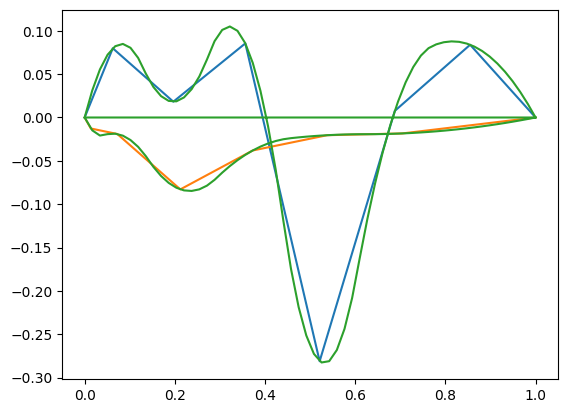

[[ 0.00000000e+00  5.23531155e-18]
 [ 1.69491525e-02  3.12761491e-02]
 [ 3.38983051e-02  5.53988420e-02]
 [ 5.08474576e-02  7.23680788e-02]
 [ 6.77966102e-02  8.21838594e-02]
 [ 8.47457627e-02  8.48461838e-02]
 [ 1.01694915e-01  8.03550521e-02]
 [ 1.18644068e-01  6.87104642e-02]
 [ 1.35593220e-01  5.06862709e-02]
 [ 1.52542373e-01  3.51558936e-02]
 [ 1.69491525e-01  2.46363572e-02]
 [ 1.86440678e-01  1.91276618e-02]
 [ 2.03389831e-01  1.86298074e-02]
 [ 2.20338983e-01  2.31427939e-02]
 [ 2.37288136e-01  3.26666213e-02]
 [ 2.54237288e-01  4.72012896e-02]
 [ 2.71186441e-01  6.67467989e-02]
 [ 2.88135593e-01  8.80166102e-02]
 [ 3.05084746e-01  1.00984743e-01]
 [ 3.22033898e-01  1.04956368e-01]
 [ 3.38983051e-01  9.99314843e-02]
 [ 3.55932203e-01  8.59100933e-02]
 [ 3.72881356e-01  6.28921943e-02]
 [ 3.89830508e-01  3.08777874e-02]
 [ 4.06779661e-01 -1.01331274e-02]
 [ 4.23728814e-01 -6.01405501e-02]
 [ 4.40677966e-01 -1.19013225e-01]
 [ 4.57627119e-01 -1.74502872e-01]
 [ 4.74576271e-01 -2

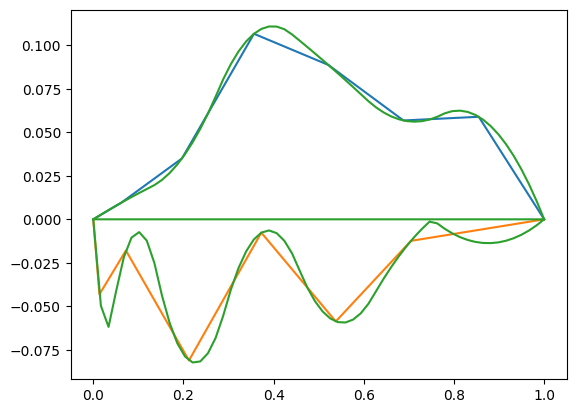

[[ 0.00000000e+00 -1.04706231e-19]
 [ 1.69491525e-02  2.69881061e-03]
 [ 3.38983051e-02  5.32683612e-03]
 [ 5.08474576e-02  7.88407654e-03]
 [ 6.77966102e-02  1.03705319e-02]
 [ 8.47457627e-02  1.27862021e-02]
 [ 1.01694915e-01  1.51310872e-02]
 [ 1.18644068e-01  1.74051873e-02]
 [ 1.35593220e-01  1.96735818e-02]
 [ 1.52542373e-01  2.26825108e-02]
 [ 1.69491525e-01  2.66436520e-02]
 [ 1.86440678e-01  3.15570053e-02]
 [ 2.03389831e-01  3.74225708e-02]
 [ 2.20338983e-01  4.42403485e-02]
 [ 2.37288136e-01  5.20103383e-02]
 [ 2.54237288e-01  6.07325402e-02]
 [ 2.71186441e-01  7.04069543e-02]
 [ 2.88135593e-01  8.04670120e-02]
 [ 3.05084746e-01  8.91843277e-02]
 [ 3.22033898e-01  9.64391194e-02]
 [ 3.38983051e-01  1.02231387e-01]
 [ 3.55932203e-01  1.06561131e-01]
 [ 3.72881356e-01  1.09428351e-01]
 [ 3.89830508e-01  1.10833047e-01]
 [ 4.06779661e-01  1.10775218e-01]
 [ 4.23728814e-01  1.09254866e-01]
 [ 4.40677966e-01  1.06281034e-01]
 [ 4.57627119e-01  1.02697664e-01]
 [ 4.74576271e-01  9

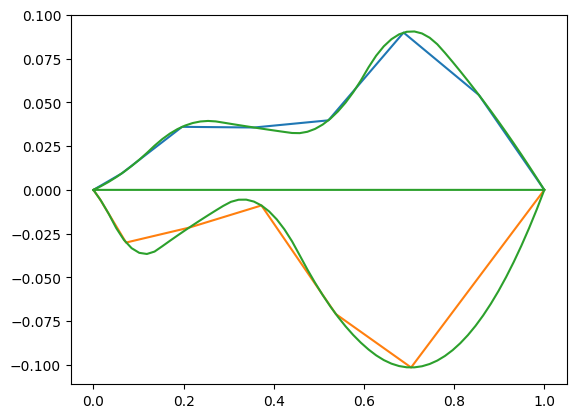

[[ 0.00000000e+00 -6.28237385e-19]
 [ 1.69491525e-02  2.13803201e-03]
 [ 3.38983051e-02  4.56789872e-03]
 [ 5.08474576e-02  7.28960013e-03]
 [ 6.77966102e-02  1.03031363e-02]
 [ 8.47457627e-02  1.36085071e-02]
 [ 1.01694915e-01  1.72057126e-02]
 [ 1.18644068e-01  2.10947528e-02]
 [ 1.35593220e-01  2.52207400e-02]
 [ 1.52542373e-01  2.89542993e-02]
 [ 1.69491525e-01  3.21169029e-02]
 [ 1.86440678e-01  3.47085509e-02]
 [ 2.03389831e-01  3.67292432e-02]
 [ 2.20338983e-01  3.81789799e-02]
 [ 2.37288136e-01  3.90577609e-02]
 [ 2.54237288e-01  3.93655863e-02]
 [ 2.71186441e-01  3.91024560e-02]
 [ 2.88135593e-01  3.84054762e-02]
 [ 3.05084746e-01  3.76929058e-02]
 [ 3.22033898e-01  3.69937311e-02]
 [ 3.38983051e-01  3.63079522e-02]
 [ 3.55932203e-01  3.56355692e-02]
 [ 3.72881356e-01  3.49765819e-02]
 [ 3.89830508e-01  3.43309905e-02]
 [ 4.06779661e-01  3.36987949e-02]
 [ 4.23728814e-01  3.30799951e-02]
 [ 4.40677966e-01  3.24799943e-02]
 [ 4.57627119e-01  3.24029935e-02]
 [ 4.74576271e-01  3

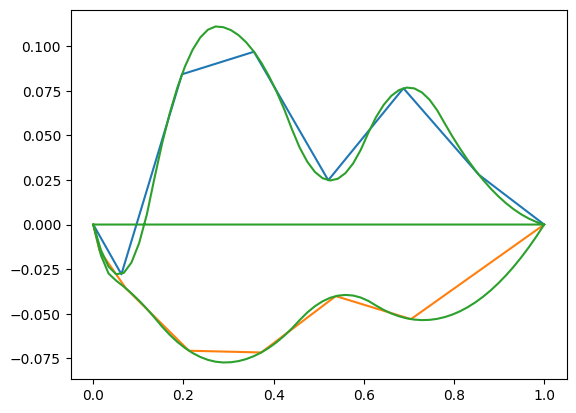

[[ 0.00000000e+00 -2.51294954e-18]
 [ 1.69491525e-02 -1.43143363e-02]
 [ 3.38983051e-02 -2.35977782e-02]
 [ 5.08474576e-02 -2.78503258e-02]
 [ 6.77966102e-02 -2.70719791e-02]
 [ 8.47457627e-02 -2.12627379e-02]
 [ 1.01694915e-01 -1.04226025e-02]
 [ 1.18644068e-01  5.44842736e-03]
 [ 1.35593220e-01  2.58699784e-02]
 [ 1.52542373e-01  4.53338136e-02]
 [ 1.69491525e-01  6.22774726e-02]
 [ 1.86440678e-01  7.67009553e-02]
 [ 2.03389831e-01  8.86042616e-02]
 [ 2.20338983e-01  9.79873918e-02]
 [ 2.37288136e-01  1.04850346e-01]
 [ 2.54237288e-01  1.09193123e-01]
 [ 2.71186441e-01  1.11015725e-01]
 [ 2.88135593e-01  1.10631901e-01]
 [ 3.05084746e-01  1.08998790e-01]
 [ 3.22033898e-01  1.06182723e-01]
 [ 3.38983051e-01  1.02183700e-01]
 [ 3.55932203e-01  9.70017223e-02]
 [ 3.72881356e-01  9.06367886e-02]
 [ 3.89830508e-01  8.30888992e-02]
 [ 4.06779661e-01  7.43580543e-02]
 [ 4.23728814e-01  6.44442537e-02]
 [ 4.40677966e-01  5.33694465e-02]
 [ 4.57627119e-01  4.31818237e-02]
 [ 4.74576271e-01  3

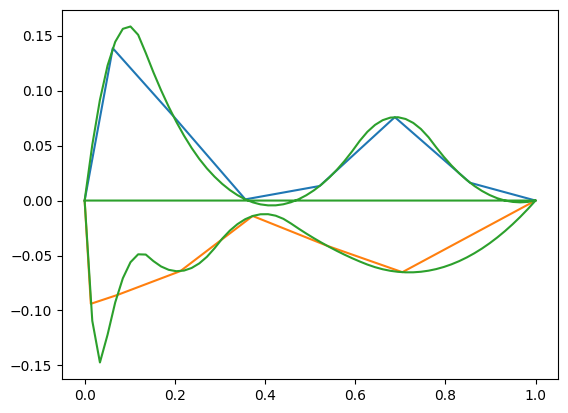

[[ 0.00000000e+00 -2.09412462e-19]
 [ 1.69491525e-02  5.06513331e-02]
 [ 3.38983051e-02  9.15997239e-02]
 [ 5.08474576e-02  1.22845172e-01]
 [ 6.77966102e-02  1.44387678e-01]
 [ 8.47457627e-02  1.56227242e-01]
 [ 1.01694915e-01  1.58363863e-01]
 [ 1.18644068e-01  1.50797542e-01]
 [ 1.35593220e-01  1.34226303e-01]
 [ 1.52542373e-01  1.16654105e-01]
 [ 1.69491525e-01  1.00351341e-01]
 [ 1.86440678e-01  8.53180110e-02]
 [ 2.03389831e-01  7.15541155e-02]
 [ 2.20338983e-01  5.90596542e-02]
 [ 2.37288136e-01  4.78346272e-02]
 [ 2.54237288e-01  3.78790345e-02]
 [ 2.71186441e-01  2.91928760e-02]
 [ 2.88135593e-01  2.16984015e-02]
 [ 3.05084746e-01  1.51584246e-02]
 [ 3.22033898e-01  9.55650753e-03]
 [ 3.38983051e-01  4.89265031e-03]
 [ 3.55932203e-01  1.16685294e-03]
 [ 3.72881356e-01 -1.62088458e-03]
 [ 3.89830508e-01 -3.47056225e-03]
 [ 4.06779661e-01 -4.38218007e-03]
 [ 4.23728814e-01 -4.35573804e-03]
 [ 4.40677966e-01 -3.39165610e-03]
 [ 4.57627119e-01 -1.52912120e-03]
 [ 4.74576271e-01  1

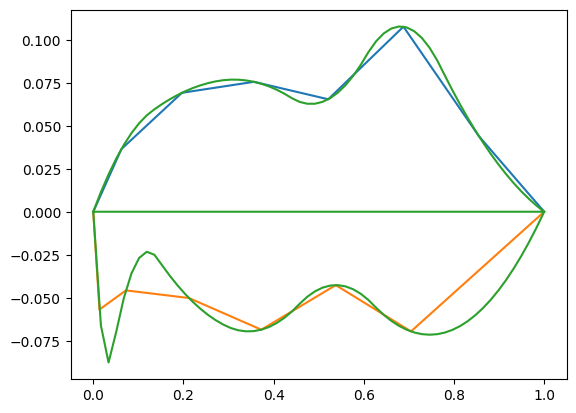

[[ 0.00000000e+00  8.37649847e-19]
 [ 1.69491525e-02  1.14163536e-02]
 [ 3.38983051e-02  2.16953859e-02]
 [ 5.08474576e-02  3.08370968e-02]
 [ 6.77966102e-02  3.88414864e-02]
 [ 8.47457627e-02  4.57085546e-02]
 [ 1.01694915e-01  5.14383015e-02]
 [ 1.18644068e-01  5.60307271e-02]
 [ 1.35593220e-01  5.95397141e-02]
 [ 1.52542373e-01  6.25831139e-02]
 [ 1.69491525e-01  6.53361855e-02]
 [ 1.86440678e-01  6.77989289e-02]
 [ 2.03389831e-01  6.99713442e-02]
 [ 2.20338983e-01  7.18534312e-02]
 [ 2.37288136e-01  7.34451901e-02]
 [ 2.54237288e-01  7.47466207e-02]
 [ 2.71186441e-01  7.57577232e-02]
 [ 2.88135593e-01  7.64588816e-02]
 [ 3.05084746e-01  7.67902553e-02]
 [ 3.22033898e-01  7.67476972e-02]
 [ 3.38983051e-01  7.63312072e-02]
 [ 3.55932203e-01  7.55407854e-02]
 [ 3.72881356e-01  7.43764318e-02]
 [ 3.89830508e-01  7.28381464e-02]
 [ 4.06779661e-01  7.09259292e-02]
 [ 4.23728814e-01  6.86397801e-02]
 [ 4.40677966e-01  6.59890245e-02]
 [ 4.57627119e-01  6.38438688e-02]
 [ 4.74576271e-01  6

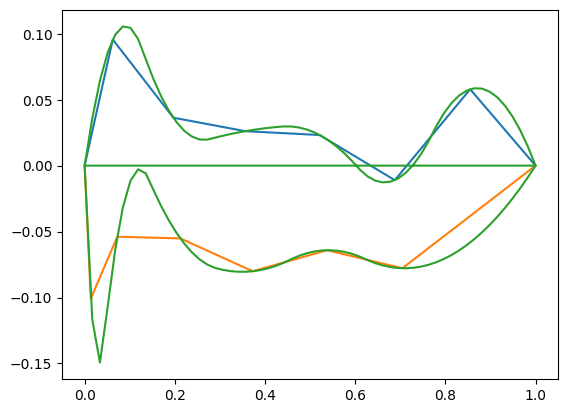

[[ 0.00000000e+00  2.87942135e-18]
 [ 1.69491525e-02  3.58794949e-02]
 [ 3.38983051e-02  6.43690757e-02]
 [ 5.08474576e-02  8.54687422e-02]
 [ 6.77966102e-02  9.91784945e-02]
 [ 8.47457627e-02  1.05498333e-01]
 [ 1.01694915e-01  1.04428256e-01]
 [ 1.18644068e-01  9.59682662e-02]
 [ 1.35593220e-01  8.07239645e-02]
 [ 1.52542373e-01  6.56395454e-02]
 [ 1.69491525e-01  5.26847911e-02]
 [ 1.86440678e-01  4.18597017e-02]
 [ 2.03389831e-01  3.31642771e-02]
 [ 2.20338983e-01  2.65985174e-02]
 [ 2.37288136e-01  2.21624225e-02]
 [ 2.54237288e-01  1.98559925e-02]
 [ 2.71186441e-01  1.96792273e-02]
 [ 2.88135593e-01  2.11051306e-02]
 [ 3.05084746e-01  2.25260371e-02]
 [ 3.22033898e-01  2.38305308e-02]
 [ 3.38983051e-01  2.50186118e-02]
 [ 3.55932203e-01  2.60902800e-02]
 [ 3.72881356e-01  2.70455355e-02]
 [ 3.89830508e-01  2.78843783e-02]
 [ 4.06779661e-01  2.86068084e-02]
 [ 4.23728814e-01  2.92128257e-02]
 [ 4.40677966e-01  2.96984910e-02]
 [ 4.57627119e-01  2.96962049e-02]
 [ 4.74576271e-01  2

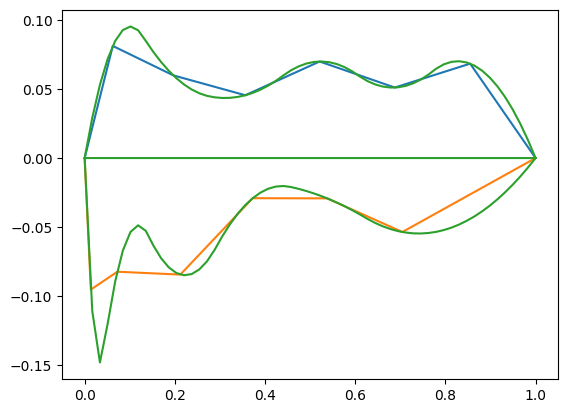

[[ 0.00000000e+00 -3.14118693e-18]
 [ 1.69491525e-02  2.92082957e-02]
 [ 3.38983051e-02  5.30889906e-02]
 [ 5.08474576e-02  7.16420846e-02]
 [ 6.77966102e-02  8.48675779e-02]
 [ 8.47457627e-02  9.27654703e-02]
 [ 1.01694915e-01  9.53357619e-02]
 [ 1.18644068e-01  9.25784528e-02]
 [ 1.35593220e-01  8.48889950e-02]
 [ 1.52542373e-01  7.68018736e-02]
 [ 1.69491525e-01  6.96033357e-02]
 [ 1.86440678e-01  6.32933812e-02]
 [ 2.03389831e-01  5.78720101e-02]
 [ 2.20338983e-01  5.33392223e-02]
 [ 2.37288136e-01  4.96950180e-02]
 [ 2.54237288e-01  4.69393971e-02]
 [ 2.71186441e-01  4.50723596e-02]
 [ 2.88135593e-01  4.40168562e-02]
 [ 3.05084746e-01  4.35378387e-02]
 [ 3.22033898e-01  4.36190176e-02]
 [ 3.38983051e-01  4.42603929e-02]
 [ 3.55932203e-01  4.54619645e-02]
 [ 3.72881356e-01  4.72237326e-02]
 [ 3.89830508e-01  4.95456970e-02]
 [ 4.06779661e-01  5.24278579e-02]
 [ 4.23728814e-01  5.58702151e-02]
 [ 4.40677966e-01  5.98637445e-02]
 [ 4.57627119e-01  6.35663423e-02]
 [ 4.74576271e-01  6

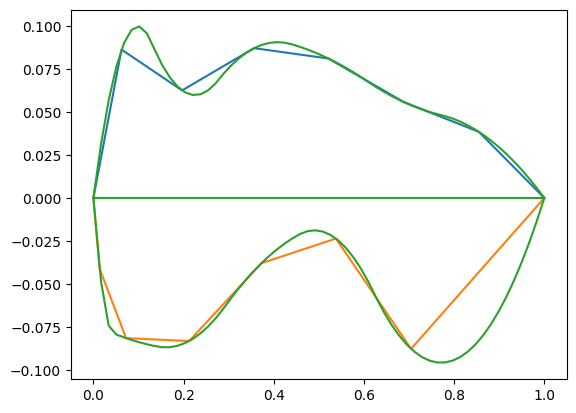

[[ 0.00000000e+00  3.76942431e-18]
 [ 1.69491525e-02  3.13179326e-02]
 [ 3.38983051e-02  5.67548078e-02]
 [ 5.08474576e-02  7.63106254e-02]
 [ 6.77966102e-02  8.99853857e-02]
 [ 8.47457627e-02  9.77790885e-02]
 [ 1.01694915e-01  9.96917338e-02]
 [ 1.18644068e-01  9.57233217e-02]
 [ 1.35593220e-01  8.63681609e-02]
 [ 1.52542373e-01  7.72942843e-02]
 [ 1.69491525e-01  7.01094796e-02]
 [ 1.86440678e-01  6.48137468e-02]
 [ 2.03389831e-01  6.14070859e-02]
 [ 2.20338983e-01  5.98894969e-02]
 [ 2.37288136e-01  6.02609799e-02]
 [ 2.54237288e-01  6.25215347e-02]
 [ 2.71186441e-01  6.66711615e-02]
 [ 2.88135593e-01  7.20956456e-02]
 [ 3.05084746e-01  7.69212518e-02]
 [ 3.22033898e-01  8.10181248e-02]
 [ 3.38983051e-01  8.43862647e-02]
 [ 3.55932203e-01  8.70256715e-02]
 [ 3.72881356e-01  8.89363451e-02]
 [ 3.89830508e-01  9.01182855e-02]
 [ 4.06779661e-01  9.05714928e-02]
 [ 4.23728814e-01  9.02959670e-02]
 [ 4.40677966e-01  8.92952484e-02]
 [ 4.57627119e-01  8.78997102e-02]
 [ 4.74576271e-01  8

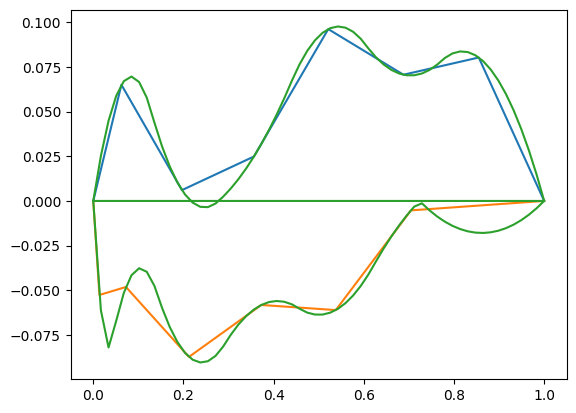

[[ 0.00000000e+00  9.42356078e-19]
 [ 1.69491525e-02  2.52519243e-02]
 [ 3.38983051e-02  4.48376032e-02]
 [ 5.08474576e-02  5.87570364e-02]
 [ 6.77966102e-02  6.70102242e-02]
 [ 8.47457627e-02  6.95971663e-02]
 [ 1.01694915e-01  6.65178630e-02]
 [ 1.18644068e-01  5.77723141e-02]
 [ 1.35593220e-01  4.38605783e-02]
 [ 1.52542373e-01  3.05166187e-02]
 [ 1.69491525e-01  1.93669249e-02]
 [ 1.86440678e-01  1.04114969e-02]
 [ 2.03389831e-01  3.65033467e-03]
 [ 2.20338983e-01 -9.16561800e-04]
 [ 2.37288136e-01 -3.28919250e-03]
 [ 2.54237288e-01 -3.46755743e-03]
 [ 2.71186441e-01 -1.45165658e-03]
 [ 2.88135593e-01  2.39826785e-03]
 [ 3.05084746e-01  6.98325390e-03]
 [ 3.22033898e-01  1.22271404e-02]
 [ 3.38983051e-01  1.81299272e-02]
 [ 3.55932203e-01  2.46916145e-02]
 [ 3.72881356e-01  3.19122022e-02]
 [ 3.89830508e-01  3.97916903e-02]
 [ 4.06779661e-01  4.83300788e-02]
 [ 4.23728814e-01  5.75273677e-02]
 [ 4.40677966e-01  6.73688296e-02]
 [ 4.57627119e-01  7.64801679e-02]
 [ 4.74576271e-01  8

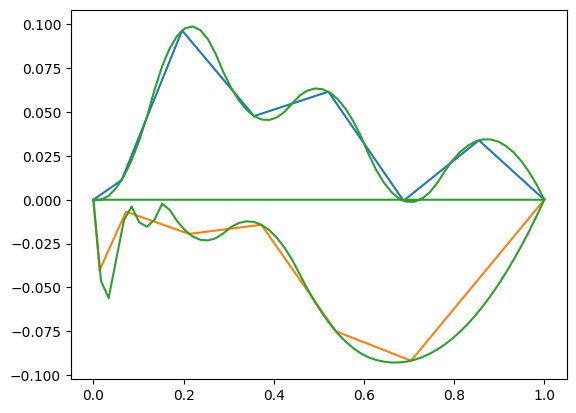

[[ 0.00000000e+00 -4.18824924e-19]
 [ 1.69491525e-02 -2.07789358e-05]
 [ 3.38983051e-02  2.21419984e-03]
 [ 5.08474576e-02  6.70493633e-03]
 [ 6.77966102e-02  1.34514305e-02]
 [ 8.47457627e-02  2.24536824e-02]
 [ 1.01694915e-01  3.37116920e-02]
 [ 1.18644068e-01  4.72254594e-02]
 [ 1.35593220e-01  6.26537914e-02]
 [ 1.52542373e-01  7.60843702e-02]
 [ 1.69491525e-01  8.64074322e-02]
 [ 1.86440678e-01  9.36229773e-02]
 [ 2.03389831e-01  9.77310055e-02]
 [ 2.20338983e-01  9.87315169e-02]
 [ 2.37288136e-01  9.66245114e-02]
 [ 2.54237288e-01  9.14099891e-02]
 [ 2.71186441e-01  8.30879499e-02]
 [ 2.88135593e-01  7.27885206e-02]
 [ 3.05084746e-01  6.39592880e-02]
 [ 3.22033898e-01  5.68391799e-02]
 [ 3.38983051e-01  5.14281963e-02]
 [ 3.55932203e-01  4.77263371e-02]
 [ 3.72881356e-01  4.57336024e-02]
 [ 3.89830508e-01  4.54499922e-02]
 [ 4.06779661e-01  4.68755064e-02]
 [ 4.23728814e-01  5.00101450e-02]
 [ 4.40677966e-01  5.48323375e-02]
 [ 4.57627119e-01  5.93292013e-02]
 [ 4.74576271e-01  6

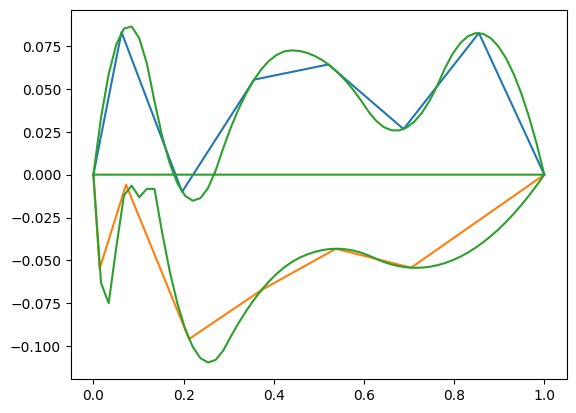

[[ 0.00000000e+00  5.44472401e-18]
 [ 1.69491525e-02  3.33222014e-02]
 [ 3.38983051e-02  5.86186173e-02]
 [ 5.08474576e-02  7.58892477e-02]
 [ 6.77966102e-02  8.51340927e-02]
 [ 8.47457627e-02  8.63531523e-02]
 [ 1.01694915e-01  7.95464264e-02]
 [ 1.18644068e-01  6.47139151e-02]
 [ 1.35593220e-01  4.26432568e-02]
 [ 1.52542373e-01  2.23659726e-02]
 [ 1.69491525e-01  6.44393360e-03]
 [ 1.86440678e-01 -5.12286017e-03]
 [ 2.03389831e-01 -1.23344087e-02]
 [ 2.20338983e-01 -1.51907121e-02]
 [ 2.37288136e-01 -1.36917702e-02]
 [ 2.54237288e-01 -7.83758311e-03]
 [ 2.71186441e-01  2.37184920e-03]
 [ 2.88135593e-01  1.55779500e-02]
 [ 3.05084746e-01  2.76362183e-02]
 [ 3.22033898e-01  3.82594283e-02]
 [ 3.38983051e-01  4.74475801e-02]
 [ 3.55932203e-01  5.52006735e-02]
 [ 3.72881356e-01  6.15187086e-02]
 [ 3.89830508e-01  6.64016855e-02]
 [ 4.06779661e-01  6.98496040e-02]
 [ 4.23728814e-01  7.18624643e-02]
 [ 4.40677966e-01  7.24449629e-02]
 [ 4.57627119e-01  7.20353755e-02]
 [ 4.74576271e-01  7

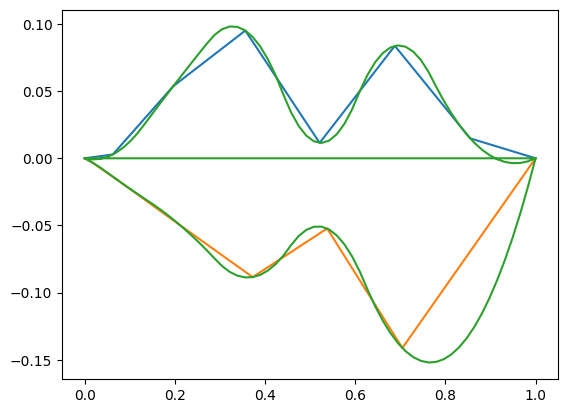

[[ 0.00000000e+00 -6.28237385e-19]
 [ 1.69491525e-02 -8.37714224e-04]
 [ 3.38983051e-02 -4.82201919e-04]
 [ 5.08474576e-02  1.06653691e-03]
 [ 6.77966102e-02  3.80850228e-03]
 [ 8.47457627e-02  7.74369417e-03]
 [ 1.01694915e-01  1.28721126e-02]
 [ 1.18644068e-01  1.91937575e-02]
 [ 1.35593220e-01  2.66277519e-02]
 [ 1.52542373e-01  3.42467116e-02]
 [ 1.69491525e-01  4.17875760e-02]
 [ 1.86440678e-01  4.92503451e-02]
 [ 2.03389831e-01  5.66350188e-02]
 [ 2.20338983e-01  6.39415971e-02]
 [ 2.37288136e-01  7.11700801e-02]
 [ 2.54237288e-01  7.83204678e-02]
 [ 2.71186441e-01  8.53927601e-02]
 [ 2.88135593e-01  9.18648660e-02]
 [ 3.05084746e-01  9.61440840e-02]
 [ 3.22033898e-01  9.81200354e-02]
 [ 3.38983051e-01  9.77927201e-02]
 [ 3.55932203e-01  9.51621382e-02]
 [ 3.72881356e-01  9.02282896e-02]
 [ 3.89830508e-01  8.29911744e-02]
 [ 4.06779661e-01  7.34507925e-02]
 [ 4.23728814e-01  6.16071440e-02]
 [ 4.40677966e-01  4.74943204e-02]
 [ 4.57627119e-01  3.42936045e-02]
 [ 4.74576271e-01  2

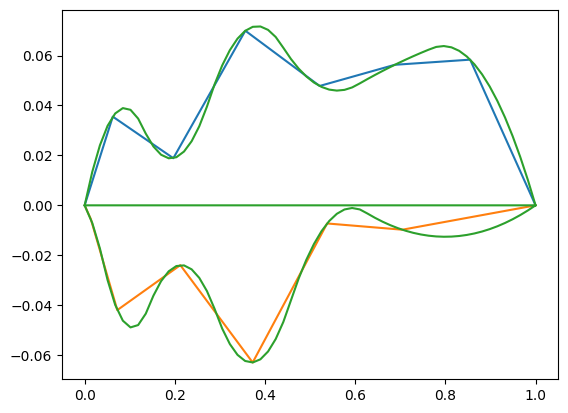

[[ 0.00000000e+00  1.89780044e-19]
 [ 1.69491525e-02  1.34387244e-02]
 [ 3.38983051e-02  2.40526298e-02]
 [ 5.08474576e-02  3.18417162e-02]
 [ 6.77966102e-02  3.68059837e-02]
 [ 8.47457627e-02  3.89454322e-02]
 [ 1.01694915e-01  3.82600617e-02]
 [ 1.18644068e-01  3.47498723e-02]
 [ 1.35593220e-01  2.87127193e-02]
 [ 1.52542373e-01  2.35639865e-02]
 [ 1.69491525e-01  2.02724778e-02]
 [ 1.86440678e-01  1.88381931e-02]
 [ 2.03389831e-01  1.92611325e-02]
 [ 2.20338983e-01  2.15412959e-02]
 [ 2.37288136e-01  2.56786834e-02]
 [ 2.54237288e-01  3.16732949e-02]
 [ 2.71186441e-01  3.95251306e-02]
 [ 2.88135593e-01  4.84481966e-02]
 [ 3.05084746e-01  5.60447253e-02]
 [ 3.22033898e-01  6.21485446e-02]
 [ 3.38983051e-01  6.67596543e-02]
 [ 3.55932203e-01  6.98780546e-02]
 [ 3.72881356e-01  7.15037454e-02]
 [ 3.89830508e-01  7.16367267e-02]
 [ 4.06779661e-01  7.02769985e-02]
 [ 4.23728814e-01  6.74245608e-02]
 [ 4.40677966e-01  6.30934272e-02]
 [ 4.57627119e-01  5.85912905e-02]
 [ 4.74576271e-01  5

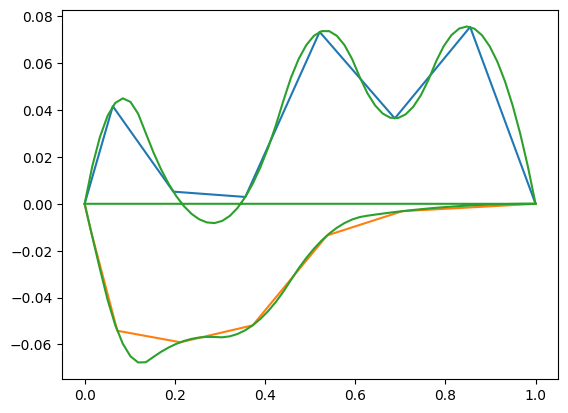

[[ 0.00000000e+00  4.97354597e-19]
 [ 1.69491525e-02  1.60163589e-02]
 [ 3.38983051e-02  2.85233211e-02]
 [ 5.08474576e-02  3.75208864e-02]
 [ 6.77966102e-02  4.30090550e-02]
 [ 8.47457627e-02  4.49878268e-02]
 [ 1.01694915e-01  4.34572017e-02]
 [ 1.18644068e-01  3.84171799e-02]
 [ 1.35593220e-01  3.01536652e-02]
 [ 1.52542373e-01  2.19449987e-02]
 [ 1.69491525e-01  1.47211108e-02]
 [ 1.86440678e-01  8.48200155e-03]
 [ 2.03389831e-01  3.22767099e-03]
 [ 2.20338983e-01 -1.04188091e-03]
 [ 2.37288136e-01 -4.32665415e-03]
 [ 2.54237288e-01 -6.62664872e-03]
 [ 2.71186441e-01 -7.94186463e-03]
 [ 2.88135593e-01 -8.21797648e-03]
 [ 3.05084746e-01 -7.28925815e-03]
 [ 3.22033898e-01 -5.14422434e-03]
 [ 3.38983051e-01 -1.78287505e-03]
 [ 3.55932203e-01  2.79478971e-03]
 [ 3.72881356e-01  8.58876996e-03]
 [ 3.89830508e-01  1.55990657e-02]
 [ 4.06779661e-01  2.38256769e-02]
 [ 4.23728814e-01  3.32686036e-02]
 [ 4.40677966e-01  4.39072574e-02]
 [ 4.57627119e-01  5.38204201e-02]
 [ 4.74576271e-01  6

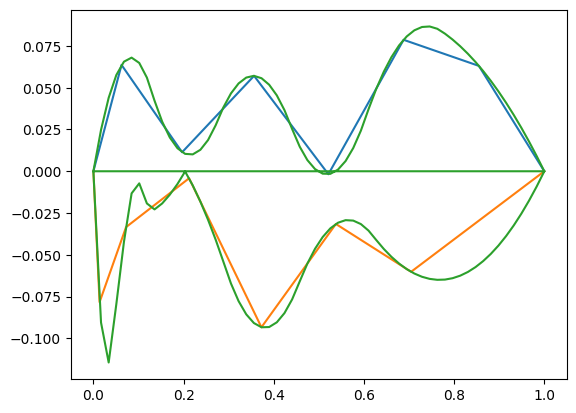

[[ 0.00000000e+00  2.30353708e-18]
 [ 1.69491525e-02  2.47893173e-02]
 [ 3.38983051e-02  4.39849529e-02]
 [ 5.08474576e-02  5.75869070e-02]
 [ 6.77966102e-02  6.55951795e-02]
 [ 8.47457627e-02  6.80097705e-02]
 [ 1.01694915e-01  6.48306798e-02]
 [ 1.18644068e-01  5.60579076e-02]
 [ 1.35593220e-01  4.22419341e-02]
 [ 1.52542373e-01  2.96948873e-02]
 [ 1.69491525e-01  2.02072582e-02]
 [ 1.86440678e-01  1.37790469e-02]
 [ 2.03389831e-01  1.04102533e-02]
 [ 2.20338983e-01  1.01008775e-02]
 [ 2.37288136e-01  1.28509195e-02]
 [ 2.54237288e-01  1.86603792e-02]
 [ 2.71186441e-01  2.75292566e-02]
 [ 2.88135593e-01  3.81608576e-02]
 [ 3.05084746e-01  4.65994612e-02]
 [ 3.22033898e-01  5.25709246e-02]
 [ 3.38983051e-01  5.60752477e-02]
 [ 3.55932203e-01  5.71124306e-02]
 [ 3.72881356e-01  5.56824733e-02]
 [ 3.89830508e-01  5.17853757e-02]
 [ 4.06779661e-01  4.54211379e-02]
 [ 4.23728814e-01  3.65897599e-02]
 [ 4.40677966e-01  2.53240552e-02]
 [ 4.57627119e-01  1.46860483e-02]
 [ 4.74576271e-01  6

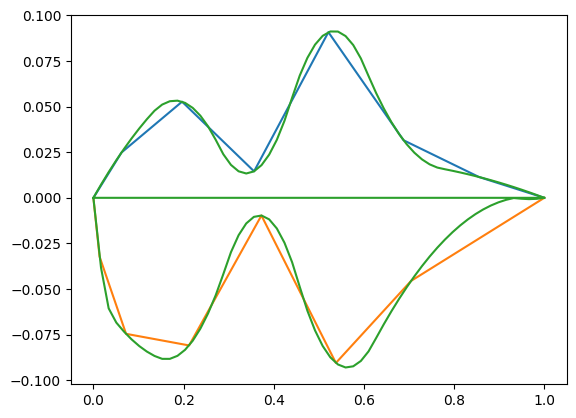

[[ 0.00000000e+00 -2.72236200e-18]
 [ 1.69491525e-02  7.23338692e-03]
 [ 3.38983051e-02  1.41089827e-02]
 [ 5.08474576e-02  2.06267872e-02]
 [ 6.77966102e-02  2.67868005e-02]
 [ 8.47457627e-02  3.25890227e-02]
 [ 1.01694915e-01  3.80334536e-02]
 [ 1.18644068e-01  4.31200933e-02]
 [ 1.35593220e-01  4.77743704e-02]
 [ 1.52542373e-01  5.11412052e-02]
 [ 1.69491525e-01  5.29780466e-02]
 [ 1.86440678e-01  5.32848948e-02]
 [ 2.03389831e-01  5.20617496e-02]
 [ 2.20338983e-01  4.93086112e-02]
 [ 2.37288136e-01  4.50254795e-02]
 [ 2.54237288e-01  3.92123545e-02]
 [ 2.71186441e-01  3.18692362e-02]
 [ 2.88135593e-01  2.38998598e-02]
 [ 3.05084746e-01  1.80611776e-02]
 [ 3.22033898e-01  1.45442544e-02]
 [ 3.38983051e-01  1.33490902e-02]
 [ 3.55932203e-01  1.44756849e-02]
 [ 3.72881356e-01  1.79240387e-02]
 [ 3.89830508e-01  2.36941514e-02]
 [ 4.06779661e-01  3.17860230e-02]
 [ 4.23728814e-01  4.21996537e-02]
 [ 4.40677966e-01  5.49044183e-02]
 [ 4.57627119e-01  6.70425201e-02]
 [ 4.74576271e-01  7

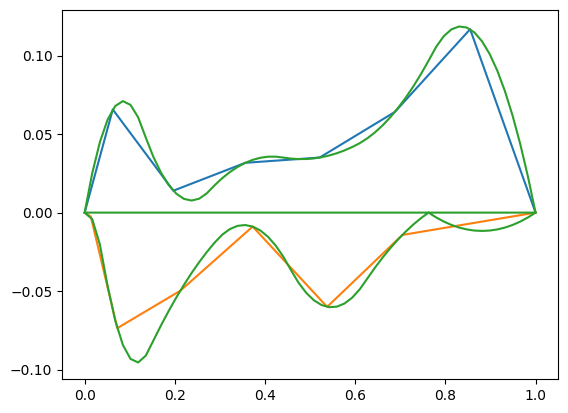

[[ 0.00000000e+00  5.02589908e-18]
 [ 1.69491525e-02  2.52588165e-02]
 [ 3.38983051e-02  4.49884661e-02]
 [ 5.08474576e-02  5.91889490e-02]
 [ 6.77966102e-02  6.78602652e-02]
 [ 8.47457627e-02  7.10024145e-02]
 [ 1.01694915e-01  6.86153970e-02]
 [ 1.18644068e-01  6.06992128e-02]
 [ 1.35593220e-01  4.77489012e-02]
 [ 1.52542373e-01  3.54408715e-02]
 [ 1.69491525e-01  2.53852876e-02]
 [ 1.86440678e-01  1.75821496e-02]
 [ 2.03389831e-01  1.20314574e-02]
 [ 2.20338983e-01  8.73321112e-03]
 [ 2.37288136e-01  7.68741066e-03]
 [ 2.54237288e-01  8.89405606e-03]
 [ 2.71186441e-01  1.23531473e-02]
 [ 2.88135593e-01  1.73853242e-02]
 [ 3.05084746e-01  2.19181173e-02]
 [ 3.22033898e-01  2.58078985e-02]
 [ 3.38983051e-01  2.90546677e-02]
 [ 3.55932203e-01  3.16584250e-02]
 [ 3.72881356e-01  3.36191704e-02]
 [ 3.89830508e-01  3.49369038e-02]
 [ 4.06779661e-01  3.56116253e-02]
 [ 4.23728814e-01  3.56433349e-02]
 [ 4.40677966e-01  3.50384093e-02]
 [ 4.57627119e-01  3.43918995e-02]
 [ 4.74576271e-01  3

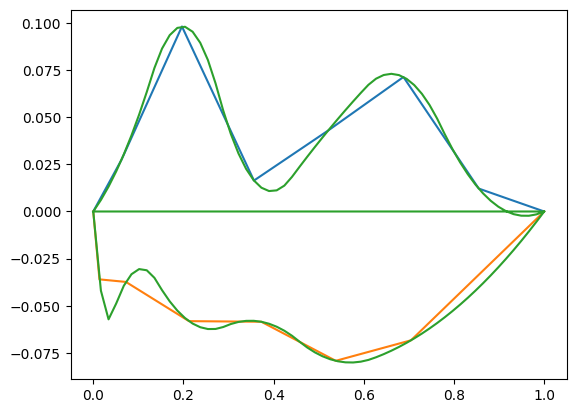

[[ 0.00000000e+00 -1.25647477e-18]
 [ 1.69491525e-02  6.11215432e-03]
 [ 3.38983051e-02  1.32061840e-02]
 [ 5.08474576e-02  2.12820890e-02]
 [ 6.77966102e-02  3.03398694e-02]
 [ 8.47457627e-02  4.03795251e-02]
 [ 1.01694915e-01  5.14010562e-02]
 [ 1.18644068e-01  6.34044626e-02]
 [ 1.35593220e-01  7.61207752e-02]
 [ 1.52542373e-01  8.64658375e-02]
 [ 1.69491525e-01  9.35648012e-02]
 [ 1.86440678e-01  9.74176662e-02]
 [ 2.03389831e-01  9.80244324e-02]
 [ 2.20338983e-01  9.53851000e-02]
 [ 2.37288136e-01  8.94996689e-02]
 [ 2.54237288e-01  8.03681391e-02]
 [ 2.71186441e-01  6.79905107e-02]
 [ 2.88135593e-01  5.36309364e-02]
 [ 3.05084746e-01  4.11458662e-02]
 [ 3.22033898e-01  3.08025630e-02]
 [ 3.38983051e-01  2.26010269e-02]
 [ 3.55932203e-01  1.65412578e-02]
 [ 3.72881356e-01  1.26232558e-02]
 [ 3.89830508e-01  1.08470208e-02]
 [ 4.06779661e-01  1.12125529e-02]
 [ 4.23728814e-01  1.37198520e-02]
 [ 4.40677966e-01  1.83543977e-02]
 [ 4.57627119e-01  2.37611948e-02]
 [ 4.74576271e-01  2

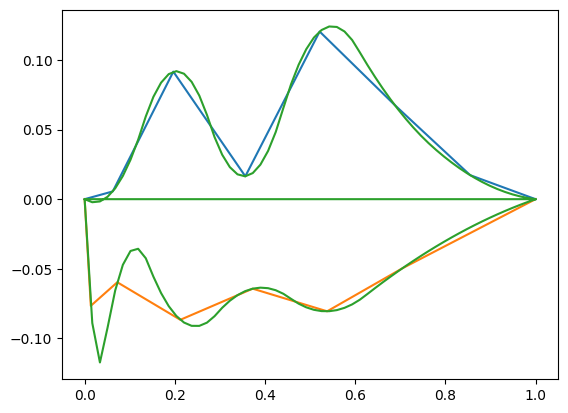

[[ 0.00000000e+00 -2.51294954e-18]
 [ 1.69491525e-02 -2.19743835e-03]
 [ 3.38983051e-02 -1.62644078e-03]
 [ 5.08474576e-02  1.71299271e-03]
 [ 6.77966102e-02  7.82086213e-03]
 [ 8.47457627e-02  1.66971675e-02]
 [ 1.01694915e-01  2.83419087e-02]
 [ 1.18644068e-01  4.27550859e-02]
 [ 1.35593220e-01  5.95060318e-02]
 [ 1.52542373e-01  7.36564653e-02]
 [ 1.69491525e-01  8.38055993e-02]
 [ 1.86440678e-01  8.99534337e-02]
 [ 2.03389831e-01  9.20999684e-02]
 [ 2.20338983e-01  9.02452036e-02]
 [ 2.37288136e-01  8.43891392e-02]
 [ 2.54237288e-01  7.45317751e-02]
 [ 2.71186441e-01  6.06731115e-02]
 [ 2.88135593e-01  4.46320873e-02]
 [ 3.05084746e-01  3.19575936e-02]
 [ 3.22033898e-01  2.30341845e-02]
 [ 3.38983051e-01  1.78618600e-02]
 [ 3.55932203e-01  1.64406201e-02]
 [ 3.72881356e-01  1.87704648e-02]
 [ 3.89830508e-01  2.48513941e-02]
 [ 4.06779661e-01  3.46834080e-02]
 [ 4.23728814e-01  4.82665066e-02]
 [ 4.40677966e-01  6.55579290e-02]
 [ 4.57627119e-01  8.25674213e-02]
 [ 4.74576271e-01  9

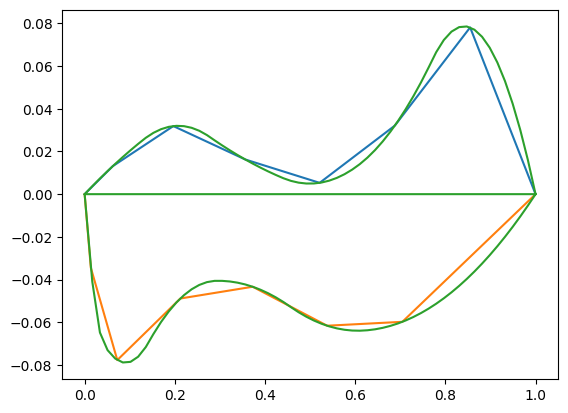

[[ 0.00000000e+00  4.18824924e-19]
 [ 1.69491525e-02  3.72259520e-03]
 [ 3.38983051e-02  7.32463164e-03]
 [ 5.08474576e-02  1.08061093e-02]
 [ 6.77966102e-02  1.41670283e-02]
 [ 8.47457627e-02  1.74073884e-02]
 [ 1.01694915e-01  2.05271898e-02]
 [ 1.18644068e-01  2.35264325e-02]
 [ 1.35593220e-01  2.63733493e-02]
 [ 1.52542373e-01  2.87036800e-02]
 [ 1.69491525e-01  3.04140990e-02]
 [ 1.86440678e-01  3.15046064e-02]
 [ 2.03389831e-01  3.19752021e-02]
 [ 2.20338983e-01  3.18258860e-02]
 [ 2.37288136e-01  3.10566583e-02]
 [ 2.54237288e-01  2.96675189e-02]
 [ 2.71186441e-01  2.76584678e-02]
 [ 2.88135593e-01  2.51995416e-02]
 [ 3.05084746e-01  2.28094571e-02]
 [ 3.22033898e-01  2.05241630e-02]
 [ 3.38983051e-01  1.83436592e-02]
 [ 3.55932203e-01  1.62679457e-02]
 [ 3.72881356e-01  1.42970226e-02]
 [ 3.89830508e-01  1.24308898e-02]
 [ 4.06779661e-01  1.06695473e-02]
 [ 4.23728814e-01  9.01299515e-03]
 [ 4.40677966e-01  7.46328909e-03]
 [ 4.57627119e-01  6.21226334e-03]
 [ 4.74576271e-01  5

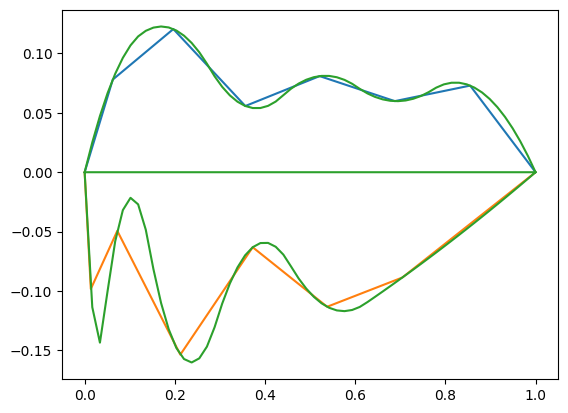

[[ 0.00000000e+00 -4.18824924e-19]
 [ 1.69491525e-02  2.50988090e-02]
 [ 3.38983051e-02  4.72739591e-02]
 [ 5.08474576e-02  6.65254501e-02]
 [ 6.77966102e-02  8.28532823e-02]
 [ 8.47457627e-02  9.62574554e-02]
 [ 1.01694915e-01  1.06737970e-01]
 [ 1.18644068e-01  1.14294825e-01]
 [ 1.35593220e-01  1.19001961e-01]
 [ 1.52542373e-01  1.21707217e-01]
 [ 1.69491525e-01  1.22651089e-01]
 [ 1.86440678e-01  1.21833578e-01]
 [ 2.03389831e-01  1.19254684e-01]
 [ 2.20338983e-01  1.14914406e-01]
 [ 2.37288136e-01  1.08812744e-01]
 [ 2.54237288e-01  1.00949699e-01]
 [ 2.71186441e-01  9.13252706e-02]
 [ 2.88135593e-01  8.07731784e-02]
 [ 3.05084746e-01  7.18367842e-02]
 [ 3.22033898e-01  6.46923504e-02]
 [ 3.38983051e-01  5.93398768e-02]
 [ 3.55932203e-01  5.57793636e-02]
 [ 3.72881356e-01  5.40108107e-02]
 [ 3.89830508e-01  5.40342181e-02]
 [ 4.06779661e-01  5.58495858e-02]
 [ 4.23728814e-01  5.94569138e-02]
 [ 4.40677966e-01  6.48376572e-02]
 [ 4.57627119e-01  7.02612785e-02]
 [ 4.74576271e-01  7

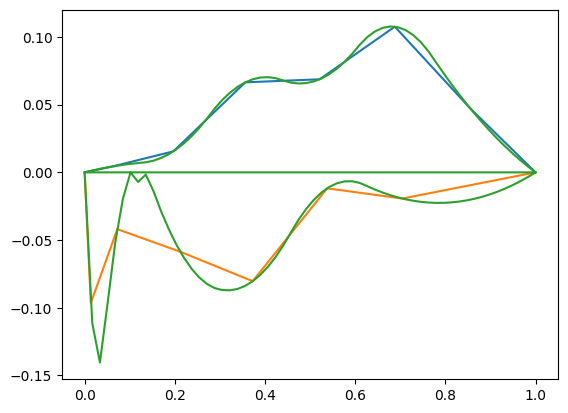

[[ 0.00000000e+00  5.23531155e-20]
 [ 1.69491525e-02  1.35952060e-03]
 [ 3.38983051e-02  2.59421628e-03]
 [ 5.08474576e-02  3.70408705e-03]
 [ 6.77966102e-02  4.68913289e-03]
 [ 8.47457627e-02  5.54935382e-03]
 [ 1.01694915e-01  6.28474983e-03]
 [ 1.18644068e-01  6.89532092e-03]
 [ 1.35593220e-01  7.44114007e-03]
 [ 1.52542373e-01  8.61103908e-03]
 [ 1.69491525e-01  1.06004112e-02]
 [ 1.86440678e-01  1.34092564e-02]
 [ 2.03389831e-01  1.70375747e-02]
 [ 2.20338983e-01  2.14853660e-02]
 [ 2.37288136e-01  2.67526305e-02]
 [ 2.54237288e-01  3.28393681e-02]
 [ 2.71186441e-01  3.97455788e-02]
 [ 2.88135593e-01  4.70407145e-02]
 [ 3.05084746e-01  5.34113368e-02]
 [ 3.22033898e-01  5.87664207e-02]
 [ 3.38983051e-01  6.31059663e-02]
 [ 3.55932203e-01  6.64299734e-02]
 [ 3.72881356e-01  6.87384420e-02]
 [ 3.89830508e-01  7.00313723e-02]
 [ 4.06779661e-01  7.03087642e-02]
 [ 4.23728814e-01  6.95706176e-02]
 [ 4.40677966e-01  6.78295139e-02]
 [ 4.57627119e-01  6.62594825e-02]
 [ 4.74576271e-01  6

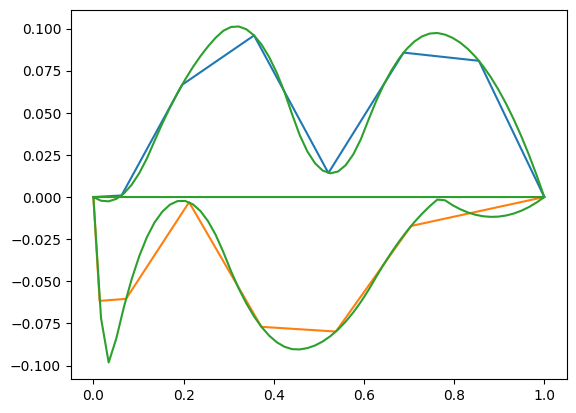

[[ 0.00000000e+00 -8.37649847e-19]
 [ 1.69491525e-02 -2.18675113e-03]
 [ 3.38983051e-02 -2.55479583e-03]
 [ 5.08474576e-02 -1.10413411e-03]
 [ 6.77966102e-02  2.16523404e-03]
 [ 8.47457627e-02  7.25330861e-03]
 [ 1.01694915e-01  1.41600896e-02]
 [ 1.18644068e-01  2.28855770e-02]
 [ 1.35593220e-01  3.32681340e-02]
 [ 1.52542373e-01  4.34543382e-02]
 [ 1.69491525e-01  5.29184499e-02]
 [ 1.86440678e-01  6.16604691e-02]
 [ 2.03389831e-01  6.96803958e-02]
 [ 2.20338983e-01  7.69782300e-02]
 [ 2.37288136e-01  8.35539717e-02]
 [ 2.54237288e-01  8.94076209e-02]
 [ 2.71186441e-01  9.45391776e-02]
 [ 2.88135593e-01  9.86631643e-02]
 [ 3.05084746e-01  1.00908698e-01]
 [ 3.22033898e-01  1.01215424e-01]
 [ 3.38983051e-01  9.95833414e-02]
 [ 3.55932203e-01  9.60124513e-02]
 [ 3.72881356e-01  9.05027534e-02]
 [ 3.89830508e-01  8.30542476e-02]
 [ 4.06779661e-01  7.36669340e-02]
 [ 4.23728814e-01  6.23408124e-02]
 [ 4.40677966e-01  4.91056232e-02]
 [ 4.57627119e-01  3.67366025e-02]
 [ 4.74576271e-01  2

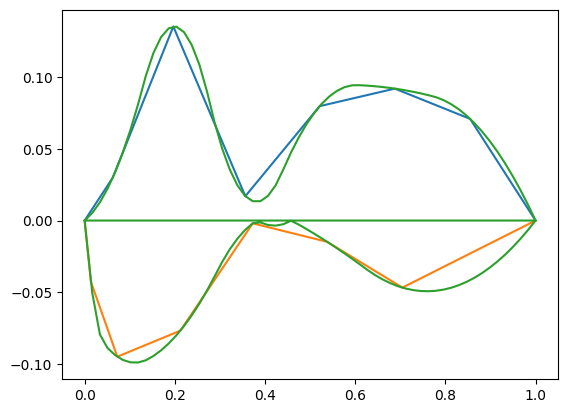

[[ 0.00000000e+00 -2.51294954e-18]
 [ 1.69491525e-02  5.30157357e-03]
 [ 3.38983051e-02  1.26968931e-02]
 [ 5.08474576e-02  2.21859585e-02]
 [ 6.77966102e-02  3.37687699e-02]
 [ 8.47457627e-02  4.74453272e-02]
 [ 1.01694915e-01  6.32156305e-02]
 [ 1.18644068e-01  8.10796797e-02]
 [ 1.35593220e-01  1.00589120e-01]
 [ 1.52542373e-01  1.16602854e-01]
 [ 1.69491525e-01  1.27662565e-01]
 [ 1.86440678e-01  1.33768251e-01]
 [ 2.03389831e-01  1.34919914e-01]
 [ 2.20338983e-01  1.31117553e-01]
 [ 2.37288136e-01  1.22361168e-01]
 [ 2.54237288e-01  1.08650759e-01]
 [ 2.71186441e-01  8.99863259e-02]
 [ 2.88135593e-01  6.83929014e-02]
 [ 3.05084746e-01  5.00480881e-02]
 [ 3.22033898e-01  3.53800117e-02]
 [ 3.38983051e-01  2.43886722e-02]
 [ 3.55932203e-01  1.70740696e-02]
 [ 3.72881356e-01  1.34362038e-02]
 [ 3.89830508e-01  1.34750750e-02]
 [ 4.06779661e-01  1.71906831e-02]
 [ 4.23728814e-01  2.45830281e-02]
 [ 4.40677966e-01  3.56200882e-02]
 [ 4.57627119e-01  4.73137212e-02]
 [ 4.74576271e-01  5

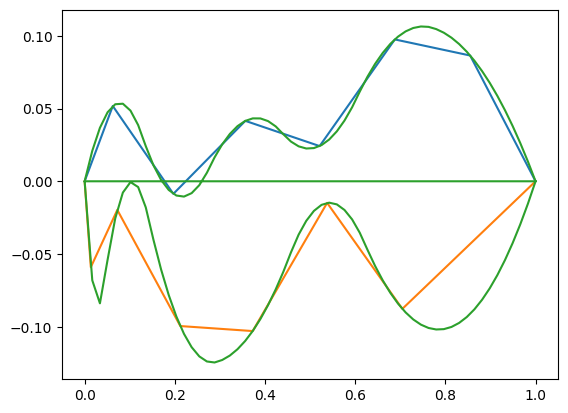

[[ 0.00000000e+00  3.14118693e-18]
 [ 1.69491525e-02  2.09515126e-02]
 [ 3.38983051e-02  3.67600321e-02]
 [ 5.08474576e-02  4.74255584e-02]
 [ 6.77966102e-02  5.29480915e-02]
 [ 8.47457627e-02  5.33276314e-02]
 [ 1.01694915e-01  4.85641781e-02]
 [ 1.18644068e-01  3.86577317e-02]
 [ 1.35593220e-01  2.41326881e-02]
 [ 1.52542373e-01  1.10020778e-02]
 [ 1.69491525e-01  9.71550345e-04]
 [ 1.86440678e-01 -5.95889440e-03]
 [ 2.03389831e-01 -9.78925639e-03]
 [ 2.20338983e-01 -1.05195356e-02]
 [ 2.37288136e-01 -8.14973210e-03]
 [ 2.54237288e-01 -2.67984581e-03]
 [ 2.71186441e-01  5.89012323e-03]
 [ 2.88135593e-01  1.64105589e-02]
 [ 3.05084746e-01  2.53744195e-02]
 [ 3.22033898e-01  3.25386571e-02]
 [ 3.38983051e-01  3.79032715e-02]
 [ 3.55932203e-01  4.14682629e-02]
 [ 3.72881356e-01  4.32336312e-02]
 [ 3.89830508e-01  4.31993764e-02]
 [ 4.06779661e-01  4.13654985e-02]
 [ 4.23728814e-01  3.77319975e-02]
 [ 4.40677966e-01  3.23218838e-02]
 [ 4.57627119e-01  2.72823974e-02]
 [ 4.74576271e-01  2

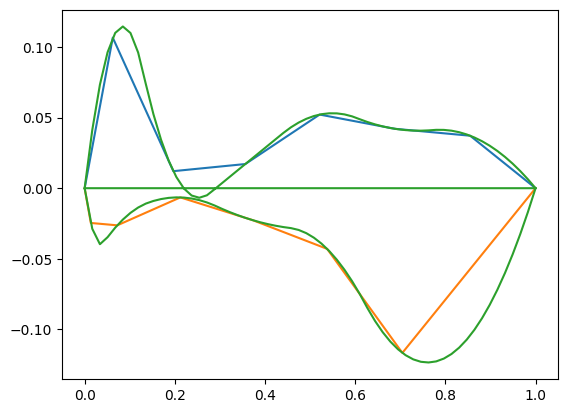

[[ 0.00000000e+00 -3.03648070e-18]
 [ 1.69491525e-02  4.12895889e-02]
 [ 3.38983051e-02  7.33942339e-02]
 [ 5.08474576e-02  9.63139349e-02]
 [ 6.77966102e-02  1.10048692e-01]
 [ 8.47457627e-02  1.14598505e-01]
 [ 1.01694915e-01  1.09963375e-01]
 [ 1.18644068e-01  9.61433003e-02]
 [ 1.35593220e-01  7.39336196e-02]
 [ 1.52542373e-01  5.24541375e-02]
 [ 1.69491525e-01  3.42917677e-02]
 [ 1.86440678e-01  1.94465102e-02]
 [ 2.03389831e-01  7.91836494e-03]
 [ 2.20338983e-01 -2.92668065e-04]
 [ 2.37288136e-01 -5.18658880e-03]
 [ 2.54237288e-01 -6.76339728e-03]
 [ 2.71186441e-01 -5.02309349e-03]
 [ 2.88135593e-01 -7.44422020e-04]
 [ 3.05084746e-01  3.69696356e-03]
 [ 3.22033898e-01  8.13642363e-03]
 [ 3.38983051e-01  1.25739582e-02]
 [ 3.55932203e-01  1.70095672e-02]
 [ 3.72881356e-01  2.14432508e-02]
 [ 3.89830508e-01  2.58750088e-02]
 [ 4.06779661e-01  3.03048413e-02]
 [ 4.23728814e-01  3.47327483e-02]
 [ 4.40677966e-01  3.91543888e-02]
 [ 4.57627119e-01  4.31646827e-02]
 [ 4.74576271e-01  4

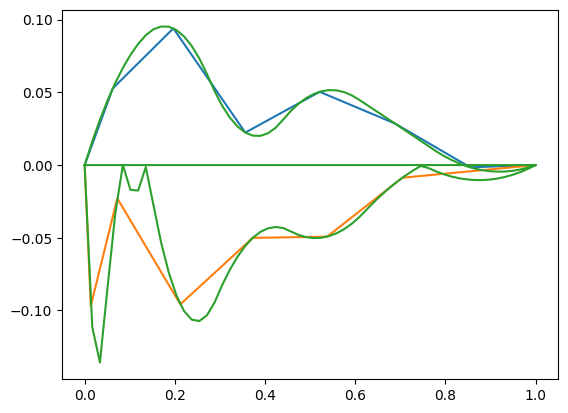

[[ 0.00000000e+00  4.18824924e-19]
 [ 1.69491525e-02  1.62784427e-02]
 [ 3.38983051e-02  3.10977671e-02]
 [ 5.08474576e-02  4.44579731e-02]
 [ 6.77966102e-02  5.63590607e-02]
 [ 8.47457627e-02  6.68010300e-02]
 [ 1.01694915e-01  7.57838809e-02]
 [ 1.18644068e-01  8.33076135e-02]
 [ 1.35593220e-01  8.93309327e-02]
 [ 1.52542373e-01  9.33803268e-02]
 [ 1.69491525e-01  9.53214797e-02]
 [ 1.86440678e-01  9.51543916e-02]
 [ 2.03389831e-01  9.28790625e-02]
 [ 2.20338983e-01  8.84954923e-02]
 [ 2.37288136e-01  8.20036810e-02]
 [ 2.54237288e-01  7.34036287e-02]
 [ 2.71186441e-01  6.26953353e-02]
 [ 2.88135593e-01  5.08382648e-02]
 [ 3.05084746e-01  4.07593766e-02]
 [ 3.22033898e-01  3.26615176e-02]
 [ 3.38983051e-01  2.65446876e-02]
 [ 3.55932203e-01  2.24088868e-02]
 [ 3.72881356e-01  2.02541150e-02]
 [ 3.89830508e-01  2.00803724e-02]
 [ 4.06779661e-01  2.18876589e-02]
 [ 4.23728814e-01  2.56759744e-02]
 [ 4.40677966e-01  3.14259968e-02]
 [ 4.57627119e-01  3.73346497e-02]
 [ 4.74576271e-01  4

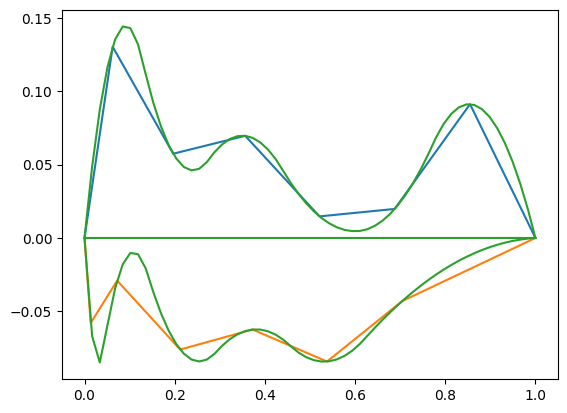

[[ 0.00000000e+00  1.98941839e-18]
 [ 1.69491525e-02  4.87850464e-02]
 [ 3.38983051e-02  8.75915498e-02]
 [ 5.08474576e-02  1.16419510e-01]
 [ 6.77966102e-02  1.35268927e-01]
 [ 8.47457627e-02  1.44139802e-01]
 [ 1.01694915e-01  1.43032133e-01]
 [ 1.18644068e-01  1.31945921e-01]
 [ 1.35593220e-01  1.11734791e-01]
 [ 1.52542373e-01  9.21868916e-02]
 [ 1.69491525e-01  7.60787201e-02]
 [ 1.86440678e-01  6.34102760e-02]
 [ 2.03389831e-01  5.41815594e-02]
 [ 2.20338983e-01  4.83925702e-02]
 [ 2.37288136e-01  4.60433086e-02]
 [ 2.54237288e-01  4.71337744e-02]
 [ 2.71186441e-01  5.16639677e-02]
 [ 2.88135593e-01  5.84307621e-02]
 [ 3.05084746e-01  6.37638771e-02]
 [ 3.22033898e-01  6.74089515e-02]
 [ 3.38983051e-01  6.93659854e-02]
 [ 3.55932203e-01  6.96349788e-02]
 [ 3.72881356e-01  6.82159317e-02]
 [ 3.89830508e-01  6.51088441e-02]
 [ 4.06779661e-01  6.03137159e-02]
 [ 4.23728814e-01  5.38305473e-02]
 [ 4.40677966e-01  4.56761568e-02]
 [ 4.57627119e-01  3.74199953e-02]
 [ 4.74576271e-01  3

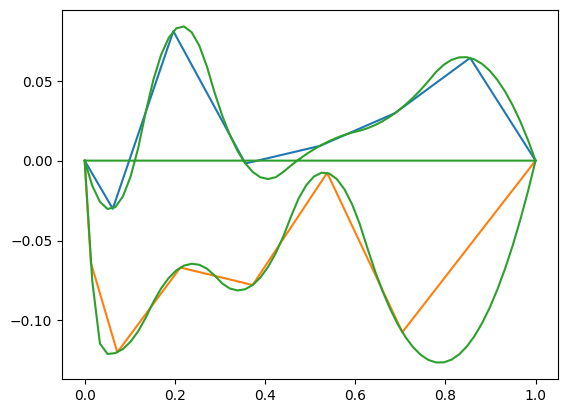

[[ 0.00000000e+00 -4.60707416e-18]
 [ 1.69491525e-02 -1.56799922e-02]
 [ 3.38983051e-02 -2.57654485e-02]
 [ 5.08474576e-02 -3.02563689e-02]
 [ 6.77966102e-02 -2.91527533e-02]
 [ 8.47457627e-02 -2.24546018e-02]
 [ 1.01694915e-01 -1.01619144e-02]
 [ 1.18644068e-01  7.72530901e-03]
 [ 1.35593220e-01  3.05482584e-02]
 [ 1.52542373e-01  5.07526355e-02]
 [ 1.69491525e-01  6.61955967e-02]
 [ 1.86440678e-01  7.68771420e-02]
 [ 2.03389831e-01  8.27972713e-02]
 [ 2.20338983e-01  8.39559847e-02]
 [ 2.37288136e-01  8.03532821e-02]
 [ 2.54237288e-01  7.19891636e-02]
 [ 2.71186441e-01  5.88636292e-02]
 [ 2.88135593e-01  4.26137773e-02]
 [ 3.05084746e-01  2.82337731e-02]
 [ 3.22033898e-01  1.60697265e-02]
 [ 3.38983051e-01  6.12163749e-03]
 [ 3.55932203e-01 -1.61049387e-03]
 [ 3.72881356e-01 -7.12666761e-03]
 [ 3.89830508e-01 -1.04268837e-02]
 [ 4.06779661e-01 -1.15111422e-02]
 [ 4.23728814e-01 -1.03794431e-02]
 [ 4.40677966e-01 -7.04809730e-03]
 [ 4.57627119e-01 -3.03917803e-03]
 [ 4.74576271e-01  6

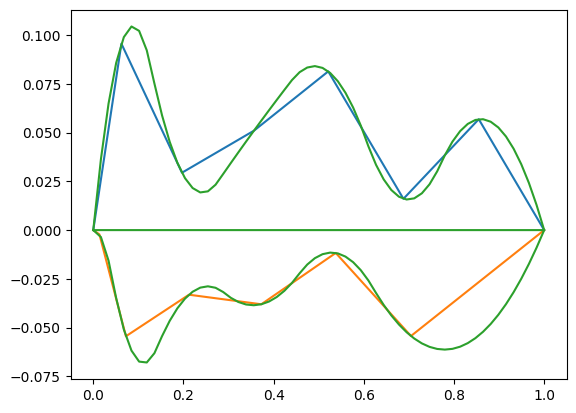

[[ 0.00000000e+00 -3.02502845e-18]
 [ 1.69491525e-02  3.62835308e-02]
 [ 3.38983051e-02  6.48598301e-02]
 [ 5.08474576e-02  8.57288979e-02]
 [ 6.77966102e-02  9.88907344e-02]
 [ 8.47457627e-02  1.04345339e-01]
 [ 1.01694915e-01  1.02092713e-01]
 [ 1.18644068e-01  9.21328551e-02]
 [ 1.35593220e-01  7.51354698e-02]
 [ 1.52542373e-01  5.87797730e-02]
 [ 1.69491525e-01  4.52440425e-02]
 [ 1.86440678e-01  3.45282782e-02]
 [ 2.03389831e-01  2.66324801e-02]
 [ 2.20338983e-01  2.15566484e-02]
 [ 2.37288136e-01  1.93007829e-02]
 [ 2.54237288e-01  1.98648836e-02]
 [ 2.71186441e-01  2.32489506e-02]
 [ 2.88135593e-01  2.87761289e-02]
 [ 3.05084746e-01  3.43815915e-02]
 [ 3.22033898e-01  3.99222399e-02]
 [ 3.38983051e-01  4.53980740e-02]
 [ 3.55932203e-01  5.08090940e-02]
 [ 3.72881356e-01  5.61552997e-02]
 [ 3.89830508e-01  6.14366913e-02]
 [ 4.06779661e-01  6.66532686e-02]
 [ 4.23728814e-01  7.18050317e-02]
 [ 4.40677966e-01  7.68817278e-02]
 [ 4.57627119e-01  8.09265949e-02]
 [ 4.74576271e-01  8

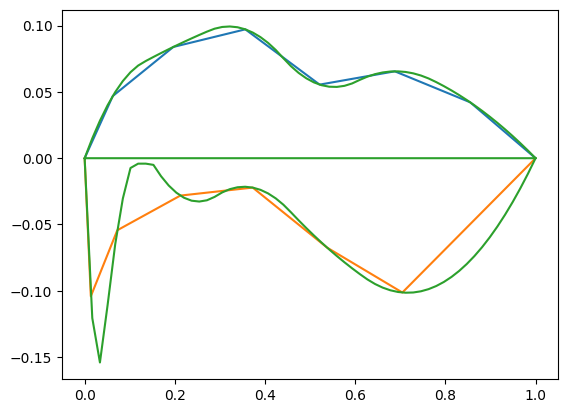

[[ 0.00000000e+00  4.18824924e-19]
 [ 1.69491525e-02  1.49615085e-02]
 [ 3.38983051e-02  2.82634276e-02]
 [ 5.08474576e-02  3.99057573e-02]
 [ 6.77966102e-02  4.98884976e-02]
 [ 8.47457627e-02  5.82116484e-02]
 [ 1.01694915e-01  6.48752099e-02]
 [ 1.18644068e-01  6.98791819e-02]
 [ 1.35593220e-01  7.33242096e-02]
 [ 1.52542373e-01  7.63643483e-02]
 [ 1.69491525e-01  7.93269560e-02]
 [ 1.86440678e-01  8.22120328e-02]
 [ 2.03389831e-01  8.50195786e-02]
 [ 2.20338983e-01  8.77495934e-02]
 [ 2.37288136e-01  9.04020772e-02]
 [ 2.54237288e-01  9.29770301e-02]
 [ 2.71186441e-01  9.54744520e-02]
 [ 2.88135593e-01  9.76903925e-02]
 [ 3.05084746e-01  9.90026763e-02]
 [ 3.22033898e-01  9.93681850e-02]
 [ 3.38983051e-01  9.87869185e-02]
 [ 3.55932203e-01  9.72588768e-02]
 [ 3.72881356e-01  9.47840599e-02]
 [ 3.89830508e-01  9.13624678e-02]
 [ 4.06779661e-01  8.69941005e-02]
 [ 4.23728814e-01  8.16789581e-02]
 [ 4.40677966e-01  7.54294293e-02]
 [ 4.57627119e-01  6.94015902e-02]
 [ 4.74576271e-01  6

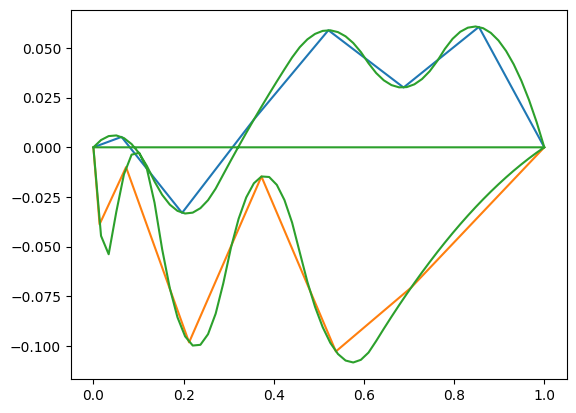

[[ 0.00000000e+00  6.28237385e-19]
 [ 1.69491525e-02  3.65923616e-03]
 [ 3.38983051e-02  5.65106590e-03]
 [ 5.08474576e-02  5.97548920e-03]
 [ 6.77966102e-02  4.63250607e-03]
 [ 8.47457627e-02  1.62211651e-03]
 [ 1.01694915e-01 -3.05567947e-03]
 [ 1.18644068e-01 -9.40088189e-03]
 [ 1.35593220e-01 -1.71934786e-02]
 [ 1.52542373e-01 -2.39106827e-02]
 [ 1.69491525e-01 -2.88368831e-02]
 [ 1.86440678e-01 -3.19720799e-02]
 [ 2.03389831e-01 -3.33162732e-02]
 [ 2.20338983e-01 -3.28694628e-02]
 [ 2.37288136e-01 -3.06316488e-02]
 [ 2.54237288e-01 -2.66028313e-02]
 [ 2.71186441e-01 -2.07830101e-02]
 [ 2.88135593e-01 -1.36259160e-02]
 [ 3.05084746e-01 -6.51570895e-03]
 [ 3.22033898e-01  4.51684886e-04]
 [ 3.38983051e-01  7.27626549e-03]
 [ 3.55932203e-01  1.39580328e-02]
 [ 3.72881356e-01  2.04969870e-02]
 [ 3.89830508e-01  2.68931278e-02]
 [ 4.06779661e-01  3.31464555e-02]
 [ 4.23728814e-01  3.92569699e-02]
 [ 4.40677966e-01  4.52177644e-02]
 [ 4.57627119e-01  5.03843379e-02]
 [ 4.74576271e-01  5

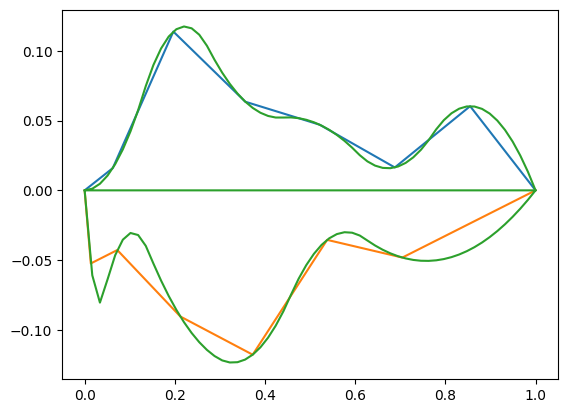

[[ 0.00000000e+00 -1.67529969e-18]
 [ 1.69491525e-02  1.19028847e-03]
 [ 3.38983051e-02  4.72413669e-03]
 [ 5.08474576e-02  1.06015447e-02]
 [ 6.77966102e-02  1.88225124e-02]
 [ 8.47457627e-02  2.93870398e-02]
 [ 1.01694915e-01  4.22951270e-02]
 [ 1.18644068e-01  5.75467740e-02]
 [ 1.35593220e-01  7.47838301e-02]
 [ 1.52542373e-01  8.98995331e-02]
 [ 1.69491525e-01  1.01728963e-01]
 [ 1.86440678e-01  1.10272121e-01]
 [ 2.03389831e-01  1.15529006e-01]
 [ 2.20338983e-01  1.17499618e-01]
 [ 2.37288136e-01  1.16183957e-01]
 [ 2.54237288e-01  1.11582023e-01]
 [ 2.71186441e-01  1.03693817e-01]
 [ 2.88135593e-01  9.35607275e-02]
 [ 3.05084746e-01  8.43596381e-02]
 [ 3.22033898e-01  7.63107159e-02]
 [ 3.38983051e-01  6.94139611e-02]
 [ 3.55932203e-01  6.36693734e-02]
 [ 3.72881356e-01  5.90769530e-02]
 [ 3.89830508e-01  5.56366999e-02]
 [ 4.06779661e-01  5.33486140e-02]
 [ 4.23728814e-01  5.22126954e-02]
 [ 4.40677966e-01  5.22175342e-02]
 [ 4.57627119e-01  5.22984098e-02]
 [ 4.74576271e-01  5

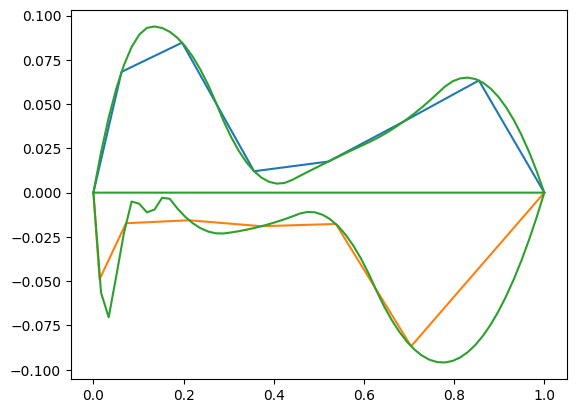

[[ 0.00000000e+00  1.25647477e-18]
 [ 1.69491525e-02  2.27557943e-02]
 [ 3.38983051e-02  4.23567583e-02]
 [ 5.08474576e-02  5.88028921e-02]
 [ 6.77966102e-02  7.20941957e-02]
 [ 8.47457627e-02  8.22306690e-02]
 [ 1.01694915e-01  8.92123122e-02]
 [ 1.18644068e-01  9.30391251e-02]
 [ 1.35593220e-01  9.38308305e-02]
 [ 1.52542373e-01  9.29602383e-02]
 [ 1.69491525e-01  9.08167583e-02]
 [ 1.86440678e-01  8.74003904e-02]
 [ 2.03389831e-01  8.27111348e-02]
 [ 2.20338983e-01  7.67489913e-02]
 [ 2.37288136e-01  6.95139599e-02]
 [ 2.54237288e-01  6.10060408e-02]
 [ 2.71186441e-01  5.12252338e-02]
 [ 2.88135593e-01  4.07907523e-02]
 [ 3.05084746e-01  3.15915807e-02]
 [ 3.22033898e-01  2.37586309e-02]
 [ 3.38983051e-01  1.72919031e-02]
 [ 3.55932203e-01  1.21913972e-02]
 [ 3.72881356e-01  8.45711318e-03]
 [ 3.89830508e-01  6.08905107e-03]
 [ 4.06779661e-01  5.08721086e-03]
 [ 4.23728814e-01  5.45159256e-03]
 [ 4.40677966e-01  7.17322243e-03]
 [ 4.57627119e-01  9.41470899e-03]
 [ 4.74576271e-01  1

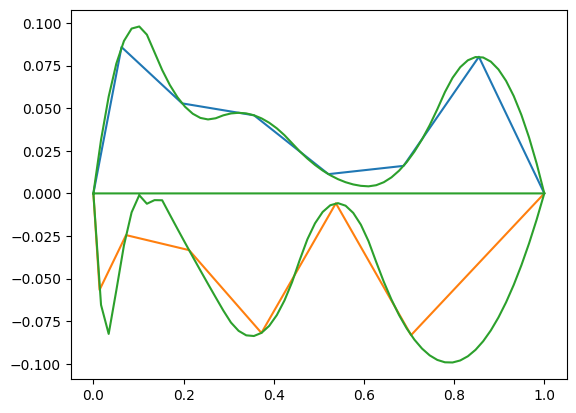

[[ 0.00000000e+00 -6.28237385e-19]
 [ 1.69491525e-02  3.14017402e-02]
 [ 3.38983051e-02  5.67687650e-02]
 [ 5.08474576e-02  7.61010743e-02]
 [ 6.77966102e-02  8.93986681e-02]
 [ 8.47457627e-02  9.66615465e-02]
 [ 1.01694915e-01  9.78897094e-02]
 [ 1.18644068e-01  9.30831568e-02]
 [ 1.35593220e-01  8.27261613e-02]
 [ 1.52542373e-01  7.23716720e-02]
 [ 1.69491525e-01  6.35948325e-02]
 [ 1.86440678e-01  5.63956428e-02]
 [ 2.03389831e-01  5.07741028e-02]
 [ 2.20338983e-01  4.67302126e-02]
 [ 2.37288136e-01  4.42639722e-02]
 [ 2.54237288e-01  4.33753814e-02]
 [ 2.71186441e-01  4.40644405e-02]
 [ 2.88135593e-01  4.57892326e-02]
 [ 3.05084746e-01  4.68965761e-02]
 [ 3.22033898e-01  4.72719008e-02]
 [ 3.38983051e-01  4.69152066e-02]
 [ 3.55932203e-01  4.58264936e-02]
 [ 3.72881356e-01  4.40057618e-02]
 [ 3.89830508e-01  4.14530111e-02]
 [ 4.06779661e-01  3.81682415e-02]
 [ 4.23728814e-01  3.41514532e-02]
 [ 4.40677966e-01  2.94105063e-02]
 [ 4.57627119e-01  2.46789006e-02]
 [ 4.74576271e-01  2

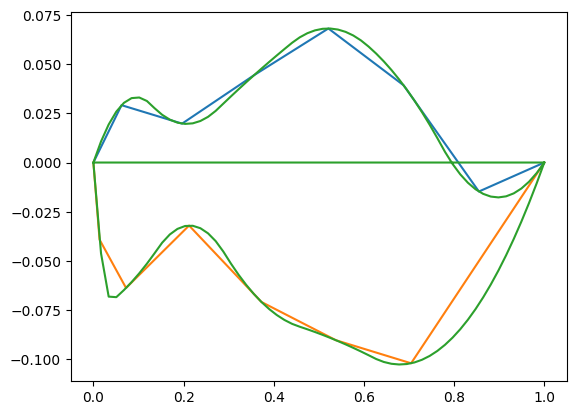

[[ 0.00000000e+00 -5.23531155e-20]
 [ 1.69491525e-02  1.07178276e-02]
 [ 3.38983051e-02  1.93541547e-02]
 [ 5.08474576e-02  2.59089814e-02]
 [ 6.77966102e-02  3.03823076e-02]
 [ 8.47457627e-02  3.27741334e-02]
 [ 1.01694915e-01  3.30844587e-02]
 [ 1.18644068e-01  3.13132836e-02]
 [ 1.35593220e-01  2.76511093e-02]
 [ 1.52542373e-01  2.42823345e-02]
 [ 1.69491525e-01  2.18265833e-02]
 [ 1.86440678e-01  2.02838557e-02]
 [ 2.03389831e-01  1.96541516e-02]
 [ 2.20338983e-01  1.99374712e-02]
 [ 2.37288136e-01  2.11338143e-02]
 [ 2.54237288e-01  2.32431811e-02]
 [ 2.71186441e-01  2.62655714e-02]
 [ 2.88135593e-01  2.99720043e-02]
 [ 3.05084746e-01  3.36639457e-02]
 [ 3.22033898e-01  3.72929852e-02]
 [ 3.38983051e-01  4.08591228e-02]
 [ 3.55932203e-01  4.43623585e-02]
 [ 3.72881356e-01  4.78026923e-02]
 [ 3.89830508e-01  5.11801242e-02]
 [ 4.06779661e-01  5.44946542e-02]
 [ 4.23728814e-01  5.77462823e-02]
 [ 4.40677966e-01  6.09311887e-02]
 [ 4.57627119e-01  6.36929268e-02]
 [ 4.74576271e-01  6

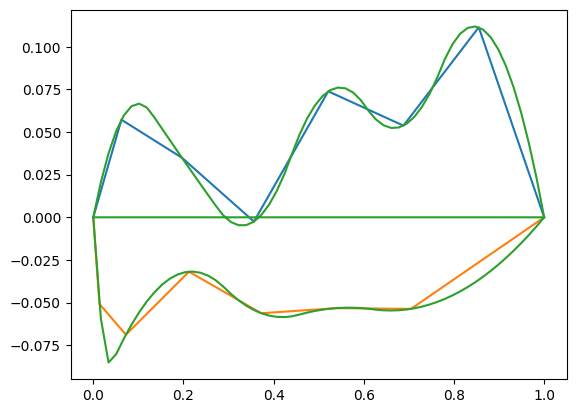

[[ 0.00000000e+00  4.18824924e-19]
 [ 1.69491525e-02  2.06697570e-02]
 [ 3.38983051e-02  3.75152053e-02]
 [ 5.08474576e-02  5.05363447e-02]
 [ 6.77966102e-02  5.97331753e-02]
 [ 8.47457627e-02  6.51056971e-02]
 [ 1.01694915e-01  6.66539102e-02]
 [ 1.18644068e-01  6.43778144e-02]
 [ 1.35593220e-01  5.85236768e-02]
 [ 1.52542373e-01  5.19153390e-02]
 [ 1.69491525e-01  4.53538087e-02]
 [ 1.86440678e-01  3.88390857e-02]
 [ 2.03389831e-01  3.23711702e-02]
 [ 2.20338983e-01  2.59500621e-02]
 [ 2.37288136e-01  1.95757615e-02]
 [ 2.54237288e-01  1.32482683e-02]
 [ 2.71186441e-01  6.96758246e-03]
 [ 2.88135593e-01  1.18621444e-03]
 [ 3.05084746e-01 -2.71539884e-03]
 [ 3.22033898e-01 -4.64158912e-03]
 [ 3.38983051e-01 -4.59235640e-03]
 [ 3.55932203e-01 -2.56770069e-03]
 [ 3.72881356e-01  1.43237802e-03]
 [ 3.89830508e-01  7.40787972e-03]
 [ 4.06779661e-01  1.53588044e-02]
 [ 4.23728814e-01  2.52851521e-02]
 [ 4.40677966e-01  3.71614312e-02]
 [ 4.57627119e-01  4.86088701e-02]
 [ 4.74576271e-01  5

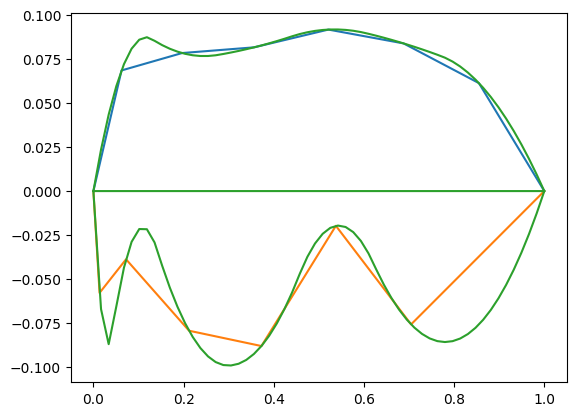

[[ 0.00000000e+00  2.93177447e-18]
 [ 1.69491525e-02  2.35419892e-02]
 [ 3.38983051e-02  4.33942432e-02]
 [ 5.08474576e-02  5.95567620e-02]
 [ 6.77966102e-02  7.20295456e-02]
 [ 8.47457627e-02  8.08125940e-02]
 [ 1.01694915e-01  8.59059072e-02]
 [ 1.18644068e-01  8.73094852e-02]
 [ 1.35593220e-01  8.52841511e-02]
 [ 1.52542373e-01  8.28206540e-02]
 [ 1.69491525e-01  8.07673463e-02]
 [ 1.86440678e-01  7.91242281e-02]
 [ 2.03389831e-01  7.78912994e-02]
 [ 2.20338983e-01  7.70685602e-02]
 [ 2.37288136e-01  7.66560104e-02]
 [ 2.54237288e-01  7.66536501e-02]
 [ 2.71186441e-01  7.70614793e-02]
 [ 2.88135593e-01  7.78001160e-02]
 [ 3.05084746e-01  7.86273960e-02]
 [ 3.22033898e-01  7.95265366e-02]
 [ 3.38983051e-01  8.04975379e-02]
 [ 3.55932203e-01  8.15403998e-02]
 [ 3.72881356e-01  8.26551223e-02]
 [ 3.89830508e-01  8.38417054e-02]
 [ 4.06779661e-01  8.51001491e-02]
 [ 4.23728814e-01  8.64304535e-02]
 [ 4.40677966e-01  8.78305341e-02]
 [ 4.57627119e-01  8.91058887e-02]
 [ 4.74576271e-01  9

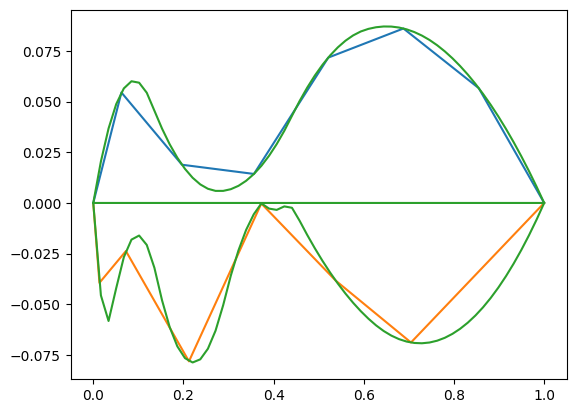

[[ 0.00000000e+00  3.40295250e-19]
 [ 1.69491525e-02  2.04797362e-02]
 [ 3.38983051e-02  3.67208657e-02]
 [ 5.08474576e-02  4.87233884e-02]
 [ 6.77966102e-02  5.64873043e-02]
 [ 8.47457627e-02  6.00126134e-02]
 [ 1.01694915e-01  5.92993158e-02]
 [ 1.18644068e-01  5.43474114e-02]
 [ 1.35593220e-01  4.54974330e-02]
 [ 1.52542373e-01  3.66541287e-02]
 [ 1.69491525e-01  2.89251147e-02]
 [ 1.86440678e-01  2.23103910e-02]
 [ 2.03389831e-01  1.68099577e-02]
 [ 2.20338983e-01  1.24238147e-02]
 [ 2.37288136e-01  9.15196214e-03]
 [ 2.54237288e-01  6.99439990e-03]
 [ 2.71186441e-01  5.95112801e-03]
 [ 2.88135593e-01  5.95302527e-03]
 [ 3.05084746e-01  6.78922916e-03]
 [ 3.22033898e-01  8.44512629e-03]
 [ 3.38983051e-01  1.09207167e-02]
 [ 3.55932203e-01  1.42160003e-02]
 [ 3.72881356e-01  1.83309772e-02]
 [ 3.89830508e-01  2.32656473e-02]
 [ 4.06779661e-01  2.90200106e-02]
 [ 4.23728814e-01  3.55940672e-02]
 [ 4.40677966e-01  4.29782299e-02]
 [ 4.57627119e-01  5.02778652e-02]
 [ 4.74576271e-01  5

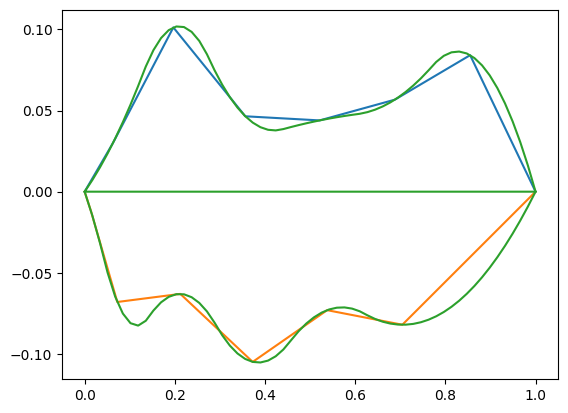

[[ 0.00000000e+00  1.67529969e-18]
 [ 1.69491525e-02  7.10830222e-03]
 [ 3.38983051e-02  1.49470838e-02]
 [ 5.08474576e-02  2.35163447e-02]
 [ 6.77966102e-02  3.28160850e-02]
 [ 8.47457627e-02  4.28463046e-02]
 [ 1.01694915e-01  5.36070036e-02]
 [ 1.18644068e-01  6.50981819e-02]
 [ 1.35593220e-01  7.71072480e-02]
 [ 1.52542373e-01  8.71965028e-02]
 [ 1.69491525e-01  9.46744714e-02]
 [ 1.86440678e-01  9.95411539e-02]
 [ 2.03389831e-01  1.01796550e-01]
 [ 2.20338983e-01  1.01440660e-01]
 [ 2.37288136e-01  9.84734841e-02]
 [ 2.54237288e-01  9.28950218e-02]
 [ 2.71186441e-01  8.47052733e-02]
 [ 2.88135593e-01  7.48017162e-02]
 [ 3.05084746e-01  6.59222133e-02]
 [ 3.22033898e-01  5.82565065e-02]
 [ 3.38983051e-01  5.18045957e-02]
 [ 3.55932203e-01  4.65664809e-02]
 [ 3.72881356e-01  4.25421622e-02]
 [ 3.89830508e-01  3.97316394e-02]
 [ 4.06779661e-01  3.81349127e-02]
 [ 4.23728814e-01  3.77519820e-02]
 [ 4.40677966e-01  3.85745813e-02]
 [ 4.57627119e-01  3.98313658e-02]
 [ 4.74576271e-01  4

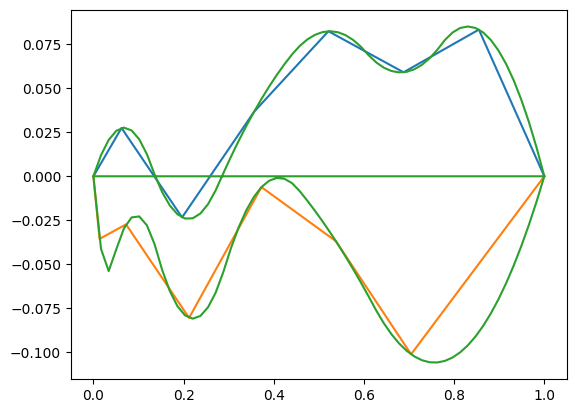

[[ 0.00000000e+00  2.30353708e-18]
 [ 1.69491525e-02  1.20292576e-02]
 [ 3.38983051e-02  2.06476250e-02]
 [ 5.08474576e-02  2.58551023e-02]
 [ 6.77966102e-02  2.76516894e-02]
 [ 8.47457627e-02  2.60373863e-02]
 [ 1.01694915e-01  2.10121931e-02]
 [ 1.18644068e-01  1.25761097e-02]
 [ 1.35593220e-01  1.10963970e-03]
 [ 1.52542373e-01 -9.02414154e-03]
 [ 1.69491525e-01 -1.65876090e-02]
 [ 1.86440678e-01 -2.15807626e-02]
 [ 2.03389831e-01 -2.40036024e-02]
 [ 2.20338983e-01 -2.38561284e-02]
 [ 2.37288136e-01 -2.11383406e-02]
 [ 2.54237288e-01 -1.58502389e-02]
 [ 2.71186441e-01 -7.99182351e-03]
 [ 2.88135593e-01  1.72302591e-03]
 [ 3.05084746e-01  1.11165334e-02]
 [ 3.22033898e-01  2.00377729e-02]
 [ 3.38983051e-01  2.84867444e-02]
 [ 3.55932203e-01  3.64634479e-02]
 [ 3.72881356e-01  4.39678833e-02]
 [ 3.89830508e-01  5.10000507e-02]
 [ 4.06779661e-01  5.75599501e-02]
 [ 4.23728814e-01  6.36475814e-02]
 [ 4.40677966e-01  6.92590779e-02]
 [ 4.57627119e-01  7.40336012e-02]
 [ 4.74576271e-01  7

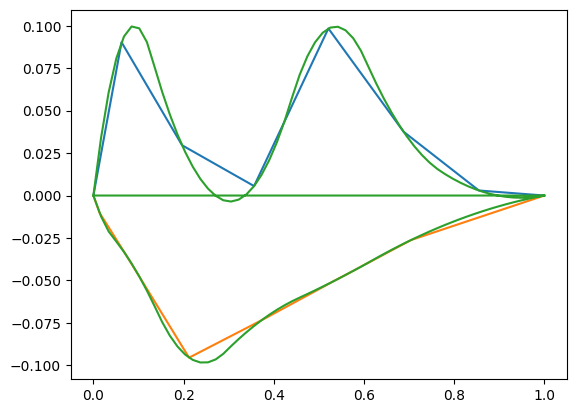

[[ 0.00000000e+00  1.78000593e-18]
 [ 1.69491525e-02  3.39131051e-02]
 [ 3.38983051e-02  6.08262869e-02]
 [ 5.08474576e-02  8.07395452e-02]
 [ 6.77966102e-02  9.36528802e-02]
 [ 8.47457627e-02  9.95662918e-02]
 [ 1.01694915e-01  9.84797800e-02]
 [ 1.18644068e-01  9.03933449e-02]
 [ 1.35593220e-01  7.58484842e-02]
 [ 1.52542373e-01  6.10543274e-02]
 [ 1.69491525e-01  4.77721493e-02]
 [ 1.86440678e-01  3.60019497e-02]
 [ 2.03389831e-01  2.57437288e-02]
 [ 2.20338983e-01  1.69974866e-02]
 [ 2.37288136e-01  9.76322290e-03]
 [ 2.54237288e-01  4.04093787e-03]
 [ 2.71186441e-01 -1.69368539e-04]
 [ 2.88135593e-01 -2.78277812e-03]
 [ 3.05084746e-01 -3.54023775e-03]
 [ 3.22033898e-01 -2.42379430e-03]
 [ 3.38983051e-01  5.66552241e-04]
 [ 3.55932203e-01  5.43080186e-03]
 [ 3.72881356e-01  1.21689546e-02]
 [ 3.89830508e-01  2.07810103e-02]
 [ 4.06779661e-01  3.12669692e-02]
 [ 4.23728814e-01  4.36268311e-02]
 [ 4.40677966e-01  5.78319359e-02]
 [ 4.57627119e-01  7.12078257e-02]
 [ 4.74576271e-01  8

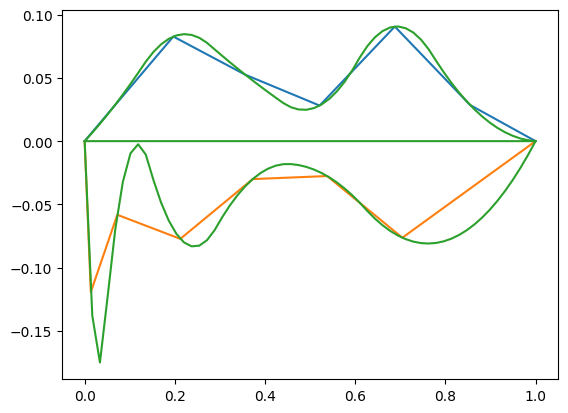

[[ 0.00000000e+00 -1.25647477e-18]
 [ 1.69491525e-02  6.70362459e-03]
 [ 3.38983051e-02  1.37404816e-02]
 [ 5.08474576e-02  2.11105709e-02]
 [ 6.77966102e-02  2.88138926e-02]
 [ 8.47457627e-02  3.68504467e-02]
 [ 1.01694915e-01  4.52202332e-02]
 [ 1.18644068e-01  5.39232520e-02]
 [ 1.35593220e-01  6.28329008e-02]
 [ 1.52542373e-01  7.04974827e-02]
 [ 1.69491525e-01  7.65052108e-02]
 [ 1.86440678e-01  8.08560853e-02]
 [ 2.03389831e-01  8.35501060e-02]
 [ 2.20338983e-01  8.45872731e-02]
 [ 2.37288136e-01  8.39675865e-02]
 [ 2.54237288e-01  8.16910462e-02]
 [ 2.71186441e-01  7.77576522e-02]
 [ 2.88135593e-01  7.25815861e-02]
 [ 3.05084746e-01  6.74263588e-02]
 [ 3.22033898e-01  6.23795350e-02]
 [ 3.38983051e-01  5.74411149e-02]
 [ 3.55932203e-01  5.26110984e-02]
 [ 3.72881356e-01  4.78894854e-02]
 [ 3.89830508e-01  4.32762761e-02]
 [ 4.06779661e-01  3.87714704e-02]
 [ 4.23728814e-01  3.43750683e-02]
 [ 4.40677966e-01  3.00962772e-02]
 [ 4.57627119e-01  2.67942934e-02]
 [ 4.74576271e-01  2

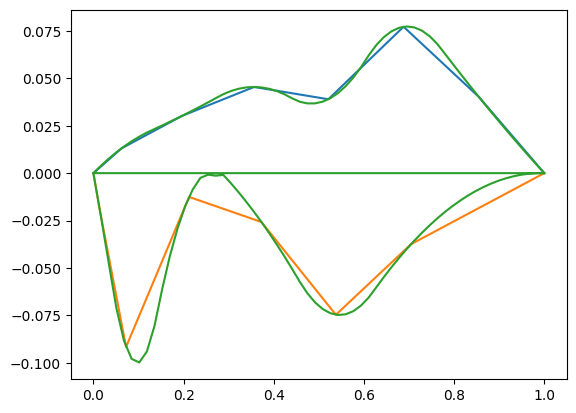

[[ 0.00000000e+00  0.00000000e+00]
 [ 1.69491525e-02  3.95595169e-03]
 [ 3.38983051e-02  7.61246249e-03]
 [ 5.08474576e-02  1.09695324e-02]
 [ 6.77966102e-02  1.40271614e-02]
 [ 8.47457627e-02  1.67853495e-02]
 [ 1.01694915e-01  1.92440967e-02]
 [ 1.18644068e-01  2.14034030e-02]
 [ 1.35593220e-01  2.32854182e-02]
 [ 1.52542373e-01  2.51441238e-02]
 [ 1.69491525e-01  2.70515640e-02]
 [ 1.86440678e-01  2.90077388e-02]
 [ 2.03389831e-01  3.10126482e-02]
 [ 2.20338983e-01  3.30662922e-02]
 [ 2.37288136e-01  3.51686708e-02]
 [ 2.54237288e-01  3.73197840e-02]
 [ 2.71186441e-01  3.95196318e-02]
 [ 2.88135593e-01  4.16444277e-02]
 [ 3.05084746e-01  4.33165465e-02]
 [ 3.22033898e-01  4.45098175e-02]
 [ 3.38983051e-01  4.52242407e-02]
 [ 3.55932203e-01  4.54598163e-02]
 [ 3.72881356e-01  4.52165441e-02]
 [ 3.89830508e-01  4.44944242e-02]
 [ 4.06779661e-01  4.32934565e-02]
 [ 4.23728814e-01  4.16136411e-02]
 [ 4.40677966e-01  3.94638583e-02]
 [ 4.57627119e-01  3.76727811e-02]
 [ 4.74576271e-01  3

([[0.018832372021427603,
   0.03053662997462693,
   0.015139191572741295,
   0.09155901680983103,
   0.08726928846176853,
   0.05997577624104844,
   0.0028064514454500533,
   0.04222933133651766,
   0.04154231888594648,
   0.026793011015870272,
   0.09938627670338085,
   0.09302118111996696,
   0.09865190300464953,
   0.03153128188180493,
   0.019469561130143077,
   0.09298665721937739],
  [0.015126146282371335,
   0.08387516935855488,
   0.007643335717663624,
   -0.28106927669483794,
   0.0854508507642368,
   0.018227735734255335,
   0.07983222877746042,
   0.09437228752555425,
   0.08781031956376091,
   0.012665148723779208,
   0.019004329369701367,
   0.08287870405946843,
   0.038052465139056184,
   0.02042584036246996,
   0.018367944305092556,
   0.04622469809086735],
  [0.06857012563432535,
   0.05893243925682237,
   0.05681357918436645,
   0.08875550382868136,
   0.10664938917159805,
   0.03499368472791185,
   0.009585795713760191,
   0.0878873829635175,
   0.09205698712551141,
 

In [ ]:

# Create DEAP types: FitnessMin for minimization, with 2 objectives (Cl and -Cd)
creator.create("FitnessMulti", base.Fitness, weights=(1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)

# Initialize DEAP toolbox
toolbox = base.Toolbox()

# Register individuals and population generator
toolbox.register("attr_float", np.random.uniform, 0, 0.1)  # Genes initialization
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=n_ctr_pts*2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Register genetic operators
toolbox.register("mate", tools.cxBlend, alpha=0.5)  # Blend crossover
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.1)  # Gaussian mutation
toolbox.register("select", tools.selNSGA2)  # NSGA-II selection

toolbox.register("evaluate", evaluate_airfoil)

# Create initial population (using NACA0012 as baseline)
initial_population = []
for _ in range(population_size):
    perturbation = np.random.normal(0, 0.01, size=n_ctr_pts * 2)
    individual = np.concatenate((std_y[:n_ctr_pts], np.abs(std_y[n_ctr_pts:]))) + perturbation
    initial_population.append(individual)

# Save population function
def save_population(population, generation):
    valid_individuals = [ind for ind in population if ind.fitness.values != (0.0, -1e5)]
    with open(f'populations/population_gen_{generation}.txt', 'w') as file:
        for ind in valid_individuals:
            file.write(f"{ind} Fitness: {ind.fitness.values}\n")

# Modified eaMuPlusLambda with a callback for saving populations
def custom_eaMuPlusLambda(population, toolbox, mu, lambda_, cxpb, mutpb, ngen, stats=None,
                          halloffame=None, verbose=__debug__):
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the entire population
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = list(map(toolbox.evaluate, invalid_ind))
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))

        # Vary the pool of individuals
        offspring = list(map(toolbox.clone, offspring))
        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            if np.random.random() < cxpb:
                toolbox.mate(ind1, ind2)
                del ind1.fitness.values
                del ind2.fitness.values

        for mutant in offspring:
            if np.random.random() < mutpb:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = list(map(toolbox.evaluate, invalid_ind))
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Replace the population with the offspring
        population[:] = offspring

        if halloffame is not None:
            halloffame.update(population)

        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)
        # Save the population of the current generation
        save_population(population, gen)

    return population, logbook

# Create the initial population
pop = toolbox.population(n=population_size)

# Apply the modified DEAP algorithm
custom_eaMuPlusLambda(pop, toolbox, mu=population_size, lambda_=population_size, cxpb=0.5, mutpb=0.2, ngen=max_generations, verbose=True)



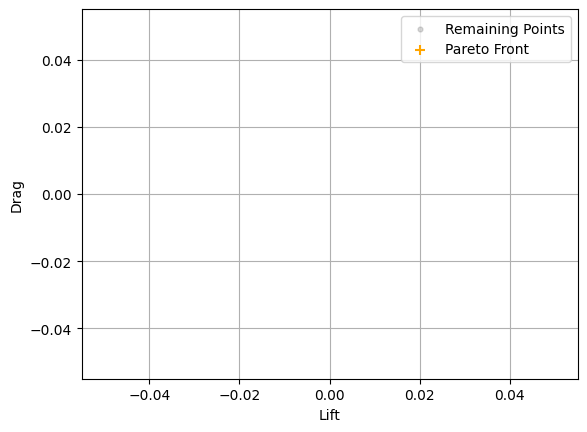

In [ ]:
import os
import matplotlib.pyplot as plt

def load_population(folder="populations"):
    populations = {}
    
    for filename in os.listdir(folder):
        if filename.startswith("population_gen_") and filename.endswith(".txt"):
            gen_num = int(filename.split('_')[-1].split('.')[0])
            population = []
            
            with open(os.path.join(folder, filename), 'r') as file:
                for line in file:
                    if line.strip():
                        parts = line.strip().split('Fitness:')
                        individual_str = parts[0].strip()[1:-1]
                        fitness_str = parts[1].strip()[1:-1]
                        individual = list(map(float, individual_str.split(',')))
                        fitness = tuple(map(float, fitness_str.split(',')))
                        population.append((individual, fitness))
            
            populations[gen_num] = population
    
    return populations

def dominates(point1, point2):
    return (point1[0] >= point2[0] and point1[1] <= point2[1]) and (point1 != point2)

def pareto_front(points):
    pareto_points = []
    for i, point1 in enumerate(points):
        is_dominated = False
        for j, point2 in enumerate(points):
            if i != j and dominates(point2, point1):
                is_dominated = True
                break
        if not is_dominated:
            pareto_points.append(point1)
    return pareto_points

# Load populations from the folder
populations = load_population()

lifts = []
drags = []
for gen, population in populations.items():
    for ind, fit in population:
        if fit[0] != 0 and fit[1] != -1e5:
            lifts.append(fit[0])
            drags.append(-fit[1])

# Combine the lists into a list of points
points = list(zip(lifts, drags))

# Find the Pareto front
pareto = pareto_front(points)

# Separate the Pareto front points
pareto_l = [p[0] for p in pareto]
pareto_d = [p[1] for p in pareto]

# Remove Pareto front points from lifts and drags
remaining_points = [p for p in points if p not in pareto]
remaining_l = [p[0] for p in remaining_points]
remaining_d = [p[1] for p in remaining_points]

# Plotting
plt.figure()
plt.scatter(remaining_l, remaining_d, color="grey", s=12, alpha=0.3, label="Remaining Points")
plt.scatter(pareto_l, pareto_d, color="orange", marker='+',s=50, label="Pareto Front")
plt.xlabel("Lift")
plt.ylabel("Drag")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
for gen, population in populations.items():
    for ind, fit in population:
        if fit[0] != 0 and fit[1] != -1e5:
            if fit[0] in pareto_l:
                best_indiv = np.array([ind[:n_ctr_pts], np.abs(ind[n_ctr_pts:])])
                best, foil = airfoil(best_indiv,  n_ctr_pts=n_ctr_pts, chord=std_x, nTimes=n_times)
                plot_foil(best)
                naca0012_fit = np.array(fitness(naca0012))
                print(f"naca0012 fitness : lift {naca0012_fit[0]}, drag : {naca0012_fit[1]}")
                print(f"best indiv fitness : lift {fit[0]}, drag : {-fit[1]}")

                
